In [1]:
#导入需要的包
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#读入数据
def images(type):
    if type == 'test':
        data_image = open('./MNIST/raw/t10k-images-idx3-ubyte', 'rb').read()
        data_label = open('./MNIST/raw/t10k-labels-idx1-ubyte', 'rb').read()
    else:
        data_image = open('./MNIST/raw/train-images-idx3-ubyte', 'rb').read()
        data_label = open('./MNIST/raw/train-labels-idx1-ubyte', 'rb').read()
    #文件头信息
    f_head = '>IIII'
    index = 0
    m_num,image_num,rows,columns = struct.unpack_from(f_head,data_image,index)
    #计算index在缓存中指针位置
    index = index + struct.calcsize('>IIII')
    data_ans = np.empty((image_num,rows * columns))
    f_image = '>' + str(rows * columns) + 'B'
    for i in range(image_num):
        data_ans[i] = np.array(struct.unpack_from(f_image, data_image, index)).reshape((1, rows * columns))
        index += struct.calcsize(f_image)
    
    #标签数据的文件头信息
    fhead_label = '>II'
    index_label = 0
    mnum_label,label_num = struct.unpack_from(fhead_label,data_label,index_label)
    index_label =index_label + struct.calcsize(fhead_label)
    fhead_image = '>B'
    labels_ans = np.empty((label_num, 1))
    for i in range(label_num):
        labels_ans[i] = np.array(struct.unpack_from(fhead_image, data_label, index_label)[0]).reshape((1, 1))
        index_label += struct.calcsize(fhead_image)
    
    return data_ans,labels_ans
train_data,train_labels = images('train')
test_data,test_labels = images('test')
train_data = np.append(train_data, train_labels, axis=1)

In [38]:
#定义训练模型的类,包含模型各部分函数
class neural_model:
    def __init__(self,train_data,l_r,regula_factor,hidden_layer_size):
        
        self.train_num = len(train_data)
        self.train_data = train_data
#         self.train_labels = train_labels
        self.l_r = l_r
        self.r_factor = regula_factor
        self.hidden_size = hidden_layer_size
        self.loss = []
        self.loss_predict = []
        self.batch_size = 50
        self.acc = []
        
        #网络
        self.w1 = (np.random.rand(28*28, self.hidden_size) - 0.5) * 2/28
        self.b1 = np.zeros((1,self.hidden_size))
        #输出层，10个类别
        self.w2 = (np.random.rand(self.hidden_size, 10) - 0.5) * 2 / np.sqrt(self.hidden_size)
        self.b2 = np.zeros((1,10))
        
    def train(self,epoches):
        
        times = self.train_num // self.batch_size
        for i in range(epoches):
            np.random.shuffle(self.train_data)
            print('epoch:' + str(i))
            for j in range(times):
                train_images = self.train_data[j * self.batch_size:(j+1) * self.batch_size,:-1]
                train_labels = self.train_data[j * self.batch_size:(j+1) * self.batch_size,-1:]
                ans = self.update_model(train_images,train_labels)
        return ans
    
    def update_model(self,images,labels):
        
        #1.images batch_size为784
        #2.激活函数采用relu
        #3.损失函数采用交叉熵+l2正则化
        #4.利用反向传播算法更新参数
        #2
        activation_output = np.maximum(np.matmul(images, self.w1) + self.b1, 0)
        output_layer = np.maximum(np.matmul(activation_output, self.w2) + self.b2, 0)
        score_classifies = np.exp(output_layer)
        score_sum = np.sum(score_classifies, axis = 1,keepdims = True)
        
        #3
        loss_1 = np.empty((self.batch_size, 1))
        for i in range(self.batch_size):
            loss_1[i] = score_classifies[i][int(labels[i])] / score_sum[i]
        crossentropy = -np.log(loss_1)
        
        #损失函数
        loss = np.mean(crossentropy, axis=0)[0] + 0.5 * self.r_factor * (np.sum( self.w1 * self.w1) + np.sum(self.w2 * self.w2))
#         print('loss:',loss,type(float(loss)))
        self.loss.append(loss)
        self.acc.append(self.predict(test_data,test_labels))
        
        #反向传播算法
        res = score_classifies / score_sum  # self.batchsize * 10
        for i in range(self.batch_size):
            res[i][int(labels[i])] -= 1
        res /= self.batch_size
        
        #梯度
        dw2 = np.matmul(activation_output.T, res)
#         dw2 += self.r_factor * self.w2
        db2 = np.sum(res, axis=0, keepdims = True)
        #第一层残差
        dh1 = np.dot(res, self.w2.T)
        dh1[activation_output <= 0] = 0
        
        dw1 = np.dot(images.T, dh1)
#         dw1 += self.r_factor * self.w1
        db1 = np.sum(dh1,axis=0, keepdims=True )
        
        dw2 += self.r_factor * self.w2
        dw1 += self.r_factor * self.w1
        
        self.w2 += -self.l_r * dw2
        self.w1 += -self.l_r * dw1
        self.b2 += -self.l_r * db2
        self.b1 += -self.l_r * db1
        return float(loss)
        
    def visulization(self):
        plt.plot(self.loss)
        plt.show
        
        plt.plot(self.loss_predict)
        plt.show
        
        plt.plot(self.acc)
        plt.show
    
    def predict(self, test_data, test_label):
        activation_output = np.maximum(np.matmul(test_data, self.w1) + self.b1, 0)
        output_layer = np.maximum(np.matmul(activation_output, self.w2) + self.b2, 0)
        
        score_classifies = np.exp(output_layer)
        score_sum = np.sum(score_classifies, axis = 1,keepdims = True)
        #3
        loss_1 = np.empty((self.batch_size, 1))
        for i in range(self.batch_size):
            loss_1[i] = score_classifies[i][int(test_label[i])] / score_sum[i]
        crossentropy = -np.log(loss_1)
        #损失函数
        loss = np.mean(crossentropy, axis=0)[0] + 0.5 * self.r_factor * (np.sum( self.w1 * self.w1) + np.sum(self.w2 * self.w2))
        print('loss:',loss,type(float(loss)))
        self.loss_predict.append(loss)
        
        prediction = np.argmax(output_layer, axis=1).reshape((len(test_data),1))
        acc = np.mean(prediction == test_label)
        print('the accuracy of test_data:' + str(acc))
        return acc
        
        
        
        
        

In [32]:
#min_loss = [l_r,r_factor,hidden_layer_size]
min_loss = []
min_loss_num = float('inf')
for i in range(4):
    model = neural_model(train_data,0.00001*10**(i+1),0.01, 100)
    loss = model.train(50)
    acc = model.predict(test_data, test_labels)
    min_loss.append({'acc':acc,'loss':loss,'i':i})
#     model.visulization()
min_loss

epoch:0


NameError: name 'labels' is not defined

In [28]:
min_loss = []
hidden_layer_num = [50,100,500,1000]
reg_factor = [0.1,0.01,0.001,0.0001]
for i in hidden_layer_num:
    for j in reg_factor:
        model = neural_model(train_data,0.0001,j,i)
        loss = model.train(50)
        acc = model.predict(test_data, test_labels)
        min_loss.append({'acc':acc,'loss':loss,'hidden_layer_num':i,'reg_factor':j})
#     model.visulization()
min_loss

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10
epoch:11
epoch:12
epoch:13
epoch:14
epoch:15
epoch:16
epoch:17
epoch:18
epoch:19
epoch:20
epoch:21
epoch:22
epoch:23
epoch:24
epoch:25
epoch:26
epoch:27
epoch:28
epoch:29
epoch:30
epoch:31
epoch:32
epoch:33
epoch:34
epoch:35
epoch:36
epoch:37
epoch:38
epoch:39
epoch:40
epoch:41
epoch:42
epoch:43
epoch:44
epoch:45
epoch:46
epoch:47
epoch:48
epoch:49
epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10
epoch:11
epoch:12
epoch:13
epoch:14
epoch:15
epoch:16
epoch:17
epoch:18
epoch:19
epoch:20
epoch:21
epoch:22
epoch:23
epoch:24
epoch:25
epoch:26
epoch:27
epoch:28
epoch:29
epoch:30
epoch:31
epoch:32
epoch:33
epoch:34
epoch:35
epoch:36
epoch:37
epoch:38
epoch:39
epoch:40
epoch:41
epoch:42
epoch:43
epoch:44
epoch:45
epoch:46
epoch:47
epoch:48
epoch:49
epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10
epoch:11
epoch:12
epoch:13
epoc

[{'acc': 0.9626,
  'loss': 0.3824216063238136,
  'hidden_layer_num': 50,
  'reg_factor': 0.1},
 {'acc': 0.9517,
  'loss': 0.16687625813119564,
  'hidden_layer_num': 50,
  'reg_factor': 0.01},
 {'acc': 0.9516,
  'loss': 0.20020339369790247,
  'hidden_layer_num': 50,
  'reg_factor': 0.001},
 {'acc': 0.9475,
  'loss': 0.037742031187672026,
  'hidden_layer_num': 50,
  'reg_factor': 0.0001},
 {'acc': 0.9679,
  'loss': 0.615725940081408,
  'hidden_layer_num': 100,
  'reg_factor': 0.1},
 {'acc': 0.9616,
  'loss': 0.16881759125575369,
  'hidden_layer_num': 100,
  'reg_factor': 0.01},
 {'acc': 0.9604,
  'loss': 0.026201163663021686,
  'hidden_layer_num': 100,
  'reg_factor': 0.001},
 {'acc': 0.9566,
  'loss': 0.05400090025973837,
  'hidden_layer_num': 100,
  'reg_factor': 0.0001},
 {'acc': 0.9719,
  'loss': 2.6175744783231822,
  'hidden_layer_num': 500,
  'reg_factor': 0.1},
 {'acc': 0.961,
  'loss': 0.75984692527415,
  'hidden_layer_num': 500,
  'reg_factor': 0.01},
 {'acc': 0.9642,
  'loss': 

In [39]:
model = neural_model(train_data,0.0001, 0.1, 500)
loss = model.train(50)

epoch:0
loss: 30.345109073128945 <class 'float'>
the accuracy of test_data:0.1276
loss: 26.51480699708496 <class 'float'>
the accuracy of test_data:0.126
loss: 22.360438257502928 <class 'float'>
the accuracy of test_data:0.1278
loss: 20.32549021397124 <class 'float'>
the accuracy of test_data:0.1335
loss: 20.442412183008607 <class 'float'>
the accuracy of test_data:0.174
loss: 19.371230990144426 <class 'float'>
the accuracy of test_data:0.1687
loss: 18.154294678415326 <class 'float'>
the accuracy of test_data:0.247
loss: 18.338866926166162 <class 'float'>
the accuracy of test_data:0.204
loss: 18.114055551183526 <class 'float'>
the accuracy of test_data:0.3037
loss: 17.34813179382853 <class 'float'>
the accuracy of test_data:0.3272
loss: 15.39046304521943 <class 'float'>
the accuracy of test_data:0.3521
loss: 16.295908903353666 <class 'float'>
the accuracy of test_data:0.3526
loss: 15.323931611948721 <class 'float'>
the accuracy of test_data:0.3711
loss: 14.993323164012985 <class 'float

loss: 10.191456333761177 <class 'float'>
the accuracy of test_data:0.7865
loss: 10.15938558168254 <class 'float'>
the accuracy of test_data:0.7889
loss: 10.179936220022057 <class 'float'>
the accuracy of test_data:0.7854
loss: 10.09992494772768 <class 'float'>
the accuracy of test_data:0.7912
loss: 10.175309180290734 <class 'float'>
the accuracy of test_data:0.7856
loss: 10.61365506975751 <class 'float'>
the accuracy of test_data:0.7668
loss: 10.350378186989765 <class 'float'>
the accuracy of test_data:0.7764
loss: 10.311044071922453 <class 'float'>
the accuracy of test_data:0.7792
loss: 10.280361848625477 <class 'float'>
the accuracy of test_data:0.7857
loss: 10.172650201124505 <class 'float'>
the accuracy of test_data:0.7871
loss: 9.777194703262603 <class 'float'>
the accuracy of test_data:0.799
loss: 9.696276868100027 <class 'float'>
the accuracy of test_data:0.7994
loss: 9.737040080023876 <class 'float'>
the accuracy of test_data:0.7939
loss: 9.738756108162697 <class 'float'>
the a

loss: 9.513399073874918 <class 'float'>
the accuracy of test_data:0.8396
loss: 9.588271507964146 <class 'float'>
the accuracy of test_data:0.838
loss: 9.725541900374253 <class 'float'>
the accuracy of test_data:0.8322
loss: 9.680169145604104 <class 'float'>
the accuracy of test_data:0.8309
loss: 9.714087075229273 <class 'float'>
the accuracy of test_data:0.8316
loss: 9.835604670149769 <class 'float'>
the accuracy of test_data:0.8332
loss: 9.80444338214108 <class 'float'>
the accuracy of test_data:0.8354
loss: 9.674327143116177 <class 'float'>
the accuracy of test_data:0.8351
loss: 9.57837729915123 <class 'float'>
the accuracy of test_data:0.8308
loss: 9.565093897505687 <class 'float'>
the accuracy of test_data:0.8265
loss: 9.761137574653691 <class 'float'>
the accuracy of test_data:0.8159
loss: 9.585958009042253 <class 'float'>
the accuracy of test_data:0.8252
loss: 9.640121190130168 <class 'float'>
the accuracy of test_data:0.8379
loss: 9.503926620966114 <class 'float'>
the accuracy o

loss: 9.29301150962454 <class 'float'>
the accuracy of test_data:0.8537
loss: 9.29957472771632 <class 'float'>
the accuracy of test_data:0.8538
loss: 9.383549732172936 <class 'float'>
the accuracy of test_data:0.8535
loss: 9.475568907743446 <class 'float'>
the accuracy of test_data:0.8477
loss: 9.384697593610623 <class 'float'>
the accuracy of test_data:0.8522
loss: 9.431331605875672 <class 'float'>
the accuracy of test_data:0.849
loss: 9.272559657589005 <class 'float'>
the accuracy of test_data:0.8597
loss: 9.260492485742176 <class 'float'>
the accuracy of test_data:0.8624
loss: 9.28548698346246 <class 'float'>
the accuracy of test_data:0.8596
loss: 9.24726890114243 <class 'float'>
the accuracy of test_data:0.8612
loss: 9.177678237468674 <class 'float'>
the accuracy of test_data:0.8606
loss: 9.107799690576517 <class 'float'>
the accuracy of test_data:0.8571
loss: 9.16036635280425 <class 'float'>
the accuracy of test_data:0.8607
loss: 9.089903460220174 <class 'float'>
the accuracy of t

loss: 9.257817520815214 <class 'float'>
the accuracy of test_data:0.8703
loss: 9.30206366597986 <class 'float'>
the accuracy of test_data:0.8686
loss: 9.32468093541268 <class 'float'>
the accuracy of test_data:0.8681
loss: 9.322851475305372 <class 'float'>
the accuracy of test_data:0.865
loss: 9.240875984926932 <class 'float'>
the accuracy of test_data:0.8703
loss: 9.208831676347465 <class 'float'>
the accuracy of test_data:0.8685
loss: 9.20270598331145 <class 'float'>
the accuracy of test_data:0.8684
loss: 9.291821029984751 <class 'float'>
the accuracy of test_data:0.8687
loss: 9.304783319787337 <class 'float'>
the accuracy of test_data:0.8593
loss: 9.312472537431779 <class 'float'>
the accuracy of test_data:0.8636
loss: 9.185221126368695 <class 'float'>
the accuracy of test_data:0.8574
loss: 9.203174232943022 <class 'float'>
the accuracy of test_data:0.8589
loss: 9.123722785389113 <class 'float'>
the accuracy of test_data:0.8555
loss: 9.128870086189407 <class 'float'>
the accuracy of

loss: 8.926728737620463 <class 'float'>
the accuracy of test_data:0.878
loss: 8.96107646462356 <class 'float'>
the accuracy of test_data:0.8745
loss: 8.90687870594575 <class 'float'>
the accuracy of test_data:0.8724
loss: 8.980661789811837 <class 'float'>
the accuracy of test_data:0.8739
loss: 9.011332894762447 <class 'float'>
the accuracy of test_data:0.8747
loss: 8.991398307920353 <class 'float'>
the accuracy of test_data:0.8754
loss: 9.110374574189352 <class 'float'>
the accuracy of test_data:0.8662
loss: 8.974022788715732 <class 'float'>
the accuracy of test_data:0.8789
loss: 8.977636096669588 <class 'float'>
the accuracy of test_data:0.8753
loss: 8.97423380291146 <class 'float'>
the accuracy of test_data:0.877
loss: 9.072744610755755 <class 'float'>
the accuracy of test_data:0.8755
loss: 9.004063139660005 <class 'float'>
the accuracy of test_data:0.8734
loss: 8.974931634158668 <class 'float'>
the accuracy of test_data:0.8774
loss: 9.02595055217187 <class 'float'>
the accuracy of t

loss: 8.963962042159057 <class 'float'>
the accuracy of test_data:0.8732
loss: 9.06292080653346 <class 'float'>
the accuracy of test_data:0.8776
loss: 8.943128977434565 <class 'float'>
the accuracy of test_data:0.8788
loss: 8.90624106790397 <class 'float'>
the accuracy of test_data:0.8817
loss: 8.891777157480005 <class 'float'>
the accuracy of test_data:0.8765
loss: 8.884159600505996 <class 'float'>
the accuracy of test_data:0.8734
loss: 8.90512944803058 <class 'float'>
the accuracy of test_data:0.8749
loss: 8.829231509765856 <class 'float'>
the accuracy of test_data:0.8779
loss: 8.873769635500084 <class 'float'>
the accuracy of test_data:0.8826
loss: 8.842808391548177 <class 'float'>
the accuracy of test_data:0.8829
loss: 8.842897601273307 <class 'float'>
the accuracy of test_data:0.8836
loss: 8.89730802566832 <class 'float'>
the accuracy of test_data:0.8824
loss: 8.903826059867981 <class 'float'>
the accuracy of test_data:0.8841
loss: 8.855373706459046 <class 'float'>
the accuracy of

loss: 9.045176585479613 <class 'float'>
the accuracy of test_data:0.8852
loss: 8.97632640444509 <class 'float'>
the accuracy of test_data:0.8844
loss: 9.055445344016318 <class 'float'>
the accuracy of test_data:0.8858
loss: 9.067101174689974 <class 'float'>
the accuracy of test_data:0.8847
loss: 9.041926108262041 <class 'float'>
the accuracy of test_data:0.8894
loss: 9.052693357769622 <class 'float'>
the accuracy of test_data:0.8886
loss: 9.034553191766399 <class 'float'>
the accuracy of test_data:0.8885
loss: 9.019520214247109 <class 'float'>
the accuracy of test_data:0.8911
loss: 9.044498221042437 <class 'float'>
the accuracy of test_data:0.8912
loss: 9.00583892543976 <class 'float'>
the accuracy of test_data:0.891
loss: 9.068765319593004 <class 'float'>
the accuracy of test_data:0.8891
loss: 9.016877398828903 <class 'float'>
the accuracy of test_data:0.8902
loss: 9.035362535473547 <class 'float'>
the accuracy of test_data:0.8923
loss: 9.054902093768842 <class 'float'>
the accuracy o

loss: 9.036999540961997 <class 'float'>
the accuracy of test_data:0.8873
loss: 8.966821099482148 <class 'float'>
the accuracy of test_data:0.8895
loss: 8.971493933079497 <class 'float'>
the accuracy of test_data:0.8897
loss: 8.93322303873227 <class 'float'>
the accuracy of test_data:0.8884
loss: 8.942174369041936 <class 'float'>
the accuracy of test_data:0.8911
loss: 8.951401986557515 <class 'float'>
the accuracy of test_data:0.8932
loss: 8.921880899089325 <class 'float'>
the accuracy of test_data:0.8956
loss: 8.914572867907953 <class 'float'>
the accuracy of test_data:0.8911
loss: 8.886174428123619 <class 'float'>
the accuracy of test_data:0.8876
loss: 8.87827278236685 <class 'float'>
the accuracy of test_data:0.8902
loss: 8.93894916096951 <class 'float'>
the accuracy of test_data:0.8931
loss: 8.967958846141793 <class 'float'>
the accuracy of test_data:0.8952
loss: 8.988591341898124 <class 'float'>
the accuracy of test_data:0.8929
loss: 8.930812300139566 <class 'float'>
the accuracy o

loss: 8.884791960654947 <class 'float'>
the accuracy of test_data:0.8958
loss: 8.963166681261141 <class 'float'>
the accuracy of test_data:0.8973
loss: 8.984779823181128 <class 'float'>
the accuracy of test_data:0.8958
loss: 9.057481099443253 <class 'float'>
the accuracy of test_data:0.8917
loss: 9.070797992942543 <class 'float'>
the accuracy of test_data:0.8902
loss: 9.000788287069872 <class 'float'>
the accuracy of test_data:0.8916
loss: 8.955941198354543 <class 'float'>
the accuracy of test_data:0.8934
loss: 8.994402111710924 <class 'float'>
the accuracy of test_data:0.8903
loss: 8.931416385245004 <class 'float'>
the accuracy of test_data:0.8928
loss: 8.931985092182304 <class 'float'>
the accuracy of test_data:0.8948
loss: 8.966041157936376 <class 'float'>
the accuracy of test_data:0.8957
loss: 8.987729264743738 <class 'float'>
the accuracy of test_data:0.8951
loss: 9.08769314402289 <class 'float'>
the accuracy of test_data:0.8913
loss: 9.072323576519665 <class 'float'>
the accuracy

loss: 8.833900169063972 <class 'float'>
the accuracy of test_data:0.8998
loss: 8.851590279248681 <class 'float'>
the accuracy of test_data:0.8986
loss: 8.861089123008895 <class 'float'>
the accuracy of test_data:0.8987
loss: 8.865862317336276 <class 'float'>
the accuracy of test_data:0.8991
loss: 8.873781878208996 <class 'float'>
the accuracy of test_data:0.8988
loss: 8.896601609232873 <class 'float'>
the accuracy of test_data:0.8995
loss: 8.898622787081024 <class 'float'>
the accuracy of test_data:0.8968
loss: 8.842163865838906 <class 'float'>
the accuracy of test_data:0.8927
loss: 8.834243582652256 <class 'float'>
the accuracy of test_data:0.8952
loss: 8.818350991806776 <class 'float'>
the accuracy of test_data:0.9
loss: 8.852206331271569 <class 'float'>
the accuracy of test_data:0.9009
loss: 8.870960962071742 <class 'float'>
the accuracy of test_data:0.9002
loss: 8.827852526174892 <class 'float'>
the accuracy of test_data:0.8998
loss: 8.85559307731257 <class 'float'>
the accuracy of

loss: 8.763747359334312 <class 'float'>
the accuracy of test_data:0.8997
loss: 8.79198237149574 <class 'float'>
the accuracy of test_data:0.899
loss: 8.871903287161915 <class 'float'>
the accuracy of test_data:0.8941
loss: 8.853142206381676 <class 'float'>
the accuracy of test_data:0.8961
loss: 8.734308825312088 <class 'float'>
the accuracy of test_data:0.9017
loss: 8.728957964518985 <class 'float'>
the accuracy of test_data:0.8997
loss: 8.722983086737093 <class 'float'>
the accuracy of test_data:0.8997
loss: 8.73044552121246 <class 'float'>
the accuracy of test_data:0.8993
loss: 8.751495260726017 <class 'float'>
the accuracy of test_data:0.9017
loss: 8.814731213356708 <class 'float'>
the accuracy of test_data:0.8981
loss: 8.826991513264606 <class 'float'>
the accuracy of test_data:0.8991
loss: 8.758194566661663 <class 'float'>
the accuracy of test_data:0.8985
loss: 8.752547921943671 <class 'float'>
the accuracy of test_data:0.9021
loss: 8.735493259666189 <class 'float'>
the accuracy o

loss: 8.766117351268875 <class 'float'>
the accuracy of test_data:0.9049
loss: 8.75486228346338 <class 'float'>
the accuracy of test_data:0.9058
loss: 8.787194471796525 <class 'float'>
the accuracy of test_data:0.9043
loss: 8.78469589053448 <class 'float'>
the accuracy of test_data:0.9038
loss: 8.787124471200414 <class 'float'>
the accuracy of test_data:0.9051
loss: 8.730389351525886 <class 'float'>
the accuracy of test_data:0.906
loss: 8.6766986459612 <class 'float'>
the accuracy of test_data:0.9016
loss: 8.724683502689759 <class 'float'>
the accuracy of test_data:0.9025
loss: 8.68609417880978 <class 'float'>
the accuracy of test_data:0.904
loss: 8.692132832648815 <class 'float'>
the accuracy of test_data:0.9058
loss: 8.67984568668622 <class 'float'>
the accuracy of test_data:0.9062
loss: 8.682281212868816 <class 'float'>
the accuracy of test_data:0.9036
loss: 8.633765360793802 <class 'float'>
the accuracy of test_data:0.9029
loss: 8.670560278109356 <class 'float'>
the accuracy of tes

loss: 8.642847808311906 <class 'float'>
the accuracy of test_data:0.8916
loss: 8.670794168024292 <class 'float'>
the accuracy of test_data:0.9001
loss: 8.6851445744834 <class 'float'>
the accuracy of test_data:0.8957
loss: 8.66099980495635 <class 'float'>
the accuracy of test_data:0.8979
loss: 8.680402840663069 <class 'float'>
the accuracy of test_data:0.8974
loss: 8.677546868538455 <class 'float'>
the accuracy of test_data:0.8983
loss: 8.678329844864857 <class 'float'>
the accuracy of test_data:0.9011
loss: 8.75292138093438 <class 'float'>
the accuracy of test_data:0.9027
loss: 8.72561449478182 <class 'float'>
the accuracy of test_data:0.9016
loss: 8.779141930140739 <class 'float'>
the accuracy of test_data:0.9062
loss: 8.75929068276985 <class 'float'>
the accuracy of test_data:0.9052
loss: 8.75229967588333 <class 'float'>
the accuracy of test_data:0.9032
loss: 8.75213111145263 <class 'float'>
the accuracy of test_data:0.8996
loss: 8.780505841996234 <class 'float'>
the accuracy of tes

loss: 8.825034931004424 <class 'float'>
the accuracy of test_data:0.9089
loss: 8.799941183794997 <class 'float'>
the accuracy of test_data:0.9083
loss: 8.803237926176289 <class 'float'>
the accuracy of test_data:0.9093
loss: 8.792464322357281 <class 'float'>
the accuracy of test_data:0.9095
loss: 8.789495374198923 <class 'float'>
the accuracy of test_data:0.9099
loss: 8.78174800519342 <class 'float'>
the accuracy of test_data:0.9067
loss: 8.780681986138676 <class 'float'>
the accuracy of test_data:0.9085
loss: 8.772336111810985 <class 'float'>
the accuracy of test_data:0.9087
loss: 8.76580364820823 <class 'float'>
the accuracy of test_data:0.9071
loss: 8.764869861715411 <class 'float'>
the accuracy of test_data:0.9057
loss: 8.799454531640833 <class 'float'>
the accuracy of test_data:0.907
loss: 8.80719619968462 <class 'float'>
the accuracy of test_data:0.9063
loss: 8.826572362125061 <class 'float'>
the accuracy of test_data:0.9005
loss: 8.792317545077081 <class 'float'>
the accuracy of

loss: 8.774629953644158 <class 'float'>
the accuracy of test_data:0.9112
loss: 8.757852078398118 <class 'float'>
the accuracy of test_data:0.9083
loss: 8.828607467433802 <class 'float'>
the accuracy of test_data:0.9068
loss: 8.845575278040481 <class 'float'>
the accuracy of test_data:0.9055
loss: 8.947266345566621 <class 'float'>
the accuracy of test_data:0.9053
loss: 8.946374698710532 <class 'float'>
the accuracy of test_data:0.9065
loss: 8.920616731506975 <class 'float'>
the accuracy of test_data:0.9081
loss: 8.91437192371635 <class 'float'>
the accuracy of test_data:0.9079
loss: 8.822029218695597 <class 'float'>
the accuracy of test_data:0.9128
loss: 8.795274864951798 <class 'float'>
the accuracy of test_data:0.9085
loss: 8.758044113023681 <class 'float'>
the accuracy of test_data:0.9105
loss: 8.788815951958686 <class 'float'>
the accuracy of test_data:0.9114
loss: 8.805742845374487 <class 'float'>
the accuracy of test_data:0.908
loss: 8.65618814873969 <class 'float'>
the accuracy o

loss: 8.745897713276493 <class 'float'>
the accuracy of test_data:0.9073
loss: 8.813570230155452 <class 'float'>
the accuracy of test_data:0.9104
loss: 8.794437317275227 <class 'float'>
the accuracy of test_data:0.9098
loss: 8.755825187032354 <class 'float'>
the accuracy of test_data:0.9098
loss: 8.795900462418247 <class 'float'>
the accuracy of test_data:0.9074
loss: 8.77251591807012 <class 'float'>
the accuracy of test_data:0.9066
loss: 8.8136456544931 <class 'float'>
the accuracy of test_data:0.9075
loss: 8.755105922085649 <class 'float'>
the accuracy of test_data:0.9075
loss: 8.7298772786233 <class 'float'>
the accuracy of test_data:0.9063
loss: 8.70845265526366 <class 'float'>
the accuracy of test_data:0.9062
loss: 8.694325572791188 <class 'float'>
the accuracy of test_data:0.9064
loss: 8.682968186744889 <class 'float'>
the accuracy of test_data:0.9095
loss: 8.71456730740791 <class 'float'>
the accuracy of test_data:0.9107
loss: 8.72000828368962 <class 'float'>
the accuracy of tes

loss: 8.636405408895236 <class 'float'>
the accuracy of test_data:0.9137
loss: 8.698274840346512 <class 'float'>
the accuracy of test_data:0.9133
loss: 8.69997962010376 <class 'float'>
the accuracy of test_data:0.9129
loss: 8.71587297402272 <class 'float'>
the accuracy of test_data:0.9084
loss: 8.725169922154825 <class 'float'>
the accuracy of test_data:0.9067
loss: 8.701727013961989 <class 'float'>
the accuracy of test_data:0.9087
loss: 8.678405875323886 <class 'float'>
the accuracy of test_data:0.9113
loss: 8.624135876823958 <class 'float'>
the accuracy of test_data:0.9122
loss: 8.602379922085152 <class 'float'>
the accuracy of test_data:0.9108
loss: 8.622561772934219 <class 'float'>
the accuracy of test_data:0.9114
loss: 8.595103173564585 <class 'float'>
the accuracy of test_data:0.9116
loss: 8.601146956954855 <class 'float'>
the accuracy of test_data:0.9107
loss: 8.581703531088671 <class 'float'>
the accuracy of test_data:0.9098
loss: 8.57008110265252 <class 'float'>
the accuracy o

loss: 8.674880275892855 <class 'float'>
the accuracy of test_data:0.916
loss: 8.697366467524786 <class 'float'>
the accuracy of test_data:0.9165
loss: 8.685180804835992 <class 'float'>
the accuracy of test_data:0.9152
loss: 8.640014315353275 <class 'float'>
the accuracy of test_data:0.9116
loss: 8.634260815172505 <class 'float'>
the accuracy of test_data:0.9116
loss: 8.653239369956413 <class 'float'>
the accuracy of test_data:0.9099
loss: 8.65599154912753 <class 'float'>
the accuracy of test_data:0.9059
loss: 8.596030590221865 <class 'float'>
the accuracy of test_data:0.9112
loss: 8.625850410478716 <class 'float'>
the accuracy of test_data:0.9081
loss: 8.609732740071777 <class 'float'>
the accuracy of test_data:0.9111
loss: 8.616065493864728 <class 'float'>
the accuracy of test_data:0.9065
loss: 8.589365009196168 <class 'float'>
the accuracy of test_data:0.9068
loss: 8.57450777451333 <class 'float'>
the accuracy of test_data:0.9105
loss: 8.610522657089879 <class 'float'>
the accuracy o

loss: 8.557913355736254 <class 'float'>
the accuracy of test_data:0.9167
loss: 8.584875441194802 <class 'float'>
the accuracy of test_data:0.9179
loss: 8.588824015316948 <class 'float'>
the accuracy of test_data:0.9162
loss: 8.596472448231095 <class 'float'>
the accuracy of test_data:0.9163
loss: 8.59589270983456 <class 'float'>
the accuracy of test_data:0.9176
loss: 8.522962456761187 <class 'float'>
the accuracy of test_data:0.9178
loss: 8.556783677473314 <class 'float'>
the accuracy of test_data:0.917
loss: 8.558192432562414 <class 'float'>
the accuracy of test_data:0.9183
loss: 8.563511380408475 <class 'float'>
the accuracy of test_data:0.916
loss: 8.55828715030086 <class 'float'>
the accuracy of test_data:0.9168
loss: 8.562982619555694 <class 'float'>
the accuracy of test_data:0.9146
loss: 8.543148319200293 <class 'float'>
the accuracy of test_data:0.9153
loss: 8.50245824076761 <class 'float'>
the accuracy of test_data:0.9123
loss: 8.498520838082767 <class 'float'>
the accuracy of 

loss: 8.451570529605991 <class 'float'>
the accuracy of test_data:0.9129
loss: 8.44369086752714 <class 'float'>
the accuracy of test_data:0.9139
loss: 8.443476784523396 <class 'float'>
the accuracy of test_data:0.9159
loss: 8.457648319162413 <class 'float'>
the accuracy of test_data:0.9135
loss: 8.42233503078989 <class 'float'>
the accuracy of test_data:0.9142
loss: 8.421670391093272 <class 'float'>
the accuracy of test_data:0.9154
loss: 8.43502162124484 <class 'float'>
the accuracy of test_data:0.9141
loss: 8.459997188887296 <class 'float'>
the accuracy of test_data:0.912
loss: 8.44737554126201 <class 'float'>
the accuracy of test_data:0.9134
loss: 8.437420900207531 <class 'float'>
the accuracy of test_data:0.9116
loss: 8.452422077437483 <class 'float'>
the accuracy of test_data:0.9086
loss: 8.433754418664419 <class 'float'>
the accuracy of test_data:0.9164
loss: 8.435367608086196 <class 'float'>
the accuracy of test_data:0.9166
loss: 8.428502789369896 <class 'float'>
the accuracy of 

loss: 8.422767089178949 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.431092968074742 <class 'float'>
the accuracy of test_data:0.9223
loss: 8.486545305518334 <class 'float'>
the accuracy of test_data:0.9193
loss: 8.476303656876143 <class 'float'>
the accuracy of test_data:0.9164
loss: 8.451547204531796 <class 'float'>
the accuracy of test_data:0.9136
loss: 8.464804450891007 <class 'float'>
the accuracy of test_data:0.9143
loss: 8.481822174451267 <class 'float'>
the accuracy of test_data:0.9174
loss: 8.478457825223312 <class 'float'>
the accuracy of test_data:0.9167
epoch:2
loss: 8.495855425267859 <class 'float'>
the accuracy of test_data:0.9172
loss: 8.47817640382737 <class 'float'>
the accuracy of test_data:0.9192
loss: 8.52736132528041 <class 'float'>
the accuracy of test_data:0.917
loss: 8.518402559119616 <class 'float'>
the accuracy of test_data:0.9172
loss: 8.513883391680007 <class 'float'>
the accuracy of test_data:0.9178
loss: 8.520658149898821 <class 'float'>
the ac

loss: 8.459356858590429 <class 'float'>
the accuracy of test_data:0.9202
loss: 8.459011861221049 <class 'float'>
the accuracy of test_data:0.9198
loss: 8.429886842797776 <class 'float'>
the accuracy of test_data:0.9209
loss: 8.43816078539561 <class 'float'>
the accuracy of test_data:0.9208
loss: 8.43482779713405 <class 'float'>
the accuracy of test_data:0.9215
loss: 8.41080718268169 <class 'float'>
the accuracy of test_data:0.9217
loss: 8.410327997274173 <class 'float'>
the accuracy of test_data:0.9228
loss: 8.416260271186658 <class 'float'>
the accuracy of test_data:0.9219
loss: 8.431030490743106 <class 'float'>
the accuracy of test_data:0.9197
loss: 8.425119327532487 <class 'float'>
the accuracy of test_data:0.92
loss: 8.435874946237917 <class 'float'>
the accuracy of test_data:0.9187
loss: 8.40974281178253 <class 'float'>
the accuracy of test_data:0.9198
loss: 8.405180005193607 <class 'float'>
the accuracy of test_data:0.9225
loss: 8.427929645918448 <class 'float'>
the accuracy of t

loss: 8.414371657170088 <class 'float'>
the accuracy of test_data:0.9201
loss: 8.414116631414194 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.414605434424736 <class 'float'>
the accuracy of test_data:0.9227
loss: 8.411211354430641 <class 'float'>
the accuracy of test_data:0.9236
loss: 8.382893627812656 <class 'float'>
the accuracy of test_data:0.9207
loss: 8.355108635260562 <class 'float'>
the accuracy of test_data:0.92
loss: 8.354587557564344 <class 'float'>
the accuracy of test_data:0.9204
loss: 8.373785634510973 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.375293184143125 <class 'float'>
the accuracy of test_data:0.9224
loss: 8.363334199630255 <class 'float'>
the accuracy of test_data:0.9203
loss: 8.358873773273372 <class 'float'>
the accuracy of test_data:0.9203
loss: 8.370457652180512 <class 'float'>
the accuracy of test_data:0.9208
loss: 8.390180737677598 <class 'float'>
the accuracy of test_data:0.9202
loss: 8.391346355425489 <class 'float'>
the accuracy 

loss: 8.422836604331751 <class 'float'>
the accuracy of test_data:0.9188
loss: 8.421423436503913 <class 'float'>
the accuracy of test_data:0.9191
loss: 8.422109315378476 <class 'float'>
the accuracy of test_data:0.9172
loss: 8.407499021027373 <class 'float'>
the accuracy of test_data:0.9182
loss: 8.407265400703999 <class 'float'>
the accuracy of test_data:0.9207
loss: 8.406353708276326 <class 'float'>
the accuracy of test_data:0.9185
loss: 8.378967266205386 <class 'float'>
the accuracy of test_data:0.9195
loss: 8.385338931942176 <class 'float'>
the accuracy of test_data:0.9189
loss: 8.380268322843005 <class 'float'>
the accuracy of test_data:0.9146
loss: 8.386740109546396 <class 'float'>
the accuracy of test_data:0.9212
loss: 8.39476630324187 <class 'float'>
the accuracy of test_data:0.9204
loss: 8.403952125165437 <class 'float'>
the accuracy of test_data:0.9211
loss: 8.412730530474018 <class 'float'>
the accuracy of test_data:0.9172
loss: 8.413856993051064 <class 'float'>
the accuracy

loss: 8.372641652623637 <class 'float'>
the accuracy of test_data:0.921
loss: 8.37499294532174 <class 'float'>
the accuracy of test_data:0.921
loss: 8.389088014075774 <class 'float'>
the accuracy of test_data:0.9224
loss: 8.398409957849784 <class 'float'>
the accuracy of test_data:0.9247
loss: 8.394270481553379 <class 'float'>
the accuracy of test_data:0.9242
loss: 8.354961055740274 <class 'float'>
the accuracy of test_data:0.923
loss: 8.372058618952304 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.371427401428226 <class 'float'>
the accuracy of test_data:0.921
loss: 8.340184359858368 <class 'float'>
the accuracy of test_data:0.9201
loss: 8.33899606048074 <class 'float'>
the accuracy of test_data:0.9198
loss: 8.317502278001825 <class 'float'>
the accuracy of test_data:0.9195
loss: 8.344921696405768 <class 'float'>
the accuracy of test_data:0.92
loss: 8.362251700777243 <class 'float'>
the accuracy of test_data:0.9201
loss: 8.359667759262539 <class 'float'>
the accuracy of tes

loss: 8.321201954213832 <class 'float'>
the accuracy of test_data:0.9205
loss: 8.31166550795048 <class 'float'>
the accuracy of test_data:0.9204
loss: 8.315474829296155 <class 'float'>
the accuracy of test_data:0.9231
loss: 8.296011949787824 <class 'float'>
the accuracy of test_data:0.9217
loss: 8.293277540074229 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.310451674212501 <class 'float'>
the accuracy of test_data:0.9226
loss: 8.345309508448622 <class 'float'>
the accuracy of test_data:0.9225
loss: 8.380511340790745 <class 'float'>
the accuracy of test_data:0.9204
loss: 8.380212610069181 <class 'float'>
the accuracy of test_data:0.9205
loss: 8.380738841136555 <class 'float'>
the accuracy of test_data:0.9245
loss: 8.388799794831481 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.365958430365904 <class 'float'>
the accuracy of test_data:0.9242
loss: 8.368257138017759 <class 'float'>
the accuracy of test_data:0.9252
loss: 8.36611517881393 <class 'float'>
the accuracy 

loss: 8.386298666423135 <class 'float'>
the accuracy of test_data:0.9239
loss: 8.379781050069038 <class 'float'>
the accuracy of test_data:0.9224
loss: 8.388688255850305 <class 'float'>
the accuracy of test_data:0.9209
loss: 8.382530452751924 <class 'float'>
the accuracy of test_data:0.9227
loss: 8.376047875221865 <class 'float'>
the accuracy of test_data:0.9221
loss: 8.37055529733764 <class 'float'>
the accuracy of test_data:0.9225
loss: 8.35352975385864 <class 'float'>
the accuracy of test_data:0.9228
loss: 8.3483174983385 <class 'float'>
the accuracy of test_data:0.9217
loss: 8.312144048162057 <class 'float'>
the accuracy of test_data:0.9232
loss: 8.312103790694678 <class 'float'>
the accuracy of test_data:0.9255
loss: 8.32392537078009 <class 'float'>
the accuracy of test_data:0.9267
loss: 8.321938663555054 <class 'float'>
the accuracy of test_data:0.9235
loss: 8.320936316754715 <class 'float'>
the accuracy of test_data:0.9247
loss: 8.326230483403586 <class 'float'>
the accuracy of 

loss: 8.35456502023811 <class 'float'>
the accuracy of test_data:0.9263
loss: 8.356155646160524 <class 'float'>
the accuracy of test_data:0.9266
loss: 8.35522558677822 <class 'float'>
the accuracy of test_data:0.9228
loss: 8.312077196789282 <class 'float'>
the accuracy of test_data:0.9257
loss: 8.313211426913853 <class 'float'>
the accuracy of test_data:0.9247
loss: 8.303451561761785 <class 'float'>
the accuracy of test_data:0.9255
loss: 8.305980273395996 <class 'float'>
the accuracy of test_data:0.925
loss: 8.309815903926411 <class 'float'>
the accuracy of test_data:0.9222
loss: 8.318685726930354 <class 'float'>
the accuracy of test_data:0.9245
loss: 8.328480413835857 <class 'float'>
the accuracy of test_data:0.9236
loss: 8.339674602075522 <class 'float'>
the accuracy of test_data:0.9216
loss: 8.322159612852657 <class 'float'>
the accuracy of test_data:0.9247
loss: 8.319034326274018 <class 'float'>
the accuracy of test_data:0.925
loss: 8.326432449603304 <class 'float'>
the accuracy of

loss: 8.283114017451995 <class 'float'>
the accuracy of test_data:0.9282
loss: 8.331829262368643 <class 'float'>
the accuracy of test_data:0.926
loss: 8.301187996035448 <class 'float'>
the accuracy of test_data:0.9257
loss: 8.29863610192823 <class 'float'>
the accuracy of test_data:0.9196
loss: 8.275804619506115 <class 'float'>
the accuracy of test_data:0.923
loss: 8.288074355869238 <class 'float'>
the accuracy of test_data:0.9251
loss: 8.291268429410987 <class 'float'>
the accuracy of test_data:0.9252
loss: 8.31947802085625 <class 'float'>
the accuracy of test_data:0.9246
loss: 8.319473838968308 <class 'float'>
the accuracy of test_data:0.9255
loss: 8.309849766511466 <class 'float'>
the accuracy of test_data:0.9264
loss: 8.311708093872122 <class 'float'>
the accuracy of test_data:0.926
loss: 8.313468221118269 <class 'float'>
the accuracy of test_data:0.9255
loss: 8.30600649684752 <class 'float'>
the accuracy of test_data:0.9227
loss: 8.331425011859315 <class 'float'>
the accuracy of t

loss: 8.34077031202648 <class 'float'>
the accuracy of test_data:0.9286
loss: 8.314723509948339 <class 'float'>
the accuracy of test_data:0.9289
loss: 8.314269075913499 <class 'float'>
the accuracy of test_data:0.9271
loss: 8.330529113920663 <class 'float'>
the accuracy of test_data:0.9257
loss: 8.355039066536625 <class 'float'>
the accuracy of test_data:0.9267
loss: 8.292313568690487 <class 'float'>
the accuracy of test_data:0.927
loss: 8.30279403593027 <class 'float'>
the accuracy of test_data:0.9279
loss: 8.286101513592884 <class 'float'>
the accuracy of test_data:0.921
loss: 8.280712213422172 <class 'float'>
the accuracy of test_data:0.9266
loss: 8.293830330304518 <class 'float'>
the accuracy of test_data:0.9272
loss: 8.276835886065898 <class 'float'>
the accuracy of test_data:0.9296
loss: 8.292144293691152 <class 'float'>
the accuracy of test_data:0.9269
loss: 8.29346328886931 <class 'float'>
the accuracy of test_data:0.9261
loss: 8.310225767460285 <class 'float'>
the accuracy of 

loss: 8.276311692437904 <class 'float'>
the accuracy of test_data:0.931
loss: 8.249500220816053 <class 'float'>
the accuracy of test_data:0.9307
loss: 8.2431059995091 <class 'float'>
the accuracy of test_data:0.9291
loss: 8.237157921151224 <class 'float'>
the accuracy of test_data:0.9304
loss: 8.23895624450498 <class 'float'>
the accuracy of test_data:0.93
loss: 8.249495447116393 <class 'float'>
the accuracy of test_data:0.9282
loss: 8.2504253122638 <class 'float'>
the accuracy of test_data:0.9277
loss: 8.230336224633055 <class 'float'>
the accuracy of test_data:0.9274
loss: 8.25538055442331 <class 'float'>
the accuracy of test_data:0.9163
loss: 8.252580330620756 <class 'float'>
the accuracy of test_data:0.9231
loss: 8.255719450388373 <class 'float'>
the accuracy of test_data:0.9191
loss: 8.25476711755257 <class 'float'>
the accuracy of test_data:0.9302
loss: 8.238103339654502 <class 'float'>
the accuracy of test_data:0.9288
loss: 8.238557450340508 <class 'float'>
the accuracy of test_

loss: 8.219945021279795 <class 'float'>
the accuracy of test_data:0.929
loss: 8.215042298955662 <class 'float'>
the accuracy of test_data:0.9271
loss: 8.217137543614909 <class 'float'>
the accuracy of test_data:0.927
loss: 8.213043482244277 <class 'float'>
the accuracy of test_data:0.9289
loss: 8.20101433967609 <class 'float'>
the accuracy of test_data:0.9296
loss: 8.20334424144336 <class 'float'>
the accuracy of test_data:0.9281
loss: 8.200568565975203 <class 'float'>
the accuracy of test_data:0.928
loss: 8.194674478994083 <class 'float'>
the accuracy of test_data:0.9207
loss: 8.190922887573063 <class 'float'>
the accuracy of test_data:0.9259
loss: 8.183437723298319 <class 'float'>
the accuracy of test_data:0.9264
loss: 8.176466368853589 <class 'float'>
the accuracy of test_data:0.9277
loss: 8.175132410617401 <class 'float'>
the accuracy of test_data:0.9291
loss: 8.209111383869905 <class 'float'>
the accuracy of test_data:0.9314
loss: 8.20814044834802 <class 'float'>
the accuracy of t

loss: 8.136718640827212 <class 'float'>
the accuracy of test_data:0.9317
loss: 8.147954905573172 <class 'float'>
the accuracy of test_data:0.9308
loss: 8.149339713484212 <class 'float'>
the accuracy of test_data:0.9319
loss: 8.156485413058746 <class 'float'>
the accuracy of test_data:0.9329
loss: 8.14322627914331 <class 'float'>
the accuracy of test_data:0.9313
loss: 8.147518392666642 <class 'float'>
the accuracy of test_data:0.931
loss: 8.132642075212935 <class 'float'>
the accuracy of test_data:0.9284
loss: 8.144251919058005 <class 'float'>
the accuracy of test_data:0.9275
loss: 8.162283772211644 <class 'float'>
the accuracy of test_data:0.9279
loss: 8.154870948719006 <class 'float'>
the accuracy of test_data:0.9295
loss: 8.16257067461903 <class 'float'>
the accuracy of test_data:0.9311
loss: 8.173969559177612 <class 'float'>
the accuracy of test_data:0.9297
loss: 8.19280111959529 <class 'float'>
the accuracy of test_data:0.9302
loss: 8.20373372141886 <class 'float'>
the accuracy of 

loss: 8.157525330351834 <class 'float'>
the accuracy of test_data:0.9304
loss: 8.154598142903273 <class 'float'>
the accuracy of test_data:0.9297
loss: 8.180512932414155 <class 'float'>
the accuracy of test_data:0.9264
loss: 8.194055394533665 <class 'float'>
the accuracy of test_data:0.9268
loss: 8.186867634843617 <class 'float'>
the accuracy of test_data:0.9228
loss: 8.192679157845298 <class 'float'>
the accuracy of test_data:0.9217
loss: 8.185981340197717 <class 'float'>
the accuracy of test_data:0.9261
loss: 8.183187855172497 <class 'float'>
the accuracy of test_data:0.9273
loss: 8.186745720009856 <class 'float'>
the accuracy of test_data:0.9256
loss: 8.179786406528148 <class 'float'>
the accuracy of test_data:0.9305
loss: 8.187500914436631 <class 'float'>
the accuracy of test_data:0.9301
loss: 8.17139819974147 <class 'float'>
the accuracy of test_data:0.9307
loss: 8.172522659150783 <class 'float'>
the accuracy of test_data:0.93
loss: 8.190298687540013 <class 'float'>
the accuracy o

loss: 8.182508317541426 <class 'float'>
the accuracy of test_data:0.929
loss: 8.175267802948955 <class 'float'>
the accuracy of test_data:0.9295
loss: 8.183816451131086 <class 'float'>
the accuracy of test_data:0.9277
loss: 8.173038505571846 <class 'float'>
the accuracy of test_data:0.929
loss: 8.137769200760472 <class 'float'>
the accuracy of test_data:0.9284
loss: 8.154874527657975 <class 'float'>
the accuracy of test_data:0.931
loss: 8.15624453883798 <class 'float'>
the accuracy of test_data:0.9307
loss: 8.163138275876793 <class 'float'>
the accuracy of test_data:0.9311
loss: 8.16861465039522 <class 'float'>
the accuracy of test_data:0.9303
loss: 8.166051454110358 <class 'float'>
the accuracy of test_data:0.9303
loss: 8.151092986605862 <class 'float'>
the accuracy of test_data:0.9312
loss: 8.15161689064223 <class 'float'>
the accuracy of test_data:0.93
loss: 8.143113669778637 <class 'float'>
the accuracy of test_data:0.9278
loss: 8.143989157875023 <class 'float'>
the accuracy of tes

loss: 8.169826243278367 <class 'float'>
the accuracy of test_data:0.9304
loss: 8.176429563198202 <class 'float'>
the accuracy of test_data:0.9294
loss: 8.181289596000427 <class 'float'>
the accuracy of test_data:0.9282
loss: 8.18211152668723 <class 'float'>
the accuracy of test_data:0.9294
loss: 8.176840493028838 <class 'float'>
the accuracy of test_data:0.9278
loss: 8.18721698047128 <class 'float'>
the accuracy of test_data:0.9299
loss: 8.201975951922341 <class 'float'>
the accuracy of test_data:0.9286
loss: 8.203534559292272 <class 'float'>
the accuracy of test_data:0.928
loss: 8.140653491900132 <class 'float'>
the accuracy of test_data:0.931
loss: 8.140171662691586 <class 'float'>
the accuracy of test_data:0.931
loss: 8.14076810745605 <class 'float'>
the accuracy of test_data:0.9322
loss: 8.147911742095117 <class 'float'>
the accuracy of test_data:0.932
loss: 8.159409052818877 <class 'float'>
the accuracy of test_data:0.9323
loss: 8.158985061567524 <class 'float'>
the accuracy of te

loss: 8.098417929571964 <class 'float'>
the accuracy of test_data:0.9311
loss: 8.108214306103703 <class 'float'>
the accuracy of test_data:0.9321
loss: 8.128759823776525 <class 'float'>
the accuracy of test_data:0.9333
loss: 8.124895843557866 <class 'float'>
the accuracy of test_data:0.9333
loss: 8.11449345109946 <class 'float'>
the accuracy of test_data:0.9317
loss: 8.10623232853768 <class 'float'>
the accuracy of test_data:0.932
loss: 8.120296321664048 <class 'float'>
the accuracy of test_data:0.9331
loss: 8.115057674027014 <class 'float'>
the accuracy of test_data:0.9333
loss: 8.120308458831955 <class 'float'>
the accuracy of test_data:0.9329
loss: 8.118360940282166 <class 'float'>
the accuracy of test_data:0.9323
loss: 8.103340184731362 <class 'float'>
the accuracy of test_data:0.9324
loss: 8.106346744764117 <class 'float'>
the accuracy of test_data:0.9335
loss: 8.132452831220311 <class 'float'>
the accuracy of test_data:0.9325
loss: 8.129623427970799 <class 'float'>
the accuracy o

loss: 8.12290814772382 <class 'float'>
the accuracy of test_data:0.9342
loss: 8.122427994074009 <class 'float'>
the accuracy of test_data:0.9341
loss: 8.115034062455802 <class 'float'>
the accuracy of test_data:0.9349
loss: 8.108798147816758 <class 'float'>
the accuracy of test_data:0.9354
loss: 8.104504582053638 <class 'float'>
the accuracy of test_data:0.9338
loss: 8.103863001225506 <class 'float'>
the accuracy of test_data:0.9351
loss: 8.103323231600802 <class 'float'>
the accuracy of test_data:0.9343
loss: 8.104387471699708 <class 'float'>
the accuracy of test_data:0.9344
loss: 8.100244083614347 <class 'float'>
the accuracy of test_data:0.9349
loss: 8.097103432848598 <class 'float'>
the accuracy of test_data:0.9333
loss: 8.09300339294444 <class 'float'>
the accuracy of test_data:0.934
loss: 8.08917194173466 <class 'float'>
the accuracy of test_data:0.9348
loss: 8.094935919204405 <class 'float'>
the accuracy of test_data:0.9346
loss: 8.095768170129297 <class 'float'>
the accuracy of

loss: 8.131572250331152 <class 'float'>
the accuracy of test_data:0.9329
loss: 8.135638763725515 <class 'float'>
the accuracy of test_data:0.9321
loss: 8.1074331433035 <class 'float'>
the accuracy of test_data:0.9316
loss: 8.084772772526247 <class 'float'>
the accuracy of test_data:0.9333
loss: 8.076287056837067 <class 'float'>
the accuracy of test_data:0.9328
loss: 8.0582856235358 <class 'float'>
the accuracy of test_data:0.9347
loss: 8.079808061284744 <class 'float'>
the accuracy of test_data:0.9348
loss: 8.070949937227809 <class 'float'>
the accuracy of test_data:0.9354
loss: 8.088833196900074 <class 'float'>
the accuracy of test_data:0.9328
loss: 8.078570541368732 <class 'float'>
the accuracy of test_data:0.9319
loss: 8.087498927728085 <class 'float'>
the accuracy of test_data:0.9311
loss: 8.086840964812426 <class 'float'>
the accuracy of test_data:0.9302
loss: 8.087270487823227 <class 'float'>
the accuracy of test_data:0.9291
loss: 8.102015102371583 <class 'float'>
the accuracy of

loss: 8.103859986627333 <class 'float'>
the accuracy of test_data:0.9325
loss: 8.09961175574437 <class 'float'>
the accuracy of test_data:0.9326
loss: 8.10602221847315 <class 'float'>
the accuracy of test_data:0.9344
loss: 8.113476048415626 <class 'float'>
the accuracy of test_data:0.9332
loss: 8.106463331412805 <class 'float'>
the accuracy of test_data:0.9346
loss: 8.103781477900652 <class 'float'>
the accuracy of test_data:0.9332
loss: 8.116821574458564 <class 'float'>
the accuracy of test_data:0.9324
loss: 8.115382652636375 <class 'float'>
the accuracy of test_data:0.9315
loss: 8.116461763701203 <class 'float'>
the accuracy of test_data:0.9329
loss: 8.115054850867688 <class 'float'>
the accuracy of test_data:0.9331
loss: 8.12985909633054 <class 'float'>
the accuracy of test_data:0.9316
loss: 8.10516543649065 <class 'float'>
the accuracy of test_data:0.9316
loss: 8.104670930195876 <class 'float'>
the accuracy of test_data:0.9324
loss: 8.07518796601927 <class 'float'>
the accuracy of 

loss: 8.045211780743337 <class 'float'>
the accuracy of test_data:0.9327
loss: 8.051018978343537 <class 'float'>
the accuracy of test_data:0.9319
loss: 8.046027605435075 <class 'float'>
the accuracy of test_data:0.9325
loss: 8.038272638866557 <class 'float'>
the accuracy of test_data:0.9338
loss: 8.0380658076523 <class 'float'>
the accuracy of test_data:0.9338
loss: 8.033901977007682 <class 'float'>
the accuracy of test_data:0.9356
loss: 8.031805608602077 <class 'float'>
the accuracy of test_data:0.9355
loss: 8.026571077269464 <class 'float'>
the accuracy of test_data:0.9334
loss: 8.027044029320157 <class 'float'>
the accuracy of test_data:0.9345
loss: 8.026469376781879 <class 'float'>
the accuracy of test_data:0.9354
loss: 8.05273008156385 <class 'float'>
the accuracy of test_data:0.9367
loss: 8.051449588484008 <class 'float'>
the accuracy of test_data:0.9349
loss: 8.053562933601272 <class 'float'>
the accuracy of test_data:0.935
loss: 8.050142331979544 <class 'float'>
the accuracy of

loss: 8.06222054721268 <class 'float'>
the accuracy of test_data:0.9356
loss: 8.061902756621254 <class 'float'>
the accuracy of test_data:0.935
loss: 8.069840948161815 <class 'float'>
the accuracy of test_data:0.9359
loss: 8.085308667048459 <class 'float'>
the accuracy of test_data:0.9343
loss: 8.109582577209828 <class 'float'>
the accuracy of test_data:0.9322
loss: 8.111409416926724 <class 'float'>
the accuracy of test_data:0.9324
loss: 8.110901292804252 <class 'float'>
the accuracy of test_data:0.9311
loss: 8.112523965365925 <class 'float'>
the accuracy of test_data:0.9315
loss: 8.107329594249835 <class 'float'>
the accuracy of test_data:0.9327
loss: 8.102742003732422 <class 'float'>
the accuracy of test_data:0.9341
loss: 8.10218409966579 <class 'float'>
the accuracy of test_data:0.9347
loss: 8.081983429309535 <class 'float'>
the accuracy of test_data:0.9348
loss: 8.078438686850777 <class 'float'>
the accuracy of test_data:0.9353
loss: 8.059450035535102 <class 'float'>
the accuracy o

loss: 8.062284350077487 <class 'float'>
the accuracy of test_data:0.9338
loss: 8.06483316372854 <class 'float'>
the accuracy of test_data:0.9347
loss: 8.063327176799087 <class 'float'>
the accuracy of test_data:0.9348
loss: 8.06432529790539 <class 'float'>
the accuracy of test_data:0.9352
loss: 8.091178610802716 <class 'float'>
the accuracy of test_data:0.9343
loss: 8.099078609001621 <class 'float'>
the accuracy of test_data:0.9327
loss: 8.099833023755643 <class 'float'>
the accuracy of test_data:0.9328
loss: 8.097131792424642 <class 'float'>
the accuracy of test_data:0.934
loss: 8.102402610180002 <class 'float'>
the accuracy of test_data:0.933
loss: 8.065728447675436 <class 'float'>
the accuracy of test_data:0.9373
loss: 8.062805555237807 <class 'float'>
the accuracy of test_data:0.9372
loss: 8.062370631973243 <class 'float'>
the accuracy of test_data:0.9367
loss: 8.083176344661753 <class 'float'>
the accuracy of test_data:0.9353
loss: 8.084268195768303 <class 'float'>
the accuracy of

loss: 8.029329741636387 <class 'float'>
the accuracy of test_data:0.9369
loss: 8.030353080603074 <class 'float'>
the accuracy of test_data:0.9368
loss: 8.024084661595671 <class 'float'>
the accuracy of test_data:0.934
loss: 7.988468986167919 <class 'float'>
the accuracy of test_data:0.9317
loss: 8.001662380999003 <class 'float'>
the accuracy of test_data:0.9326
loss: 8.004637370548078 <class 'float'>
the accuracy of test_data:0.9347
loss: 8.009390034754594 <class 'float'>
the accuracy of test_data:0.9364
loss: 8.009278820283644 <class 'float'>
the accuracy of test_data:0.9365
loss: 8.01347192038044 <class 'float'>
the accuracy of test_data:0.9379
loss: 8.01992906381858 <class 'float'>
the accuracy of test_data:0.9379
loss: 8.028953067549017 <class 'float'>
the accuracy of test_data:0.9382
loss: 8.019877015387406 <class 'float'>
the accuracy of test_data:0.9386
loss: 8.014930755192195 <class 'float'>
the accuracy of test_data:0.9387
loss: 8.013064940860977 <class 'float'>
the accuracy o

loss: 7.946797222092013 <class 'float'>
the accuracy of test_data:0.9363
loss: 7.950278834290207 <class 'float'>
the accuracy of test_data:0.9374
loss: 7.950431723304507 <class 'float'>
the accuracy of test_data:0.9374
loss: 7.9569441557663465 <class 'float'>
the accuracy of test_data:0.9381
loss: 7.9596713935748244 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.962391566463119 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.959576710558613 <class 'float'>
the accuracy of test_data:0.9373
loss: 7.943431808771796 <class 'float'>
the accuracy of test_data:0.9369
loss: 7.952462513146651 <class 'float'>
the accuracy of test_data:0.9368
loss: 7.952439012245736 <class 'float'>
the accuracy of test_data:0.9367
loss: 7.963359684177047 <class 'float'>
the accuracy of test_data:0.9363
loss: 7.970640956186806 <class 'float'>
the accuracy of test_data:0.9358
loss: 7.989448659071939 <class 'float'>
the accuracy of test_data:0.9356
loss: 7.954600307465054 <class 'float'>
the accur

loss: 7.915650251624163 <class 'float'>
the accuracy of test_data:0.934
loss: 7.913516330433633 <class 'float'>
the accuracy of test_data:0.9355
loss: 7.904878907279135 <class 'float'>
the accuracy of test_data:0.9355
loss: 7.9152518108189245 <class 'float'>
the accuracy of test_data:0.9344
loss: 7.913670848330877 <class 'float'>
the accuracy of test_data:0.9352
loss: 7.916516402029517 <class 'float'>
the accuracy of test_data:0.9366
loss: 7.9156920413959835 <class 'float'>
the accuracy of test_data:0.9341
loss: 7.903332713100482 <class 'float'>
the accuracy of test_data:0.9365
loss: 7.8943188518485155 <class 'float'>
the accuracy of test_data:0.9349
loss: 7.9117514548399495 <class 'float'>
the accuracy of test_data:0.9361
loss: 7.910864992773224 <class 'float'>
the accuracy of test_data:0.936
loss: 7.913732615877429 <class 'float'>
the accuracy of test_data:0.9374
loss: 7.922189920590638 <class 'float'>
the accuracy of test_data:0.9376
loss: 7.931753805806837 <class 'float'>
the accur

loss: 7.901521902318889 <class 'float'>
the accuracy of test_data:0.9352
loss: 7.906975473875376 <class 'float'>
the accuracy of test_data:0.9341
loss: 7.912375835270422 <class 'float'>
the accuracy of test_data:0.9363
loss: 7.926724610737159 <class 'float'>
the accuracy of test_data:0.9364
loss: 7.930112144669708 <class 'float'>
the accuracy of test_data:0.9358
loss: 7.923493654825509 <class 'float'>
the accuracy of test_data:0.9382
loss: 7.927261203832042 <class 'float'>
the accuracy of test_data:0.9384
loss: 7.925023813509434 <class 'float'>
the accuracy of test_data:0.9365
loss: 7.930908768377416 <class 'float'>
the accuracy of test_data:0.9366
loss: 7.944965384603326 <class 'float'>
the accuracy of test_data:0.9369
loss: 7.955946180047986 <class 'float'>
the accuracy of test_data:0.9366
loss: 7.955221573541078 <class 'float'>
the accuracy of test_data:0.9364
loss: 7.937222708032907 <class 'float'>
the accuracy of test_data:0.9383
loss: 7.951615351425789 <class 'float'>
the accurac

loss: 7.881754020566298 <class 'float'>
the accuracy of test_data:0.9361
loss: 7.88618134447788 <class 'float'>
the accuracy of test_data:0.9364
loss: 7.904325722595079 <class 'float'>
the accuracy of test_data:0.9342
loss: 7.916849210443436 <class 'float'>
the accuracy of test_data:0.9356
loss: 7.922133979511022 <class 'float'>
the accuracy of test_data:0.9344
loss: 7.917559857057396 <class 'float'>
the accuracy of test_data:0.9358
loss: 7.9365295755065075 <class 'float'>
the accuracy of test_data:0.9341
loss: 7.92696645393065 <class 'float'>
the accuracy of test_data:0.9349
loss: 7.919862692001858 <class 'float'>
the accuracy of test_data:0.9355
loss: 7.9204584779909455 <class 'float'>
the accuracy of test_data:0.9353
loss: 7.900776101084266 <class 'float'>
the accuracy of test_data:0.9363
loss: 7.9348085738907255 <class 'float'>
the accuracy of test_data:0.9355
loss: 7.933908847710938 <class 'float'>
the accuracy of test_data:0.9354
loss: 7.944494505591395 <class 'float'>
the accura

loss: 7.928997565309103 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.931227641404168 <class 'float'>
the accuracy of test_data:0.9399
loss: 7.911437802703161 <class 'float'>
the accuracy of test_data:0.9378
loss: 7.914050621492988 <class 'float'>
the accuracy of test_data:0.9395
loss: 7.929533479945212 <class 'float'>
the accuracy of test_data:0.9376
loss: 7.929819630095184 <class 'float'>
the accuracy of test_data:0.9365
loss: 7.927022220146377 <class 'float'>
the accuracy of test_data:0.9376
loss: 7.925018055480979 <class 'float'>
the accuracy of test_data:0.938
loss: 7.905106035607473 <class 'float'>
the accuracy of test_data:0.9375
loss: 7.907918713622829 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.9035171864050575 <class 'float'>
the accuracy of test_data:0.9373
loss: 7.905851741499303 <class 'float'>
the accuracy of test_data:0.9382
loss: 7.886878949687089 <class 'float'>
the accuracy of test_data:0.9388
loss: 7.89693750087361 <class 'float'>
the accuracy

loss: 7.874717200697606 <class 'float'>
the accuracy of test_data:0.9387
loss: 7.855193542708733 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.852929209654288 <class 'float'>
the accuracy of test_data:0.9391
loss: 7.840303613862104 <class 'float'>
the accuracy of test_data:0.94
loss: 7.847628711925345 <class 'float'>
the accuracy of test_data:0.939
loss: 7.84138244474465 <class 'float'>
the accuracy of test_data:0.9371
loss: 7.846154813109187 <class 'float'>
the accuracy of test_data:0.9378
loss: 7.854350544832245 <class 'float'>
the accuracy of test_data:0.9383
loss: 7.84145470427207 <class 'float'>
the accuracy of test_data:0.9389
loss: 7.875620318993584 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.8584359168004445 <class 'float'>
the accuracy of test_data:0.9401
loss: 7.863573872872529 <class 'float'>
the accuracy of test_data:0.9394
loss: 7.867180082589064 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.861735571072377 <class 'float'>
the accuracy of

loss: 7.860410859667096 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.859304796448891 <class 'float'>
the accuracy of test_data:0.9364
loss: 7.858169854945809 <class 'float'>
the accuracy of test_data:0.9373
loss: 7.85993059583849 <class 'float'>
the accuracy of test_data:0.9382
loss: 7.856553533910523 <class 'float'>
the accuracy of test_data:0.9357
loss: 7.844768979236835 <class 'float'>
the accuracy of test_data:0.9334
loss: 7.845692878100983 <class 'float'>
the accuracy of test_data:0.9354
loss: 7.840796744429908 <class 'float'>
the accuracy of test_data:0.9336
loss: 7.835313888321314 <class 'float'>
the accuracy of test_data:0.9343
loss: 7.834789751970711 <class 'float'>
the accuracy of test_data:0.9366
loss: 7.819561612569472 <class 'float'>
the accuracy of test_data:0.9351
loss: 7.810842274715157 <class 'float'>
the accuracy of test_data:0.9354
loss: 7.8154424481745695 <class 'float'>
the accuracy of test_data:0.9353
loss: 7.822949696749035 <class 'float'>
the accurac

loss: 7.788598712215171 <class 'float'>
the accuracy of test_data:0.9383
loss: 7.792467334075758 <class 'float'>
the accuracy of test_data:0.9383
loss: 7.793094848174817 <class 'float'>
the accuracy of test_data:0.939
loss: 7.810879539165501 <class 'float'>
the accuracy of test_data:0.9408
loss: 7.783114571110481 <class 'float'>
the accuracy of test_data:0.9405
loss: 7.773782111070111 <class 'float'>
the accuracy of test_data:0.9408
loss: 7.791545037235111 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.796372111134317 <class 'float'>
the accuracy of test_data:0.9404
loss: 7.752016371371791 <class 'float'>
the accuracy of test_data:0.9395
loss: 7.7800565924012695 <class 'float'>
the accuracy of test_data:0.9383
loss: 7.781700793144836 <class 'float'>
the accuracy of test_data:0.9384
loss: 7.775295066499663 <class 'float'>
the accuracy of test_data:0.9373
loss: 7.773457281143349 <class 'float'>
the accuracy of test_data:0.9395
loss: 7.755930904839463 <class 'float'>
the accurac

loss: 7.783288884620155 <class 'float'>
the accuracy of test_data:0.9368
loss: 7.770762626394934 <class 'float'>
the accuracy of test_data:0.9367
loss: 7.761319325890009 <class 'float'>
the accuracy of test_data:0.9384
loss: 7.767416513961174 <class 'float'>
the accuracy of test_data:0.9385
loss: 7.774236173464714 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.774114273187408 <class 'float'>
the accuracy of test_data:0.94
loss: 7.756819126755135 <class 'float'>
the accuracy of test_data:0.9384
loss: 7.75331196077977 <class 'float'>
the accuracy of test_data:0.9387
loss: 7.746719261511045 <class 'float'>
the accuracy of test_data:0.9387
loss: 7.745608994811345 <class 'float'>
the accuracy of test_data:0.9397
loss: 7.736784514829198 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.717337346633644 <class 'float'>
the accuracy of test_data:0.9365
loss: 7.714283358803062 <class 'float'>
the accuracy of test_data:0.9359
loss: 7.717647273591471 <class 'float'>
the accuracy o

loss: 7.766815759646063 <class 'float'>
the accuracy of test_data:0.9406
loss: 7.759269342771629 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.755701687138211 <class 'float'>
the accuracy of test_data:0.9406
loss: 7.748178397147922 <class 'float'>
the accuracy of test_data:0.9411
loss: 7.766873698123038 <class 'float'>
the accuracy of test_data:0.9411
loss: 7.744361358983047 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.757008016105467 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.769632064984828 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.784292050581875 <class 'float'>
the accuracy of test_data:0.9402
loss: 7.792997578314926 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.793044482978725 <class 'float'>
the accuracy of test_data:0.9392
loss: 7.795036533944966 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.778701402439517 <class 'float'>
the accuracy of test_data:0.9396
loss: 7.775472901657857 <class 'float'>
the accurac

loss: 7.684724214138239 <class 'float'>
the accuracy of test_data:0.9366
loss: 7.691986400233431 <class 'float'>
the accuracy of test_data:0.9347
loss: 7.69818265325484 <class 'float'>
the accuracy of test_data:0.9385
loss: 7.700146820997199 <class 'float'>
the accuracy of test_data:0.938
loss: 7.706472747860114 <class 'float'>
the accuracy of test_data:0.9395
loss: 7.711078296863783 <class 'float'>
the accuracy of test_data:0.9381
loss: 7.700676206658338 <class 'float'>
the accuracy of test_data:0.939
loss: 7.70298973656006 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.701494892965337 <class 'float'>
the accuracy of test_data:0.9392
loss: 7.700743120563383 <class 'float'>
the accuracy of test_data:0.9384
loss: 7.707807689802073 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.710593954499941 <class 'float'>
the accuracy of test_data:0.9392
loss: 7.718450611769533 <class 'float'>
the accuracy of test_data:0.9397
loss: 7.7058821457022475 <class 'float'>
the accuracy o

loss: 7.737648126815719 <class 'float'>
the accuracy of test_data:0.9405
loss: 7.749174587809712 <class 'float'>
the accuracy of test_data:0.9405
loss: 7.736140210133575 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.73680791371913 <class 'float'>
the accuracy of test_data:0.9397
loss: 7.739204867475666 <class 'float'>
the accuracy of test_data:0.9399
loss: 7.737105228233365 <class 'float'>
the accuracy of test_data:0.9402
loss: 7.737466097505696 <class 'float'>
the accuracy of test_data:0.9404
loss: 7.718209623475307 <class 'float'>
the accuracy of test_data:0.9406
loss: 7.716895112839101 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.715065556044111 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.71704206503037 <class 'float'>
the accuracy of test_data:0.9386
loss: 7.718079237982005 <class 'float'>
the accuracy of test_data:0.9386
loss: 7.723575842608794 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.724385792626227 <class 'float'>
the accuracy 

loss: 7.7789654669909405 <class 'float'>
the accuracy of test_data:0.9413
loss: 7.763164738997306 <class 'float'>
the accuracy of test_data:0.9414
loss: 7.763575670808009 <class 'float'>
the accuracy of test_data:0.9415
loss: 7.766999049751772 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.7718328172515605 <class 'float'>
the accuracy of test_data:0.9414
loss: 7.770911307166439 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.769673319145578 <class 'float'>
the accuracy of test_data:0.9424
loss: 7.765271828717312 <class 'float'>
the accuracy of test_data:0.9413
loss: 7.754506374497106 <class 'float'>
the accuracy of test_data:0.9415
loss: 7.773757710680546 <class 'float'>
the accuracy of test_data:0.9379
loss: 7.749542615631564 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.749345121600986 <class 'float'>
the accuracy of test_data:0.9377
loss: 7.749655382201935 <class 'float'>
the accuracy of test_data:0.9391
loss: 7.753039893622848 <class 'float'>
the accur

loss: 7.68221431445291 <class 'float'>
the accuracy of test_data:0.9407
loss: 7.68536857285284 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.670965919968433 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.672361900017528 <class 'float'>
the accuracy of test_data:0.9402
loss: 7.665168790865926 <class 'float'>
the accuracy of test_data:0.94
loss: 7.662403823305789 <class 'float'>
the accuracy of test_data:0.9393
loss: 7.650000610117572 <class 'float'>
the accuracy of test_data:0.9375
loss: 7.665622010610566 <class 'float'>
the accuracy of test_data:0.9402
loss: 7.658211413443045 <class 'float'>
the accuracy of test_data:0.9385
loss: 7.658505796800538 <class 'float'>
the accuracy of test_data:0.9389
loss: 7.6677131290549 <class 'float'>
the accuracy of test_data:0.9401
loss: 7.697981003765674 <class 'float'>
the accuracy of test_data:0.9408
loss: 7.717073712977886 <class 'float'>
the accuracy of test_data:0.9398
loss: 7.707972304896812 <class 'float'>
the accuracy of t

loss: 7.702339601924692 <class 'float'>
the accuracy of test_data:0.9411
loss: 7.695110178786208 <class 'float'>
the accuracy of test_data:0.9413
loss: 7.69024035471041 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.689044982787249 <class 'float'>
the accuracy of test_data:0.9397
loss: 7.703895750485613 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.703513475827331 <class 'float'>
the accuracy of test_data:0.9415
loss: 7.712231873103911 <class 'float'>
the accuracy of test_data:0.941
loss: 7.709022500727017 <class 'float'>
the accuracy of test_data:0.9414
loss: 7.713814141995203 <class 'float'>
the accuracy of test_data:0.9411
loss: 7.71418796276913 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.7144244210863935 <class 'float'>
the accuracy of test_data:0.9404
loss: 7.711338973716288 <class 'float'>
the accuracy of test_data:0.9403
loss: 7.708662676928476 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.697211183107989 <class 'float'>
the accuracy 

loss: 7.658234948292021 <class 'float'>
the accuracy of test_data:0.9419
loss: 7.652072267032299 <class 'float'>
the accuracy of test_data:0.9419
loss: 7.658119756543366 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.66611431692085 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.666513161957995 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.678757009363113 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.670434501638188 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.651333364663264 <class 'float'>
the accuracy of test_data:0.9405
loss: 7.652739467581412 <class 'float'>
the accuracy of test_data:0.942
loss: 7.640607409854065 <class 'float'>
the accuracy of test_data:0.9421
loss: 7.642897454780266 <class 'float'>
the accuracy of test_data:0.942
loss: 7.638091792987836 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.626718401568794 <class 'float'>
the accuracy of test_data:0.9403
loss: 7.626812038742217 <class 'float'>
the accuracy o

loss: 7.6197058790448375 <class 'float'>
the accuracy of test_data:0.941
loss: 7.62716021307629 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.626307364572497 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.624461275549715 <class 'float'>
the accuracy of test_data:0.941
loss: 7.621790667417639 <class 'float'>
the accuracy of test_data:0.9408
loss: 7.600824965234807 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.590748741494527 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.5934387118460105 <class 'float'>
the accuracy of test_data:0.943
loss: 7.590156229304141 <class 'float'>
the accuracy of test_data:0.943
loss: 7.597894001506412 <class 'float'>
the accuracy of test_data:0.9429
loss: 7.593525867872706 <class 'float'>
the accuracy of test_data:0.943
loss: 7.587198301473173 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.585757777677447 <class 'float'>
the accuracy of test_data:0.9421
loss: 7.584538846808651 <class 'float'>
the accuracy of

loss: 7.62511656335878 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.605462081715944 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.584817216199094 <class 'float'>
the accuracy of test_data:0.9435
loss: 7.5862898364501 <class 'float'>
the accuracy of test_data:0.9434
loss: 7.589428347195113 <class 'float'>
the accuracy of test_data:0.9421
loss: 7.583077402129478 <class 'float'>
the accuracy of test_data:0.9424
loss: 7.585390384946273 <class 'float'>
the accuracy of test_data:0.9394
loss: 7.552053872065991 <class 'float'>
the accuracy of test_data:0.9403
loss: 7.5757479698484556 <class 'float'>
the accuracy of test_data:0.9421
loss: 7.583811393043602 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.5944259692670055 <class 'float'>
the accuracy of test_data:0.9413
loss: 7.599487627353518 <class 'float'>
the accuracy of test_data:0.9428
loss: 7.601351049370043 <class 'float'>
the accuracy of test_data:0.9404
loss: 7.597232439662212 <class 'float'>
the accuracy

loss: 7.583398966868604 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.5834617100548645 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.578283645659585 <class 'float'>
the accuracy of test_data:0.9407
loss: 7.5818584972519165 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.590863247802215 <class 'float'>
the accuracy of test_data:0.9412
loss: 7.592643551810864 <class 'float'>
the accuracy of test_data:0.9403
loss: 7.595744302648552 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.5966930687603975 <class 'float'>
the accuracy of test_data:0.9425
loss: 7.594277855816173 <class 'float'>
the accuracy of test_data:0.9425
loss: 7.596349716663974 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.604242103015505 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.603663775041072 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.595341623670731 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.607214957401183 <class 'float'>
the accu

loss: 7.567507434274059 <class 'float'>
the accuracy of test_data:0.945
loss: 7.562536515530645 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.564563303535616 <class 'float'>
the accuracy of test_data:0.945
loss: 7.577883906504477 <class 'float'>
the accuracy of test_data:0.9449
loss: 7.584504231464096 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.580680687053549 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.588568056831391 <class 'float'>
the accuracy of test_data:0.9407
loss: 7.582657479173112 <class 'float'>
the accuracy of test_data:0.9378
loss: 7.623187136812935 <class 'float'>
the accuracy of test_data:0.9302
loss: 7.611470624104532 <class 'float'>
the accuracy of test_data:0.939
loss: 7.603113949892606 <class 'float'>
the accuracy of test_data:0.9397
loss: 7.598401027057018 <class 'float'>
the accuracy of test_data:0.938
loss: 7.584881446242045 <class 'float'>
the accuracy of test_data:0.9399
loss: 7.584875777986795 <class 'float'>
the accuracy of

loss: 7.553094228705542 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.570395337043423 <class 'float'>
the accuracy of test_data:0.9421
loss: 7.595230892471605 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.608628208672925 <class 'float'>
the accuracy of test_data:0.9415
loss: 7.59522038196131 <class 'float'>
the accuracy of test_data:0.9429
loss: 7.594952607176602 <class 'float'>
the accuracy of test_data:0.9428
loss: 7.602155792523409 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.599104572091311 <class 'float'>
the accuracy of test_data:0.943
loss: 7.603760638285568 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.5997604451392196 <class 'float'>
the accuracy of test_data:0.9419
loss: 7.598978345196049 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.598048766003795 <class 'float'>
the accuracy of test_data:0.9422
loss: 7.603531533233553 <class 'float'>
the accuracy of test_data:0.9408
loss: 7.593971661838442 <class 'float'>
the accuracy

loss: 7.525110540048326 <class 'float'>
the accuracy of test_data:0.9419
loss: 7.532357599413042 <class 'float'>
the accuracy of test_data:0.9407
loss: 7.539458557174578 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.550007201578638 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.551958234266807 <class 'float'>
the accuracy of test_data:0.9429
loss: 7.5410607483116765 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.538710638856143 <class 'float'>
the accuracy of test_data:0.9414
loss: 7.543099845389396 <class 'float'>
the accuracy of test_data:0.9414
loss: 7.541071711952447 <class 'float'>
the accuracy of test_data:0.9417
loss: 7.553063717562818 <class 'float'>
the accuracy of test_data:0.9434
loss: 7.556838606484769 <class 'float'>
the accuracy of test_data:0.9428
loss: 7.557983085742252 <class 'float'>
the accuracy of test_data:0.944
loss: 7.558015076612033 <class 'float'>
the accuracy of test_data:0.9439
loss: 7.559882960466276 <class 'float'>
the accurac

loss: 7.5994632196072125 <class 'float'>
the accuracy of test_data:0.9416
loss: 7.5855318346448115 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.5839252392556125 <class 'float'>
the accuracy of test_data:0.9435
loss: 7.5924906653780715 <class 'float'>
the accuracy of test_data:0.9429
loss: 7.591499638622489 <class 'float'>
the accuracy of test_data:0.9439
loss: 7.589742644810512 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.588881163884892 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.588195147882363 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.598094828696636 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.599653908694945 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.5931285734203575 <class 'float'>
the accuracy of test_data:0.9423
loss: 7.599636012158485 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.589658268053829 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.597309237545633 <class 'float'>
the ac

loss: 7.51852540361259 <class 'float'>
the accuracy of test_data:0.9422
loss: 7.512715980946598 <class 'float'>
the accuracy of test_data:0.9422
loss: 7.511670281535431 <class 'float'>
the accuracy of test_data:0.942
loss: 7.514071637912312 <class 'float'>
the accuracy of test_data:0.9391
loss: 7.518224994047657 <class 'float'>
the accuracy of test_data:0.9417
loss: 7.517786493246003 <class 'float'>
the accuracy of test_data:0.9428
loss: 7.518190276891239 <class 'float'>
the accuracy of test_data:0.9428
loss: 7.5202653372076345 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.530314061841194 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.530308308930094 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.5363268574840045 <class 'float'>
the accuracy of test_data:0.9438
loss: 7.5357815803631985 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.530039706040355 <class 'float'>
the accuracy of test_data:0.944
loss: 7.5313080738029585 <class 'float'>
the accura

loss: 7.512137716210349 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.513092719953769 <class 'float'>
the accuracy of test_data:0.9435
loss: 7.517229180214742 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.513772047727378 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.510496014484438 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.5184480329260275 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.521157109006359 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.5095801479168065 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.508866458193125 <class 'float'>
the accuracy of test_data:0.9444
loss: 7.506617523030286 <class 'float'>
the accuracy of test_data:0.9449
loss: 7.508396482739928 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.516769438328621 <class 'float'>
the accuracy of test_data:0.9446
loss: 7.526935228142925 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.527424597519357 <class 'float'>
the accur

loss: 7.477872953751634 <class 'float'>
the accuracy of test_data:0.9427
loss: 7.4843699740105105 <class 'float'>
the accuracy of test_data:0.9419
loss: 7.482797602705195 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.477710599982852 <class 'float'>
the accuracy of test_data:0.944
loss: 7.479405995230589 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.481071631671676 <class 'float'>
the accuracy of test_data:0.943
loss: 7.48114093271189 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.481174532599761 <class 'float'>
the accuracy of test_data:0.9431
loss: 7.4854694374514805 <class 'float'>
the accuracy of test_data:0.944
loss: 7.487479512679837 <class 'float'>
the accuracy of test_data:0.9451
loss: 7.487581610720153 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.484780335792162 <class 'float'>
the accuracy of test_data:0.944
loss: 7.477625170205084 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.484895213724751 <class 'float'>
the accuracy o

loss: 7.488893314071643 <class 'float'>
the accuracy of test_data:0.9417
loss: 7.4829978567256825 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.515895123991663 <class 'float'>
the accuracy of test_data:0.9388
loss: 7.500918548060739 <class 'float'>
the accuracy of test_data:0.9415
loss: 7.489556532356558 <class 'float'>
the accuracy of test_data:0.9413
loss: 7.488410872965846 <class 'float'>
the accuracy of test_data:0.9435
loss: 7.467100881703986 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.46720365796298 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.4692330175343855 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.47750895446064 <class 'float'>
the accuracy of test_data:0.9429
loss: 7.485329498432834 <class 'float'>
the accuracy of test_data:0.9424
loss: 7.475353551924617 <class 'float'>
the accuracy of test_data:0.9417
loss: 7.475733690904569 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.475067843400425 <class 'float'>
the accurac

loss: 7.4683018009138795 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.451004503983583 <class 'float'>
the accuracy of test_data:0.9459
loss: 7.452170683875382 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.440854585297089 <class 'float'>
the accuracy of test_data:0.9458
loss: 7.441517743988391 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.448943246167956 <class 'float'>
the accuracy of test_data:0.946
loss: 7.436909979410217 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.434153663057835 <class 'float'>
the accuracy of test_data:0.9466
loss: 7.441254262177817 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.429873496037117 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.430871804419348 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.42057223596224 <class 'float'>
the accuracy of test_data:0.9463
loss: 7.431051064910231 <class 'float'>
the accuracy of test_data:0.9458
loss: 7.433028241182081 <class 'float'>
the accuracy

loss: 7.438125162129167 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.427076746196799 <class 'float'>
the accuracy of test_data:0.945
loss: 7.425452984109732 <class 'float'>
the accuracy of test_data:0.9459
loss: 7.421831029826006 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.4267047453063 <class 'float'>
the accuracy of test_data:0.9446
loss: 7.430904633720781 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.424449792505001 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.408942815934157 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.412883076806842 <class 'float'>
the accuracy of test_data:0.9451
loss: 7.416379038038024 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.409193900043171 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.402923418432641 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.403601837440594 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.412306070403046 <class 'float'>
the accuracy o

loss: 7.392210075628444 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.388608763865204 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.394371756943084 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.398971229417406 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.403927526197261 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.387607864711573 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.364281953067105 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.361325516644355 <class 'float'>
the accuracy of test_data:0.945
loss: 7.36512841437825 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.364521569787628 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.3660073126619965 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.360083706844056 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.362670530904377 <class 'float'>
the accuracy of test_data:0.9445
loss: 7.360180918674313 <class 'float'>
the accuracy

loss: 7.374975305868489 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.367871276741576 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.37611334003395 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.36853500462097 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.372542363869451 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.376724203679824 <class 'float'>
the accuracy of test_data:0.9466
loss: 7.375011893905791 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.374420134317584 <class 'float'>
the accuracy of test_data:0.9436
loss: 7.377257498073204 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.371391696025338 <class 'float'>
the accuracy of test_data:0.9445
loss: 7.370003582221985 <class 'float'>
the accuracy of test_data:0.9439
loss: 7.366286035067109 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.3683556835407655 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.377016139747667 <class 'float'>
the accuracy

loss: 7.3805701627627665 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.382190873653165 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.384992657383453 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.390398975752348 <class 'float'>
the accuracy of test_data:0.947
loss: 7.374917687784244 <class 'float'>
the accuracy of test_data:0.9464
loss: 7.371021597133822 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.372893318774687 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.375965918132245 <class 'float'>
the accuracy of test_data:0.9449
loss: 7.387166646561353 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.3836432821449005 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.388987206687508 <class 'float'>
the accuracy of test_data:0.9451
loss: 7.38935295014426 <class 'float'>
the accuracy of test_data:0.9446
loss: 7.395950304448457 <class 'float'>
the accuracy of test_data:0.9426
loss: 7.376225837121925 <class 'float'>
the accurac

loss: 7.368879648652747 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.36534999210182 <class 'float'>
the accuracy of test_data:0.946
loss: 7.361117022938746 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.360542562311235 <class 'float'>
the accuracy of test_data:0.9457
loss: 7.36373024381646 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.367713149862943 <class 'float'>
the accuracy of test_data:0.9463
loss: 7.366521612529143 <class 'float'>
the accuracy of test_data:0.9457
loss: 7.363985264141796 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.346380018975221 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.363000968908815 <class 'float'>
the accuracy of test_data:0.9464
loss: 7.346827731744861 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.34928548465825 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.350463864648503 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.344493544670047 <class 'float'>
the accuracy of

loss: 7.330812874171325 <class 'float'>
the accuracy of test_data:0.9432
loss: 7.331231903406811 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.331912287873383 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.331176540293219 <class 'float'>
the accuracy of test_data:0.945
loss: 7.330121508625343 <class 'float'>
the accuracy of test_data:0.9448
loss: 7.335849412334654 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.335418586109878 <class 'float'>
the accuracy of test_data:0.9451
loss: 7.331986636724251 <class 'float'>
the accuracy of test_data:0.9452
loss: 7.330205476765621 <class 'float'>
the accuracy of test_data:0.9458
loss: 7.326660576637775 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.329937800298733 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.348119563257011 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.349832634973127 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.349890979409585 <class 'float'>
the accuracy

loss: 7.28871514230646 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.288328698036328 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.2877745177881526 <class 'float'>
the accuracy of test_data:0.946
loss: 7.281320040614587 <class 'float'>
the accuracy of test_data:0.9459
loss: 7.281253329553944 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.271024463354274 <class 'float'>
the accuracy of test_data:0.9409
loss: 7.26506932060958 <class 'float'>
the accuracy of test_data:0.9433
loss: 7.270989888127592 <class 'float'>
the accuracy of test_data:0.9456
loss: 7.277162968005535 <class 'float'>
the accuracy of test_data:0.946
loss: 7.279910951327502 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.27784771287611 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.273075286629252 <class 'float'>
the accuracy of test_data:0.9434
loss: 7.277209822895731 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.282354326018661 <class 'float'>
the accuracy of

loss: 7.306762485356913 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.317100328367921 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.313587449194404 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.3090044218424675 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.308773930443823 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.307947969580764 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.303935989917472 <class 'float'>
the accuracy of test_data:0.9486
loss: 7.300447298058979 <class 'float'>
the accuracy of test_data:0.9484
loss: 7.299284567036059 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.299146770703846 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.294587055506637 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.2921565849548635 <class 'float'>
the accuracy of test_data:0.9486
loss: 7.308050968194925 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.311729465717952 <class 'float'>
the accur

loss: 7.294791193943739 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.292721618119437 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.291886927714582 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.284084546493344 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.291815022887185 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.305995692555708 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.318947286948373 <class 'float'>
the accuracy of test_data:0.9466
loss: 7.3170533761285315 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.321324640171313 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.313256431612118 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.329711840401305 <class 'float'>
the accuracy of test_data:0.9471
loss: 7.32857479587905 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.314930586119425 <class 'float'>
the accuracy of test_data:0.9464
loss: 7.304197181357899 <class 'float'>
the accurac

loss: 7.277040005091149 <class 'float'>
the accuracy of test_data:0.9471
loss: 7.284242471677261 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.2748172640661535 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.2870204098486475 <class 'float'>
the accuracy of test_data:0.9457
loss: 7.267290546304122 <class 'float'>
the accuracy of test_data:0.9462
loss: 7.259231421897454 <class 'float'>
the accuracy of test_data:0.9449
loss: 7.263026275771729 <class 'float'>
the accuracy of test_data:0.9457
loss: 7.26005609845916 <class 'float'>
the accuracy of test_data:0.9461
loss: 7.250755905834956 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.254550650732633 <class 'float'>
the accuracy of test_data:0.9448
loss: 7.258198593554084 <class 'float'>
the accuracy of test_data:0.9444
loss: 7.2583679891715915 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.26979491853882 <class 'float'>
the accuracy of test_data:0.9441
loss: 7.270230579618916 <class 'float'>
the accura

loss: 7.275888584495683 <class 'float'>
the accuracy of test_data:0.9437
loss: 7.26921113852664 <class 'float'>
the accuracy of test_data:0.9418
loss: 7.272051555595531 <class 'float'>
the accuracy of test_data:0.9435
loss: 7.265330339859182 <class 'float'>
the accuracy of test_data:0.9451
loss: 7.273881831800389 <class 'float'>
the accuracy of test_data:0.9445
loss: 7.271793532084697 <class 'float'>
the accuracy of test_data:0.9444
loss: 7.271390203040879 <class 'float'>
the accuracy of test_data:0.9445
loss: 7.2538952977278015 <class 'float'>
the accuracy of test_data:0.9458
loss: 7.2588763160341205 <class 'float'>
the accuracy of test_data:0.9445
loss: 7.258354858342408 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.263274389259859 <class 'float'>
the accuracy of test_data:0.9442
loss: 7.249747740547843 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.262324714871141 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.261757213672927 <class 'float'>
the accura

loss: 7.235390675615037 <class 'float'>
the accuracy of test_data:0.9465
loss: 7.235327489215874 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.225896270173481 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.224259324992581 <class 'float'>
the accuracy of test_data:0.947
loss: 7.218382914669296 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.221984355514532 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.222595257512122 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.22235972294353 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.233987266221465 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.24120404615134 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.241194629483787 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.242618584649224 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.242970215150599 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.244537041249133 <class 'float'>
the accuracy o

loss: 7.227269213305733 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.228567820104746 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.230331287362276 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.227124232000106 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.230299501784445 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.235290796972481 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.237340246808902 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.229157473321068 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.225707375503345 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.224841009581507 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.219448353661973 <class 'float'>
the accuracy of test_data:0.9459
loss: 7.223459830364415 <class 'float'>
the accuracy of test_data:0.9464
loss: 7.234791506254089 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.249920366813579 <class 'float'>
the accurac

loss: 7.187574593739158 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.187505430079234 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.19541402069495 <class 'float'>
the accuracy of test_data:0.948
loss: 7.206612198631951 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.205433445026479 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.206721459599065 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.2041987946679 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.184681215984899 <class 'float'>
the accuracy of test_data:0.9489
loss: 7.195420684320013 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.202813936700574 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.201442670706715 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.207358108248297 <class 'float'>
the accuracy of test_data:0.9495
loss: 7.204977839355027 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.20491616480628 <class 'float'>
the accuracy of 

loss: 7.157426064209141 <class 'float'>
the accuracy of test_data:0.9466
loss: 7.17439437797277 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.186050128998185 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.182669864348745 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.1837838810699965 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.186236586292858 <class 'float'>
the accuracy of test_data:0.947
loss: 7.186106661675626 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.191962543764094 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.186741282090254 <class 'float'>
the accuracy of test_data:0.9481
loss: 7.1768866714508865 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.185364770927784 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.180743331373586 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.179478650507193 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.179207373062571 <class 'float'>
the accurac

loss: 7.19839991837749 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.181355935603619 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.18794004395804 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.187166646685364 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.186023428181687 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.178798605548172 <class 'float'>
the accuracy of test_data:0.9481
loss: 7.183672025572363 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.183677129473363 <class 'float'>
the accuracy of test_data:0.9481
loss: 7.186405295934346 <class 'float'>
the accuracy of test_data:0.948
loss: 7.1884103502216625 <class 'float'>
the accuracy of test_data:0.9483
loss: 7.187272168666228 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.1894368693264 <class 'float'>
the accuracy of test_data:0.9487
loss: 7.185144009613425 <class 'float'>
the accuracy of test_data:0.9484
loss: 7.1755934725730395 <class 'float'>
the accuracy o

loss: 7.1479942138251085 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.141259913770841 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.142628698241793 <class 'float'>
the accuracy of test_data:0.9466
loss: 7.1428098296540075 <class 'float'>
the accuracy of test_data:0.9464
loss: 7.1237002224347306 <class 'float'>
the accuracy of test_data:0.9486
loss: 7.124968707349992 <class 'float'>
the accuracy of test_data:0.9487
loss: 7.126369395761166 <class 'float'>
the accuracy of test_data:0.9471
loss: 7.134989620122022 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.132604967959941 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.118941169887729 <class 'float'>
the accuracy of test_data:0.9484
loss: 7.11842651518219 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.126892294638648 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.123862870402185 <class 'float'>
the accuracy of test_data:0.9471
loss: 7.117927798636067 <class 'float'>
the accur

loss: 7.130702535720324 <class 'float'>
the accuracy of test_data:0.9496
loss: 7.129959009350912 <class 'float'>
the accuracy of test_data:0.9495
loss: 7.129098232446848 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.124798630470983 <class 'float'>
the accuracy of test_data:0.9485
loss: 7.124600675642672 <class 'float'>
the accuracy of test_data:0.949
loss: 7.1229489875623315 <class 'float'>
the accuracy of test_data:0.949
loss: 7.11972938227837 <class 'float'>
the accuracy of test_data:0.9494
loss: 7.134360508663156 <class 'float'>
the accuracy of test_data:0.949
loss: 7.141355345782696 <class 'float'>
the accuracy of test_data:0.9483
loss: 7.1429947028551615 <class 'float'>
the accuracy of test_data:0.9487
loss: 7.141341211722558 <class 'float'>
the accuracy of test_data:0.9487
loss: 7.129597769721654 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.124938435606587 <class 'float'>
the accuracy of test_data:0.9474
loss: 7.1242585149822215 <class 'float'>
the accuracy

loss: 7.123158991678125 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.124565100141863 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.123757814784 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.109524294421218 <class 'float'>
the accuracy of test_data:0.9475
loss: 7.1084401279005816 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.099803841372691 <class 'float'>
the accuracy of test_data:0.9447
loss: 7.0999362543346844 <class 'float'>
the accuracy of test_data:0.9463
loss: 7.097521920259703 <class 'float'>
the accuracy of test_data:0.9489
loss: 7.100153513058123 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.100425161048689 <class 'float'>
the accuracy of test_data:0.9489
loss: 7.105873037097478 <class 'float'>
the accuracy of test_data:0.948
loss: 7.116070254077555 <class 'float'>
the accuracy of test_data:0.9495
loss: 7.114594446431192 <class 'float'>
the accuracy of test_data:0.9492
loss: 7.111375313104471 <class 'float'>
the accuracy 

loss: 7.113066831269049 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.099066043844157 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.085631502322444 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.089703964262918 <class 'float'>
the accuracy of test_data:0.9455
loss: 7.088648307070511 <class 'float'>
the accuracy of test_data:0.9446
loss: 7.0846482409439915 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.0785130104733245 <class 'float'>
the accuracy of test_data:0.9457
loss: 7.080078234524891 <class 'float'>
the accuracy of test_data:0.9482
loss: 7.074275894435845 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.074739948484774 <class 'float'>
the accuracy of test_data:0.9467
loss: 7.101941313524821 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.104886771623157 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.105049275289497 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.105762745664295 <class 'float'>
the accur

loss: 7.107300120254391 <class 'float'>
the accuracy of test_data:0.9485
loss: 7.10567081335685 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.110856826947191 <class 'float'>
the accuracy of test_data:0.9491
loss: 7.0968248537138585 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.093503488658561 <class 'float'>
the accuracy of test_data:0.9484
loss: 7.0942368708306915 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.092235631050816 <class 'float'>
the accuracy of test_data:0.9477
loss: 7.094082294306039 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.094896099856824 <class 'float'>
the accuracy of test_data:0.9468
loss: 7.083617573450445 <class 'float'>
the accuracy of test_data:0.948
loss: 7.0802589666849665 <class 'float'>
the accuracy of test_data:0.9476
loss: 7.070026006434246 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.082187699147558 <class 'float'>
the accuracy of test_data:0.9483
loss: 7.096506443096863 <class 'float'>
the accura

loss: 7.064838993962679 <class 'float'>
the accuracy of test_data:0.9499
loss: 7.062772941891188 <class 'float'>
the accuracy of test_data:0.9496
loss: 7.060305051348051 <class 'float'>
the accuracy of test_data:0.9494
loss: 7.059250029547989 <class 'float'>
the accuracy of test_data:0.9496
loss: 7.057126556011801 <class 'float'>
the accuracy of test_data:0.9496
loss: 7.060428990267497 <class 'float'>
the accuracy of test_data:0.9499
loss: 7.0592916945741235 <class 'float'>
the accuracy of test_data:0.95
loss: 7.057573334624365 <class 'float'>
the accuracy of test_data:0.9507
loss: 7.0566268069628695 <class 'float'>
the accuracy of test_data:0.9504
loss: 7.059417811103542 <class 'float'>
the accuracy of test_data:0.9499
loss: 7.057616141901457 <class 'float'>
the accuracy of test_data:0.9499
loss: 7.056771227988359 <class 'float'>
the accuracy of test_data:0.9498
loss: 7.0587256875400755 <class 'float'>
the accuracy of test_data:0.9506
loss: 7.069740453287289 <class 'float'>
the accura

loss: 7.036142365292887 <class 'float'>
the accuracy of test_data:0.9494
loss: 7.034171558414 <class 'float'>
the accuracy of test_data:0.9495
loss: 7.053639886720223 <class 'float'>
the accuracy of test_data:0.9498
loss: 7.054426699947814 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.049082486512252 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.051824859976483 <class 'float'>
the accuracy of test_data:0.9443
loss: 7.055159202989794 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.053597626291665 <class 'float'>
the accuracy of test_data:0.9471
loss: 7.054982842485172 <class 'float'>
the accuracy of test_data:0.949
loss: 7.054435091088753 <class 'float'>
the accuracy of test_data:0.9494
loss: 7.047262859956998 <class 'float'>
the accuracy of test_data:0.9491
loss: 7.038071109062695 <class 'float'>
the accuracy of test_data:0.9493
loss: 7.0336394661248 <class 'float'>
the accuracy of test_data:0.9494
loss: 7.049299310419884 <class 'float'>
the accuracy of t

loss: 6.993322679423539 <class 'float'>
the accuracy of test_data:0.9486
loss: 6.997904898913294 <class 'float'>
the accuracy of test_data:0.9483
loss: 6.997379171355727 <class 'float'>
the accuracy of test_data:0.9472
loss: 7.009285284553757 <class 'float'>
the accuracy of test_data:0.9473
loss: 7.011276520299066 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.002201108227921 <class 'float'>
the accuracy of test_data:0.9453
loss: 7.001220078647577 <class 'float'>
the accuracy of test_data:0.9463
loss: 7.0053529946543085 <class 'float'>
the accuracy of test_data:0.949
loss: 7.005990224447073 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.002979351405913 <class 'float'>
the accuracy of test_data:0.9476
loss: 6.992317651258041 <class 'float'>
the accuracy of test_data:0.9471
loss: 6.993098243996287 <class 'float'>
the accuracy of test_data:0.9485
loss: 6.990658486513375 <class 'float'>
the accuracy of test_data:0.9479
loss: 6.976843028781298 <class 'float'>
the accurac

loss: 7.024010044371911 <class 'float'>
the accuracy of test_data:0.949
loss: 7.0233342441750235 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.023520505755752 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.03062551941955 <class 'float'>
the accuracy of test_data:0.9498
loss: 7.029653638031272 <class 'float'>
the accuracy of test_data:0.9513
loss: 7.029374859657838 <class 'float'>
the accuracy of test_data:0.9514
loss: 7.027568964431186 <class 'float'>
the accuracy of test_data:0.9512
loss: 7.029295698826366 <class 'float'>
the accuracy of test_data:0.9502
loss: 7.029445269462808 <class 'float'>
the accuracy of test_data:0.9497
loss: 7.027613267232714 <class 'float'>
the accuracy of test_data:0.9495
loss: 7.023093394266577 <class 'float'>
the accuracy of test_data:0.9507
loss: 7.023760887547303 <class 'float'>
the accuracy of test_data:0.9506
loss: 7.019096986302287 <class 'float'>
the accuracy of test_data:0.9492
loss: 7.020139739992015 <class 'float'>
the accuracy

loss: 7.041929274692625 <class 'float'>
the accuracy of test_data:0.95
loss: 7.042238917484728 <class 'float'>
the accuracy of test_data:0.9499
loss: 7.041028598573296 <class 'float'>
the accuracy of test_data:0.9507
loss: 7.042057939518967 <class 'float'>
the accuracy of test_data:0.9503
loss: 7.042857804804884 <class 'float'>
the accuracy of test_data:0.9511
loss: 7.034481819169015 <class 'float'>
the accuracy of test_data:0.9506
loss: 7.032008484490272 <class 'float'>
the accuracy of test_data:0.9514
loss: 7.033447354617687 <class 'float'>
the accuracy of test_data:0.9498
loss: 7.026733379408416 <class 'float'>
the accuracy of test_data:0.9514
loss: 7.0258001781263655 <class 'float'>
the accuracy of test_data:0.951
loss: 7.02472713843953 <class 'float'>
the accuracy of test_data:0.9512
loss: 7.025574576115384 <class 'float'>
the accuracy of test_data:0.9514
loss: 7.009572205607723 <class 'float'>
the accuracy of test_data:0.951
loss: 7.019662040284103 <class 'float'>
the accuracy of

loss: 6.981931503908905 <class 'float'>
the accuracy of test_data:0.9478
loss: 6.977968931124921 <class 'float'>
the accuracy of test_data:0.9484
loss: 6.98049362397297 <class 'float'>
the accuracy of test_data:0.9465
loss: 6.982591746197122 <class 'float'>
the accuracy of test_data:0.9461
loss: 6.981245365207027 <class 'float'>
the accuracy of test_data:0.9454
loss: 7.006366529007207 <class 'float'>
the accuracy of test_data:0.9479
loss: 7.006565805905502 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.003677609368993 <class 'float'>
the accuracy of test_data:0.9488
loss: 7.006327241684196 <class 'float'>
the accuracy of test_data:0.9493
loss: 7.003865152600222 <class 'float'>
the accuracy of test_data:0.9469
loss: 7.003562015823159 <class 'float'>
the accuracy of test_data:0.947
loss: 7.002739720080547 <class 'float'>
the accuracy of test_data:0.9478
loss: 7.005143984104251 <class 'float'>
the accuracy of test_data:0.9489
loss: 7.008589821976459 <class 'float'>
the accuracy 

loss: 6.982594044469112 <class 'float'>
the accuracy of test_data:0.9492
loss: 6.977702304936143 <class 'float'>
the accuracy of test_data:0.9488
loss: 6.974441988780411 <class 'float'>
the accuracy of test_data:0.9478
loss: 6.975320417428928 <class 'float'>
the accuracy of test_data:0.9484
loss: 6.98221303569618 <class 'float'>
the accuracy of test_data:0.9485
loss: 6.970997845137135 <class 'float'>
the accuracy of test_data:0.9487
loss: 6.971733206732315 <class 'float'>
the accuracy of test_data:0.9477
loss: 6.971898216986301 <class 'float'>
the accuracy of test_data:0.948
loss: 6.975924007929086 <class 'float'>
the accuracy of test_data:0.9498
loss: 6.977495559144627 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.972982977108876 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.968956705396691 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.9727450113372145 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.973193827486832 <class 'float'>
the accuracy

loss: 6.94401317558869 <class 'float'>
the accuracy of test_data:0.9485
loss: 6.970198670951529 <class 'float'>
the accuracy of test_data:0.9476
loss: 6.956867601486342 <class 'float'>
the accuracy of test_data:0.948
loss: 6.950908983010431 <class 'float'>
the accuracy of test_data:0.9466
loss: 6.941122697601857 <class 'float'>
the accuracy of test_data:0.9465
loss: 6.943413880937278 <class 'float'>
the accuracy of test_data:0.9466
loss: 6.943045467233074 <class 'float'>
the accuracy of test_data:0.947
loss: 6.9417362865359316 <class 'float'>
the accuracy of test_data:0.9474
loss: 6.945428650801469 <class 'float'>
the accuracy of test_data:0.9493
loss: 6.946865575507702 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.950315251144133 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.951913462707095 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.953484943407548 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.958437925826166 <class 'float'>
the accuracy 

loss: 6.926861665352805 <class 'float'>
the accuracy of test_data:0.95
loss: 6.930939266614377 <class 'float'>
the accuracy of test_data:0.9491
loss: 6.922269689993281 <class 'float'>
the accuracy of test_data:0.9494
loss: 6.916094409076436 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.923870099796651 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.924811096247517 <class 'float'>
the accuracy of test_data:0.9502
loss: 6.926690517587814 <class 'float'>
the accuracy of test_data:0.9473
loss: 6.926164914983781 <class 'float'>
the accuracy of test_data:0.9469
loss: 6.929816794594393 <class 'float'>
the accuracy of test_data:0.9482
loss: 6.930862014606395 <class 'float'>
the accuracy of test_data:0.9486
loss: 6.929974417096303 <class 'float'>
the accuracy of test_data:0.9487
loss: 6.925172624417406 <class 'float'>
the accuracy of test_data:0.949
loss: 6.925217421429291 <class 'float'>
the accuracy of test_data:0.9491
loss: 6.926033639713089 <class 'float'>
the accuracy o

loss: 6.911721915579069 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.898532813028093 <class 'float'>
the accuracy of test_data:0.9498
loss: 6.900918632884358 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.902147503302996 <class 'float'>
the accuracy of test_data:0.9493
loss: 6.903767065485953 <class 'float'>
the accuracy of test_data:0.9496
loss: 6.904523474391592 <class 'float'>
the accuracy of test_data:0.95
loss: 6.90458161587751 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.905409664779772 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.9066204468127905 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.906650102837321 <class 'float'>
the accuracy of test_data:0.9494
loss: 6.906115736551251 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.897227904782156 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.897917165873429 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.908299852289699 <class 'float'>
the accuracy 

loss: 6.933968049374576 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.930312198317433 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.930126545829685 <class 'float'>
the accuracy of test_data:0.95
loss: 6.926437052578338 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.905256803267941 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.90575490616997 <class 'float'>
the accuracy of test_data:0.951
loss: 6.90569481020675 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.904385120761407 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.903381567012663 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.900538914836884 <class 'float'>
the accuracy of test_data:0.9496
loss: 6.898130399908574 <class 'float'>
the accuracy of test_data:0.9495
loss: 6.899133248390421 <class 'float'>
the accuracy of test_data:0.9498
loss: 6.897998011890111 <class 'float'>
the accuracy of test_data:0.9498
loss: 6.899897379857962 <class 'float'>
the accuracy of 

loss: 6.861399184572109 <class 'float'>
the accuracy of test_data:0.9483
loss: 6.856771521591411 <class 'float'>
the accuracy of test_data:0.9491
loss: 6.8671145776025995 <class 'float'>
the accuracy of test_data:0.9481
loss: 6.861121536208477 <class 'float'>
the accuracy of test_data:0.9491
loss: 6.864942435962985 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.881218365620558 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.871605569272989 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.87207237928312 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.8720314012674315 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.87257167913967 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.884463378328203 <class 'float'>
the accuracy of test_data:0.95
loss: 6.88051961932366 <class 'float'>
the accuracy of test_data:0.9501
loss: 6.880542305877902 <class 'float'>
the accuracy of test_data:0.95
loss: 6.883939280562663 <class 'float'>
the accuracy of 

loss: 6.851848456101518 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.853877146920155 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.847291075537687 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.862726082689571 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.862468119697431 <class 'float'>
the accuracy of test_data:0.9506
loss: 6.862770263007441 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.864402003942427 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.864427712670601 <class 'float'>
the accuracy of test_data:0.9504
loss: 6.863676045800908 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.8654509827951165 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.858157493717723 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.855194327894886 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.8549776050389735 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.85786779948584 <class 'float'>
the accura

loss: 6.8546930938102335 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.857268002240707 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.849168456597296 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.851572732401078 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.851251213389513 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.842539886716163 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.855753792733766 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.854720234179845 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.863508670583041 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.857822558928465 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.8581357176978015 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.856608804729271 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.853217115929741 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.853090581317811 <class 'float'>
the accur

loss: 6.8384424433454996 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.835488386231964 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.835308216966652 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.837986882768335 <class 'float'>
the accuracy of test_data:0.9506
loss: 6.838281368625182 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.834873166284789 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.8344100986898635 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.833861522592215 <class 'float'>
the accuracy of test_data:0.952
loss: 6.8300569493837315 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.831089270102869 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.8333942842855455 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.836320930604251 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.842954184953667 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.840932785883572 <class 'float'>
the accu

loss: 6.8681829840001445 <class 'float'>
the accuracy of test_data:0.9497
loss: 6.860747654487134 <class 'float'>
the accuracy of test_data:0.95
loss: 6.859189503931911 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.857742715579234 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.855481614557541 <class 'float'>
the accuracy of test_data:0.9506
loss: 6.845474571286907 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.841138887034745 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.838405009509187 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.8219996719908735 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.81988887268303 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.811060468359873 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.81168727658962 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.818679866891804 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.818913494841582 <class 'float'>
the accuracy 

loss: 6.818391282005807 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.8177862993796206 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.8193870131196315 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.813719838974808 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.805194519589608 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.803532789111876 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.802916114528536 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.794905736265248 <class 'float'>
the accuracy of test_data:0.952
loss: 6.789682028705747 <class 'float'>
the accuracy of test_data:0.952
loss: 6.79453902475971 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.791621309415691 <class 'float'>
the accuracy of test_data:0.952
loss: 6.796432105720996 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.797127364607102 <class 'float'>
the accuracy of test_data:0.952
loss: 6.793927392126667 <class 'float'>
the accuracy o

loss: 6.819658017445622 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.80738725352438 <class 'float'>
the accuracy of test_data:0.951
loss: 6.80634111056056 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.8043514764578115 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.806594600542227 <class 'float'>
the accuracy of test_data:0.952
loss: 6.8035922558986455 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.807059535047631 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.7995104085893745 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.815677366836396 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.816186343276728 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.823682722207621 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.826642523897775 <class 'float'>
the accuracy of test_data:0.9492
loss: 6.820675114773581 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.819994154600591 <class 'float'>
the accuracy

loss: 6.778532541140829 <class 'float'>
the accuracy of test_data:0.9492
loss: 6.777550377878246 <class 'float'>
the accuracy of test_data:0.9493
loss: 6.773317240622902 <class 'float'>
the accuracy of test_data:0.9493
loss: 6.774244261639477 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.774763095217573 <class 'float'>
the accuracy of test_data:0.9506
loss: 6.772673455973499 <class 'float'>
the accuracy of test_data:0.9483
loss: 6.7976656475099215 <class 'float'>
the accuracy of test_data:0.9492
loss: 6.7942176319520815 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.79325913300382 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.790119269638948 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.78978330605792 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.786384862571211 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.791285251531144 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.790935419996874 <class 'float'>
the accurac

loss: 6.776980769664756 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.774086516225727 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.7822179523690735 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.782347594426036 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.7895813898963375 <class 'float'>
the accuracy of test_data:0.953
loss: 6.787688045462259 <class 'float'>
the accuracy of test_data:0.953
loss: 6.793374852949051 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.793124419699028 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.787066379385418 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.804458758977436 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.798621370934353 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.784239283792269 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.782683548321186 <class 'float'>
the accuracy of test_data:0.951
loss: 6.782372858626869 <class 'float'>
the accuracy

loss: 6.725071424452278 <class 'float'>
the accuracy of test_data:0.9494
loss: 6.709942815479264 <class 'float'>
the accuracy of test_data:0.9484
loss: 6.713760279435428 <class 'float'>
the accuracy of test_data:0.9502
loss: 6.718863442538388 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.72051459992293 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.725374479958692 <class 'float'>
the accuracy of test_data:0.9498
loss: 6.722982484536927 <class 'float'>
the accuracy of test_data:0.951
loss: 6.722567973831607 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.727725099644393 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.729130544914264 <class 'float'>
the accuracy of test_data:0.952
loss: 6.723185540195601 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.720487356796865 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.722216600165259 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.710257216829765 <class 'float'>
the accuracy o

loss: 6.726513972359718 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.73546147727055 <class 'float'>
the accuracy of test_data:0.9493
loss: 6.730823499454098 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.72738435545507 <class 'float'>
the accuracy of test_data:0.951
loss: 6.697251831388243 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.699534459434175 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.701472328893444 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.70204713572856 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.718037846798798 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.7093418652715 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.712815271583118 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.702907177444182 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.719277697374224 <class 'float'>
the accuracy of test_data:0.9509
loss: 6.7173252753653685 <class 'float'>
the accuracy of 

loss: 6.686401739793307 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.67794666426554 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.677777352726954 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.681802264870023 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.6822273604585645 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.680884576735717 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.680683520200526 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.68105995037012 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.686329297365576 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.674244406735731 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.67774510760025 <class 'float'>
the accuracy of test_data:0.953
loss: 6.67712681728232 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.678501977813258 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.681345857605197 <class 'float'>
the accuracy of

loss: 6.680758464810665 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.675767269147617 <class 'float'>
the accuracy of test_data:0.9504
loss: 6.680641203676758 <class 'float'>
the accuracy of test_data:0.9506
loss: 6.681856053132129 <class 'float'>
the accuracy of test_data:0.9512
loss: 6.701641285704969 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.6998808011428315 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.695799429429107 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.692324776688942 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.692091249389695 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.687736645845967 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.688230036117511 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.684742490113176 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.6854080310245845 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.683544351897001 <class 'float'>
the accur

loss: 6.663096742932483 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.667930379955674 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.663959844510498 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.661785774412116 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.658922990109736 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.659692612951545 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.655094201104738 <class 'float'>
the accuracy of test_data:0.953
loss: 6.65647330389619 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.66473234770816 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.662452483136724 <class 'float'>
the accuracy of test_data:0.953
loss: 6.66208264625259 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.665564753895026 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.662254128396918 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.6602814880037915 <class 'float'>
the accuracy of

loss: 6.639840744793443 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.645261023140702 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.636058781909593 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.646492267020216 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.651425347354583 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.655157880232328 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.655525244001051 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.657673005897519 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.652716111564756 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.652199553427106 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.658667620545567 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.659016382140315 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.664103689376639 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.66333458335917 <class 'float'>
the accuracy

loss: 6.6808222791964695 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.685492454438264 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.684598057035078 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.6860287898733395 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.686227869610693 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.686170120239777 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.685712330340959 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.682626010794923 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.685337647978516 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.681496790301347 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.680129912785583 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.681408920027003 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.685212091774639 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.677722467676653 <class 'float'>
the accur

loss: 6.654527483463177 <class 'float'>
the accuracy of test_data:0.9499
loss: 6.658797750913658 <class 'float'>
the accuracy of test_data:0.9504
loss: 6.660362120651307 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.657338209090201 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.652469779505205 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.655982768567964 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.65782854624893 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.657284874465436 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.651354285330572 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.656777488938868 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.655652842561375 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.653811580466372 <class 'float'>
the accuracy of test_data:0.954
loss: 6.653661040761451 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.664552387005204 <class 'float'>
the accuracy 

loss: 6.626577506020265 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.627964050255912 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.631254120933794 <class 'float'>
the accuracy of test_data:0.9484
loss: 6.6274236210957005 <class 'float'>
the accuracy of test_data:0.9492
loss: 6.627572994197759 <class 'float'>
the accuracy of test_data:0.9505
loss: 6.622076351261755 <class 'float'>
the accuracy of test_data:0.951
loss: 6.6173011036637615 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.626907384642801 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.632239501567852 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.630525490017816 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.633015390480758 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.6336576370079525 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.642307510155066 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.650550298560588 <class 'float'>
the accur

loss: 6.6229653685604895 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.622987018158748 <class 'float'>
the accuracy of test_data:0.953
loss: 6.622826974238118 <class 'float'>
the accuracy of test_data:0.953
loss: 6.622178127102218 <class 'float'>
the accuracy of test_data:0.953
loss: 6.629313812347986 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.629420180583986 <class 'float'>
the accuracy of test_data:0.953
loss: 6.632894474234461 <class 'float'>
the accuracy of test_data:0.953
loss: 6.627341105905487 <class 'float'>
the accuracy of test_data:0.953
loss: 6.620873888667676 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.621800063702204 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.6178591634580535 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.6170622589488195 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.616954617462411 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.615386234800975 <class 'float'>
the accuracy o

loss: 6.607781873326736 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.61029604573434 <class 'float'>
the accuracy of test_data:0.9501
loss: 6.607677106546426 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.603002456944313 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.604298060302384 <class 'float'>
the accuracy of test_data:0.9507
loss: 6.603432913551523 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.6029738497743375 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.6044302461834175 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.6124700668497365 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.612235049987962 <class 'float'>
the accuracy of test_data:0.953
loss: 6.615077960219787 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.594147540830023 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.579888991914291 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.579503866427145 <class 'float'>
the accura

loss: 6.5955122394052115 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.592684965707709 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.59405546879956 <class 'float'>
the accuracy of test_data:0.953
loss: 6.5897243303339765 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.588518562586377 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.585367802118847 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.584545406633966 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.585022594015849 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.584846154015288 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.594679105756534 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.579192071046874 <class 'float'>
the accuracy of test_data:0.9508
loss: 6.572939949466785 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.5570634725578385 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.555782773730757 <class 'float'>
the accura

loss: 6.528791313981836 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.52718621043635 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.526891903547992 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.5283900744611225 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.5290892353440135 <class 'float'>
the accuracy of test_data:0.9528
loss: 6.529194734662646 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.5309399225567955 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.532010771095047 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.530163022829367 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.531699043977922 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.536178598568651 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.547397795157015 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.546151856577589 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.547381192004635 <class 'float'>
the accur

loss: 6.533026758551422 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.531537319976805 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.532810826537071 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.532920788048726 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.528745506503305 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.533383826632805 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.533295340768058 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.535204787002151 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.53444112628552 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.540978327671211 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.543983342676464 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.542897351906224 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.542365260212531 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.544246816598374 <class 'float'>
the accuracy

loss: 6.499129326708885 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.510272076349725 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.508510613141944 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.511216377100047 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.517025686325707 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.519531525045095 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.515942466243487 <class 'float'>
the accuracy of test_data:0.9511
loss: 6.513880058048583 <class 'float'>
the accuracy of test_data:0.9515
loss: 6.512931715453168 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.512340354219589 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.509714176599624 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.511901488469012 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.518446703092474 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.517129884176588 <class 'float'>
the accurac

loss: 6.486567937238105 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.488207132559515 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.486423931833527 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.492812681957391 <class 'float'>
the accuracy of test_data:0.9514
loss: 6.488336753717568 <class 'float'>
the accuracy of test_data:0.9504
loss: 6.488745037487689 <class 'float'>
the accuracy of test_data:0.9503
loss: 6.487523047645144 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.497420131765403 <class 'float'>
the accuracy of test_data:0.9516
loss: 6.490421521021025 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.490864679089502 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.488572885974762 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.488527305199242 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.482537513866279 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.481411704201686 <class 'float'>
the accurac

loss: 6.4530879395367435 <class 'float'>
the accuracy of test_data:0.9501
loss: 6.450501169374838 <class 'float'>
the accuracy of test_data:0.9502
loss: 6.449676740290008 <class 'float'>
the accuracy of test_data:0.9517
loss: 6.449360491333696 <class 'float'>
the accuracy of test_data:0.952
loss: 6.448967703325257 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.44921274681487 <class 'float'>
the accuracy of test_data:0.952
loss: 6.452094902499326 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.453278837347846 <class 'float'>
the accuracy of test_data:0.9519
loss: 6.456728160746735 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.458321305212389 <class 'float'>
the accuracy of test_data:0.9525
loss: 6.45651019334501 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.456489723751561 <class 'float'>
the accuracy of test_data:0.9518
loss: 6.469378458222967 <class 'float'>
the accuracy of test_data:0.951
loss: 6.4630599320455975 <class 'float'>
the accuracy o

loss: 6.4798448893237985 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.477296006534975 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.473303836436873 <class 'float'>
the accuracy of test_data:0.954
loss: 6.475317367988353 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.471756842777354 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.469549573776151 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.467099058895135 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.465781529973029 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.4655092077085285 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.4647616750676 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.46527052369804 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.471531414891777 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.4727369162364035 <class 'float'>
the accuracy of test_data:0.955
loss: 6.471905488039314 <class 'float'>
the accuracy 

loss: 6.448623358059743 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.447416481352058 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.45121574057581 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.442577281663654 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.4489393136865685 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.4547932164154345 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.449088400495443 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.444020080688927 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.444071601196854 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.437902336749229 <class 'float'>
the accuracy of test_data:0.9524
loss: 6.4374146231185465 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.442572540012397 <class 'float'>
the accuracy of test_data:0.954
loss: 6.450296951048923 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.451293540680981 <class 'float'>
the accura

loss: 6.4638469892964 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.4602641292798255 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.460756455348414 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.472757162953328 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.471985020306835 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.4734496284142855 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.469873596804834 <class 'float'>
the accuracy of test_data:0.953
loss: 6.469470564367718 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.4688571919032265 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.4643915104158465 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.471255401425308 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.470938681245153 <class 'float'>
the accuracy of test_data:0.954
loss: 6.4744425942274315 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.48878130304359 <class 'float'>
the accurac

loss: 6.408151005532699 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.4174258719040225 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.4115569255323805 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.412095216363294 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.408791450408423 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.421848328094647 <class 'float'>
the accuracy of test_data:0.954
loss: 6.425436624486181 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.425717024242095 <class 'float'>
the accuracy of test_data:0.953
loss: 6.425582890175039 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.4175413821074665 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.4171582615024905 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.414366828546509 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.413916628984116 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.415944679961263 <class 'float'>
the accur

loss: 6.457745361521486 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.452831429782989 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.45377522207524 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.452617043939755 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.463550271949031 <class 'float'>
the accuracy of test_data:0.953
loss: 6.458763822715841 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.457806646643639 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.458548111895638 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.457778364365386 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.445950284245119 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.446775663059856 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.446370188554079 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.445700432180638 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.440985959013936 <class 'float'>
the accuracy 

loss: 6.412736064552689 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.415396626775302 <class 'float'>
the accuracy of test_data:0.954
loss: 6.405984018828618 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.405127552766002 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.404600785870569 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.403297966253983 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.389014111666687 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.3861622492861185 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.396804958851344 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.397103691227924 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.396045841047801 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.397390271470004 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.3957120959315095 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.400956257545712 <class 'float'>
the accura

loss: 6.376602591599442 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.381489604706401 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.39089136426241 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.398553937840933 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.400328354172088 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.39940919471308 <class 'float'>
the accuracy of test_data:0.9529
loss: 6.400669913209923 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.398169285472055 <class 'float'>
the accuracy of test_data:0.954
loss: 6.398717459502451 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.399377923358354 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.401202814760513 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.405489878680123 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.405054526947102 <class 'float'>
the accuracy of test_data:0.9523
loss: 6.393768502413118 <class 'float'>
the accuracy o

loss: 6.351959379321682 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.359746976825687 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.366326969053052 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.37065579879931 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.370405507214304 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.369953864617726 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.367131615179382 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.368722777268692 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.368429404980873 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.371164085770691 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.370449687861813 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.371429759163369 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.372562638725545 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.375976480021501 <class 'float'>
the accuracy

loss: 6.338559405047327 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.338855675736719 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.343488160165243 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.342684124137953 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.342887654878566 <class 'float'>
the accuracy of test_data:0.954
loss: 6.3453791445490255 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.344674262594059 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.340256145395862 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.342644945159468 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.3410024112855865 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.341629689867522 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.34008506587583 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.358377910268944 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.359067684003556 <class 'float'>
the accurac

loss: 6.321841125290178 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.33422527977616 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.334270585513883 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.333264798969019 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.334378460601792 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.341279539119266 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.3561605226279365 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.360436655204587 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.3608058433201435 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.36563722386575 <class 'float'>
the accuracy of test_data:0.9531
loss: 6.364080028929171 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.364701425815532 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.35986032968273 <class 'float'>
the accuracy of test_data:0.954
loss: 6.352645597117023 <class 'float'>
the accuracy 

loss: 6.3342913900756335 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.337425491869133 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.330765731190394 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.330073769249827 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.329203998461932 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.330985086028193 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.331302192667029 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.337890468298497 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.347311599197025 <class 'float'>
the accuracy of test_data:0.954
loss: 6.350461853454285 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.345661103261887 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.340960425880752 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.336748189189025 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.336722747863427 <class 'float'>
the accurac

loss: 6.34469476036811 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.346905924317319 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.339767244262879 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.326272891403077 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.326173892742679 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.327191577656779 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.328125431216151 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.327307231311986 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.331231883513791 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.325729056474549 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.327573102589593 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.3275799754412 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.321934527632505 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.32152518711452 <class 'float'>
the accuracy of

loss: 6.303333088359813 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.30455591346506 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.306141921082113 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.30437915283281 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.302476323767249 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.3017597288440115 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.301698929234367 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.299556059644099 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.290760961774964 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.289321714439945 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.289361947962945 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.292920091759713 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.296352906478375 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.297929532221202 <class 'float'>
the accuracy

loss: 6.292889260506808 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.299354302409869 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.29925152952062 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.294826359169474 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.299207389883685 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.3013387252149675 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.301625699454927 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.300670646193927 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.287974377970077 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.286546535983212 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.287351866170445 <class 'float'>
the accuracy of test_data:0.955
loss: 6.288658696683102 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.291982289505818 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.309005256655022 <class 'float'>
the accuracy

loss: 6.281656728713243 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.275873782979944 <class 'float'>
the accuracy of test_data:0.954
loss: 6.2759174066445755 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.280991315490262 <class 'float'>
the accuracy of test_data:0.9527
loss: 6.28685713286422 <class 'float'>
the accuracy of test_data:0.9526
loss: 6.284524146396986 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.284772470185509 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.284565952876823 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.284855034789981 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.280209389682115 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.279890651254511 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.2801755838246756 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.282556833152867 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.284480307749403 <class 'float'>
the accurac

loss: 6.264254473803683 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.271581177534059 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.273138241440764 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.272951341742701 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.267013944356562 <class 'float'>
the accuracy of test_data:0.9536
loss: 6.273551251462265 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.277906171280304 <class 'float'>
the accuracy of test_data:0.954
loss: 6.2763144512557485 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.273779067880117 <class 'float'>
the accuracy of test_data:0.955
loss: 6.273253659462555 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.267114654215517 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.265092930152999 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.2646441997648195 <class 'float'>
the accuracy of test_data:0.9537
loss: 6.262189196768177 <class 'float'>
the accurac

loss: 6.2451086210498685 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.246069788004378 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.25033616047024 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.250100379510953 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.2397534064266695 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.237987346573723 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.237728414118337 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.2384787903646854 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.241637766596725 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.241006236360667 <class 'float'>
the accuracy of test_data:0.955
loss: 6.213532190796506 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.220295540569806 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.2173727643756145 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.220268289867055 <class 'float'>
the accur

loss: 6.21642221196691 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.207388414943417 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.206636874135259 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.2076005793823015 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.206662818959363 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.2102760681434335 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.211035153975001 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.207943063578038 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.198620036622127 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.202643374255003 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.205286661104851 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.20531479808093 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.204186374953178 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.210130609773948 <class 'float'>
the accurac

loss: 6.200259567982091 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.201645323782847 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.202883499293447 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.200116396363344 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.204418982720772 <class 'float'>
the accuracy of test_data:0.954
loss: 6.209012116527981 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.208262203081027 <class 'float'>
the accuracy of test_data:0.9541
loss: 6.210669134016049 <class 'float'>
the accuracy of test_data:0.9532
loss: 6.212209716884961 <class 'float'>
the accuracy of test_data:0.9534
loss: 6.2086438836829405 <class 'float'>
the accuracy of test_data:0.9538
loss: 6.2098020060023424 <class 'float'>
the accuracy of test_data:0.9535
loss: 6.21599585525322 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.216180568786687 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.2143899551707396 <class 'float'>
the accura

loss: 6.181472504936534 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.190346409523832 <class 'float'>
the accuracy of test_data:0.954
loss: 6.187227974906932 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.19774089412411 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.1971190272112056 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.197344840964465 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.1998038536275635 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.198843909420068 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.198428879210852 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.199553772214636 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.189001176630072 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.187956821424884 <class 'float'>
the accuracy of test_data:0.9565
loss: 6.185785957346199 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.186982583113343 <class 'float'>
the accurac

loss: 6.1771629306470475 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.174286436528824 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.171918979741538 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.17513655942709 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.175036444131071 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.179404086284492 <class 'float'>
the accuracy of test_data:0.9564
loss: 6.186332778961043 <class 'float'>
the accuracy of test_data:0.9567
loss: 6.191298433084213 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.1917100833568135 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.1946671868842715 <class 'float'>
the accuracy of test_data:0.9564
loss: 6.195989871640995 <class 'float'>
the accuracy of test_data:0.956
loss: 6.196731311419008 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.196687390340538 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.187896734515203 <class 'float'>
the accura

loss: 6.177577691309235 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.179006539323748 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.177492102061753 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.157242899922717 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.160403927225311 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.16606321097289 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.166761996764469 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.168501127380898 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.168681736092295 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.166025692753433 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.168658404510757 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.168704369160437 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.171109369830786 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.169589154600546 <class 'float'>
the accuracy

loss: 6.144410204209366 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.144211237607391 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.149217235209261 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.147507025314371 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.144744548015822 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.14327400377332 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.1417630453668375 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.13695690112677 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.141932340376467 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.138875736203019 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.151693835527984 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.152685885986573 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.151998571182618 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.152217146442734 <class 'float'>
the accuracy

loss: 6.116887775999504 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.11677229071453 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.118091051543669 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.1167961760095695 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.122838673938709 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.12313359626652 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.12247934277207 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.123249549650734 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.120145277325718 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.118934395123904 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.11949217238281 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.118785008752499 <class 'float'>
the accuracy of test_data:0.9539
loss: 6.121238584687841 <class 'float'>
the accuracy of test_data:0.9542
loss: 6.125280210776839 <class 'float'>
the accuracy o

loss: 6.128953891499678 <class 'float'>
the accuracy of test_data:0.954
loss: 6.128840325079454 <class 'float'>
the accuracy of test_data:0.9533
loss: 6.140657106133942 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.1382639189626795 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.144081819868472 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.145844101184205 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.146670113358229 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.14401047271256 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.144522138578249 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.1460848016213 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.144843814802733 <class 'float'>
the accuracy of test_data:0.9513
loss: 6.144490410284102 <class 'float'>
the accuracy of test_data:0.9522
loss: 6.144438316621715 <class 'float'>
the accuracy of test_data:0.9521
loss: 6.142965970431206 <class 'float'>
the accuracy o

loss: 6.11091690306035 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.111943893592897 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.111144938050563 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.108617529880577 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.102727824263614 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.106354513358631 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.1078058419894425 <class 'float'>
the accuracy of test_data:0.9548
loss: 6.107095908900407 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.106992194938429 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.1100603845793 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.119647649207179 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.123558778471212 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.124404179030757 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.124742279678023 <class 'float'>
the accuracy 

loss: 6.107457894142644 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.107204246995445 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.119762922747644 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.117609289685379 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.1164193937468685 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.1195687975629545 <class 'float'>
the accuracy of test_data:0.956
loss: 6.12332595805494 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.122498099518334 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.123244000089643 <class 'float'>
the accuracy of test_data:0.9549
loss: 6.106608457268818 <class 'float'>
the accuracy of test_data:0.956
loss: 6.108733639757857 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.108457535008991 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.106920269824225 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.110697084815655 <class 'float'>
the accuracy

loss: 6.078217930333474 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.0774096156832265 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.078072188848844 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.079265231948003 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.079705809411261 <class 'float'>
the accuracy of test_data:0.956
loss: 6.082916411615497 <class 'float'>
the accuracy of test_data:0.9544
loss: 6.0897391133980445 <class 'float'>
the accuracy of test_data:0.9549
epoch:15
loss: 6.08989368484063 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.085391804348118 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.084034576850588 <class 'float'>
the accuracy of test_data:0.9546
loss: 6.082895183762977 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.09066314552527 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.091072476018028 <class 'float'>
the accuracy of test_data:0.9553
loss: 6.095410335488397 <class 'float'>
the

loss: 6.064803128051864 <class 'float'>
the accuracy of test_data:0.957
loss: 6.0646491721472415 <class 'float'>
the accuracy of test_data:0.9571
loss: 6.063492496035035 <class 'float'>
the accuracy of test_data:0.9573
loss: 6.068413169215967 <class 'float'>
the accuracy of test_data:0.9569
loss: 6.069134965354814 <class 'float'>
the accuracy of test_data:0.9567
loss: 6.063267409084958 <class 'float'>
the accuracy of test_data:0.9564
loss: 6.065585060905694 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.062741040084915 <class 'float'>
the accuracy of test_data:0.956
loss: 6.065700485322907 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.0661692718750295 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.066842375331372 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.063646255464195 <class 'float'>
the accuracy of test_data:0.9545
loss: 6.0607673107801086 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.059614217416882 <class 'float'>
the accura

loss: 6.060741964795819 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.058335081622293 <class 'float'>
the accuracy of test_data:0.9564
loss: 6.058382883046023 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.057522634110256 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.05673027014745 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.056445273881492 <class 'float'>
the accuracy of test_data:0.9566
loss: 6.056183442132894 <class 'float'>
the accuracy of test_data:0.9565
loss: 6.059314829747521 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.058268095143626 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.059270552569475 <class 'float'>
the accuracy of test_data:0.955
loss: 6.06291734259412 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.046707819769333 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.046542298815693 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.047579046429858 <class 'float'>
the accuracy o

loss: 6.0363966472526105 <class 'float'>
the accuracy of test_data:0.9565
loss: 6.038477826789104 <class 'float'>
the accuracy of test_data:0.9565
loss: 6.037901926082649 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.039563118569008 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.039785347843825 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.039799251819176 <class 'float'>
the accuracy of test_data:0.9561
loss: 6.038831121495379 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.036513271256235 <class 'float'>
the accuracy of test_data:0.955
loss: 6.036073118185835 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.033126149232021 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.032674297820845 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.026259540047749 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.024509351808403 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.019695001377777 <class 'float'>
the accurac

loss: 6.030359525676848 <class 'float'>
the accuracy of test_data:0.955
loss: 6.029798814064042 <class 'float'>
the accuracy of test_data:0.9552
loss: 6.029224357148957 <class 'float'>
the accuracy of test_data:0.9547
loss: 6.024066880602138 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.024768358753308 <class 'float'>
the accuracy of test_data:0.9557
loss: 6.023507481788909 <class 'float'>
the accuracy of test_data:0.9551
loss: 6.0135019560192005 <class 'float'>
the accuracy of test_data:0.9558
loss: 6.009673092464582 <class 'float'>
the accuracy of test_data:0.9573
loss: 6.003069470385035 <class 'float'>
the accuracy of test_data:0.9572
loss: 6.0041759955611935 <class 'float'>
the accuracy of test_data:0.957
loss: 6.005293935531939 <class 'float'>
the accuracy of test_data:0.9568
loss: 6.013300458290907 <class 'float'>
the accuracy of test_data:0.9564
loss: 6.0162447571337 <class 'float'>
the accuracy of test_data:0.9559
loss: 6.0193254856319 <class 'float'>
the accuracy of

loss: 6.010738524529448 <class 'float'>
the accuracy of test_data:0.9555
loss: 6.0071888392350905 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.013902597656626 <class 'float'>
the accuracy of test_data:0.9554
loss: 6.009019664253965 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.007659882134448 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.009174205822195 <class 'float'>
the accuracy of test_data:0.9566
loss: 6.008072721887597 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.008545757582243 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.014274978703609 <class 'float'>
the accuracy of test_data:0.956
loss: 6.014351379601254 <class 'float'>
the accuracy of test_data:0.956
loss: 6.016258468338934 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.014708614484491 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.0138120898506795 <class 'float'>
the accuracy of test_data:0.9565
loss: 6.020182394387869 <class 'float'>
the accurac

loss: 6.014350707800951 <class 'float'>
the accuracy of test_data:0.9543
loss: 6.009424004906215 <class 'float'>
the accuracy of test_data:0.9563
loss: 6.009295815252529 <class 'float'>
the accuracy of test_data:0.9562
loss: 6.003652112091729 <class 'float'>
the accuracy of test_data:0.9566
loss: 6.001097884496327 <class 'float'>
the accuracy of test_data:0.957
loss: 6.002198777056271 <class 'float'>
the accuracy of test_data:0.9567
loss: 6.004150784740511 <class 'float'>
the accuracy of test_data:0.9556
loss: 6.002903288493065 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.998618992869838 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.997863664738938 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.982834047398852 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.983352934790835 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.983735076811346 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.984878908586582 <class 'float'>
the accuracy

loss: 5.987597765794158 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.984393383975606 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.98230883740785 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.97649697084414 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.974573101228492 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.976728554563102 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.981165021102442 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.984493632814285 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.984566279038989 <class 'float'>
the accuracy of test_data:0.957
loss: 5.984512126615828 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.984263155515127 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.986625595710118 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.986145139021648 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.974699085500867 <class 'float'>
the accuracy o

loss: 5.952474598191565 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.951510467385134 <class 'float'>
the accuracy of test_data:0.9549
loss: 5.957491475805689 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.959659052984123 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.9579241162156125 <class 'float'>
the accuracy of test_data:0.9553
loss: 5.95497477028652 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.9538392267271965 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.954609139850475 <class 'float'>
the accuracy of test_data:0.9552
loss: 5.952815361357557 <class 'float'>
the accuracy of test_data:0.9555
loss: 5.953187612203236 <class 'float'>
the accuracy of test_data:0.9552
loss: 5.959173304206687 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.958629220453005 <class 'float'>
the accuracy of test_data:0.9557
loss: 5.9657212763541345 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.94826500798931 <class 'float'>
the accura

loss: 5.9627635972138675 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.963171648062661 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.964584280754313 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.963112729488869 <class 'float'>
the accuracy of test_data:0.9553
loss: 5.968787778728006 <class 'float'>
the accuracy of test_data:0.9555
loss: 5.969962572954832 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.965588754420687 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.9577688427970585 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.959518179319963 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.966630355095171 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.9660958711760905 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.965446171871519 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.966419925912057 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.966393501674761 <class 'float'>
the accu

loss: 5.937020367961826 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.935962035803017 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.9346786277070365 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.933836714919411 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.931462061023112 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.931719189095449 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.931424355625222 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.934123515558173 <class 'float'>
the accuracy of test_data:0.956
loss: 5.931596262622621 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.939598523057274 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.934003243498902 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.936991387763988 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.936049972454326 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.9317174656469875 <class 'float'>
the accura

loss: 5.925148692157385 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.929933995338291 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.923691477239149 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.923708050047743 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.924336191654031 <class 'float'>
the accuracy of test_data:0.957
loss: 5.925288390012069 <class 'float'>
the accuracy of test_data:0.9562
loss: 5.924670821763947 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.922660667597589 <class 'float'>
the accuracy of test_data:0.9544
loss: 5.919582927941882 <class 'float'>
the accuracy of test_data:0.9543
loss: 5.920545847310714 <class 'float'>
the accuracy of test_data:0.9547
loss: 5.923436475043088 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.924044871968863 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.924417145855172 <class 'float'>
the accuracy of test_data:0.9557
loss: 5.922029084963186 <class 'float'>
the accuracy

loss: 5.9251448242709435 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.925911004895907 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.926389065229179 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.9280141640274575 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.928976621013867 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.9298513458056235 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.932149114963604 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.936572428524358 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.927145672300918 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.937772140772895 <class 'float'>
the accuracy of test_data:0.9549
loss: 5.936473258543847 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.931285054760537 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.930191732169661 <class 'float'>
the accuracy of test_data:0.9553
loss: 5.929960163874641 <class 'float'>
the accu

loss: 5.907134982394623 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.906793957974402 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.90739051825173 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.906607978588187 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.906030548510297 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.9119600374202035 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.912442457807793 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.909033076489831 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.910814994347919 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.914033033029041 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.912078520179755 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.919090962246389 <class 'float'>
the accuracy of test_data:0.9546
loss: 5.919114687083676 <class 'float'>
the accuracy of test_data:0.9547
loss: 5.9198454260468125 <class 'float'>
the accura

loss: 5.89529516183365 <class 'float'>
the accuracy of test_data:0.9553
loss: 5.901569994861355 <class 'float'>
the accuracy of test_data:0.9548
loss: 5.900316953316883 <class 'float'>
the accuracy of test_data:0.9546
loss: 5.896985181017375 <class 'float'>
the accuracy of test_data:0.955
loss: 5.901219572420672 <class 'float'>
the accuracy of test_data:0.955
loss: 5.902620197320383 <class 'float'>
the accuracy of test_data:0.9548
loss: 5.906531466156553 <class 'float'>
the accuracy of test_data:0.9547
loss: 5.909174666273577 <class 'float'>
the accuracy of test_data:0.9548
loss: 5.908394027463944 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.893969123990845 <class 'float'>
the accuracy of test_data:0.956
loss: 5.897317360893745 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.895152408482465 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.895474555679698 <class 'float'>
the accuracy of test_data:0.9555
loss: 5.894774231818274 <class 'float'>
the accuracy of

loss: 5.8698229110450475 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.8756003757266075 <class 'float'>
the accuracy of test_data:0.9547
loss: 5.874290496583314 <class 'float'>
the accuracy of test_data:0.9549
loss: 5.875095797217884 <class 'float'>
the accuracy of test_data:0.9549
loss: 5.874122412701013 <class 'float'>
the accuracy of test_data:0.9549
loss: 5.866121373065912 <class 'float'>
the accuracy of test_data:0.9553
loss: 5.868368747142017 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.87242852887576 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.866359709820479 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.865428565978926 <class 'float'>
the accuracy of test_data:0.956
loss: 5.861801899521469 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.85846433706026 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.876255352690612 <class 'float'>
the accuracy of test_data:0.9557
loss: 5.881318191656931 <class 'float'>
the accuracy

loss: 5.844564748107416 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.843248369426946 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.84327663244924 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.843497492154811 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.842995922559257 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.837793466673501 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.838376486882459 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.846964859934797 <class 'float'>
the accuracy of test_data:0.955
loss: 5.847556369528069 <class 'float'>
the accuracy of test_data:0.9536
loss: 5.845577605873347 <class 'float'>
the accuracy of test_data:0.9535
loss: 5.851788571447166 <class 'float'>
the accuracy of test_data:0.9526
loss: 5.853970577389666 <class 'float'>
the accuracy of test_data:0.953
loss: 5.848473767879876 <class 'float'>
the accuracy of test_data:0.9525
loss: 5.849493827398886 <class 'float'>
the accuracy o

loss: 5.840887825429405 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.843866082605873 <class 'float'>
the accuracy of test_data:0.956
loss: 5.841796434862413 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.841820733199301 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.8421406966745675 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.842909548587842 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.845501472289364 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.844590708677665 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.855964716958156 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.854237382886069 <class 'float'>
the accuracy of test_data:0.956
loss: 5.853161840020401 <class 'float'>
the accuracy of test_data:0.956
loss: 5.8509057048158315 <class 'float'>
the accuracy of test_data:0.9562
loss: 5.847942794346256 <class 'float'>
the accuracy of test_data:0.957
loss: 5.843692427751314 <class 'float'>
the accuracy 

loss: 5.822591177352115 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.826846076581541 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.826044903677063 <class 'float'>
the accuracy of test_data:0.958
loss: 5.831690408908174 <class 'float'>
the accuracy of test_data:0.957
loss: 5.831901534237711 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.830713019915685 <class 'float'>
the accuracy of test_data:0.957
loss: 5.834670709604715 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.8321975982305245 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.833306698884901 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.834303055569799 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.839073102696307 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.840863691572776 <class 'float'>
the accuracy of test_data:0.956
loss: 5.837449109117628 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.832564465018086 <class 'float'>
the accuracy o

loss: 5.812206000944036 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.814322977448892 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.817316785571 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.818706140941866 <class 'float'>
the accuracy of test_data:0.958
loss: 5.808979683965865 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.809442211153694 <class 'float'>
the accuracy of test_data:0.958
loss: 5.809917219566206 <class 'float'>
the accuracy of test_data:0.958
loss: 5.82334896855154 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.826297326404373 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.824015272190604 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.824813747033482 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.816423909449951 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.815719588067651 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.818867351269418 <class 'float'>
the accuracy of te

loss: 5.82523875664892 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.822919064680753 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.823970854438381 <class 'float'>
the accuracy of test_data:0.9559
loss: 5.824257361939762 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.821192792242136 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.823092931972204 <class 'float'>
the accuracy of test_data:0.9554
loss: 5.8249917813411525 <class 'float'>
the accuracy of test_data:0.9547
loss: 5.830766134517786 <class 'float'>
the accuracy of test_data:0.9548
loss: 5.832391580983072 <class 'float'>
the accuracy of test_data:0.9548
loss: 5.832785284221644 <class 'float'>
the accuracy of test_data:0.956
loss: 5.836601004029382 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.839282613335979 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.836344254504243 <class 'float'>
the accuracy of test_data:0.9544
loss: 5.836809217737526 <class 'float'>
the accuracy

loss: 5.767149315525498 <class 'float'>
the accuracy of test_data:0.9555
loss: 5.774080543421856 <class 'float'>
the accuracy of test_data:0.9556
loss: 5.7769424966464955 <class 'float'>
the accuracy of test_data:0.9545
loss: 5.773996491621523 <class 'float'>
the accuracy of test_data:0.9551
loss: 5.774924402556596 <class 'float'>
the accuracy of test_data:0.9562
loss: 5.773005142248969 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.774202553000094 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.77456491815385 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.769526381710475 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.768035797300117 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.769275069878262 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.7702795623190966 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.770139882271638 <class 'float'>
the accuracy of test_data:0.957
loss: 5.770625925692686 <class 'float'>
the accurac

loss: 5.773331652968788 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.7747827476501135 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.777390249610487 <class 'float'>
the accuracy of test_data:0.957
loss: 5.780425255489804 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.788044668706715 <class 'float'>
the accuracy of test_data:0.9563
loss: 5.785148955581054 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.78449078295854 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.784399985308909 <class 'float'>
the accuracy of test_data:0.957
loss: 5.784793934964139 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.771889607683193 <class 'float'>
the accuracy of test_data:0.957
loss: 5.770862680480025 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.780280043317742 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.77983239823523 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.77784887156639 <class 'float'>
the accuracy of 

loss: 5.763014592551814 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.765299509368047 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.763417460419598 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.761571295806501 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.766348178480931 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.767714889547731 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.770903721954439 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.771453921578001 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.777089072772656 <class 'float'>
the accuracy of test_data:0.957
loss: 5.776192426923535 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.775697216326215 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.775524764101348 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.771622341681643 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.7688673544126265 <class 'float'>
the accurac

loss: 5.731498825448326 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.72627296531451 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.729065284960403 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.731785864759171 <class 'float'>
the accuracy of test_data:0.957
loss: 5.734524869676401 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.745853485521442 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.748203501846264 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.746713181156906 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.747153180664193 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.750580533913361 <class 'float'>
the accuracy of test_data:0.957
loss: 5.752766804880366 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.753730638706694 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.752968617227385 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.755769671861677 <class 'float'>
the accuracy o

loss: 5.737589089457054 <class 'float'>
the accuracy of test_data:0.9562
loss: 5.74658931540992 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.747481158345316 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.741877502011666 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.733106509796766 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.737450542662889 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.737669479104233 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.735650097606477 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.736886001091809 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.7320341911562345 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.729356141896542 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.723819772260565 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.723243624681441 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.7219532785830065 <class 'float'>
the accura

loss: 5.7044411794498 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.707966416770985 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.712622486314043 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.713779066033722 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.714970071506333 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.717056497795629 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.720978492423197 <class 'float'>
the accuracy of test_data:0.9555
loss: 5.719727173120422 <class 'float'>
the accuracy of test_data:0.956
loss: 5.720634277051088 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.720104569201128 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.719552360558561 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.73269961372612 <class 'float'>
the accuracy of test_data:0.9558
loss: 5.7262240675605245 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.723713390481228 <class 'float'>
the accuracy o

loss: 5.708382393112256 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.708580407081746 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.709225040303994 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.7055490420748045 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.704641641696816 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.705426425724396 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.703451766035731 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.701008772304927 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.701169361476912 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.704167925824783 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.704524846586632 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.703771079238392 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.702402593366017 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.700264899306493 <class 'float'>
the accura

loss: 5.663727948113686 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.670675171117364 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.669969798104268 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.667694414800994 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.668907783244878 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.669725918447824 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.671612998616704 <class 'float'>
the accuracy of test_data:0.957
loss: 5.675659805018096 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.672062714200241 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.670183518915413 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.66947242904288 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.670038731753914 <class 'float'>
the accuracy of test_data:0.9564
loss: 5.673230770605078 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.674891391743672 <class 'float'>
the accuracy 

loss: 5.6765751997460585 <class 'float'>
the accuracy of test_data:0.9561
loss: 5.671757500869861 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.662635584865481 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.665580140112643 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.664890491961811 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.665651602860087 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.66526883569948 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.665764450952646 <class 'float'>
the accuracy of test_data:0.958
loss: 5.667600314204351 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.668190074760955 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.6668566369970765 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.665428911553525 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.6658725409920585 <class 'float'>
the accuracy of test_data:0.959
loss: 5.669702175153629 <class 'float'>
the accurac

loss: 5.651872810777977 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.6519727941298195 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.6520422071906085 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.649911466519098 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.650378509306953 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.647530844906517 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.646647158487147 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.645540302950418 <class 'float'>
the accuracy of test_data:0.96
loss: 5.64602912875379 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.662959245986046 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.662311456528227 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.666134015103757 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.666429599582456 <class 'float'>
the accuracy of test_data:0.958
loss: 5.66678207063951 <class 'float'>
the accuracy o

loss: 5.6718591357664945 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.672780505163485 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.6722682278840315 <class 'float'>
the accuracy of test_data:0.958
loss: 5.672966042894813 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.673198552972101 <class 'float'>
the accuracy of test_data:0.958
loss: 5.675358118312511 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.676073213633851 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.678775738834052 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.682082377892744 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.679287765957491 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.677942834624443 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.678158401818373 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.677130110094102 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.673030204989869 <class 'float'>
the accurac

loss: 5.652240456501123 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.651856927532264 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.651196755341092 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.6527852762391655 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.6531760826122825 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.655917042423518 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.653533918936447 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.65476871265766 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.653651188963551 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.654295041107596 <class 'float'>
the accuracy of test_data:0.9566
loss: 5.652445613840938 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.6519165798872875 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.6520064101134775 <class 'float'>
the accuracy of test_data:0.956
loss: 5.651619374290591 <class 'float'>
the accur

loss: 5.633193986897424 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.632500307460829 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.631981778177679 <class 'float'>
the accuracy of test_data:0.958
loss: 5.631740945776512 <class 'float'>
the accuracy of test_data:0.958
loss: 5.630372547178569 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.6312915520074736 <class 'float'>
the accuracy of test_data:0.958
loss: 5.634037567998595 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.640986415932481 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.63231416283477 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.632790859157935 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.631876550874146 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.630630768138105 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.633211917172603 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.631434106762174 <class 'float'>
the accuracy o

loss: 5.617429463650479 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.617968454942937 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.618717995849239 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.619456353299421 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.623813012798567 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.617505793321671 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.615166691303035 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.617926180584447 <class 'float'>
the accuracy of test_data:0.958
loss: 5.617978109400371 <class 'float'>
the accuracy of test_data:0.958
loss: 5.617443226468235 <class 'float'>
the accuracy of test_data:0.958
loss: 5.617743328115886 <class 'float'>
the accuracy of test_data:0.958
loss: 5.6209315614541895 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.619162788848735 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.625168963978558 <class 'float'>
the accuracy o

loss: 5.605881907837584 <class 'float'>
the accuracy of test_data:0.959
loss: 5.596208099401836 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.600062703539194 <class 'float'>
the accuracy of test_data:0.959
loss: 5.598738547370116 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.599252383528084 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.601492024036453 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.602134435658054 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.596979535161466 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.59865425969771 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.600008556096695 <class 'float'>
the accuracy of test_data:0.9575
loss: 5.605530411934099 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.605624482327755 <class 'float'>
the accuracy of test_data:0.957
loss: 5.605469133468115 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.604666662037499 <class 'float'>
the accuracy of

loss: 5.5926423091450586 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.5918821678161965 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.591849922269436 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.592120475287279 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.590871052637253 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.589388818961014 <class 'float'>
the accuracy of test_data:0.959
loss: 5.58403872470193 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.587620178384016 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.5809896575485505 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.587184784763215 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.5859098205811435 <class 'float'>
the accuracy of test_data:0.959
loss: 5.585168071604777 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.58581373516369 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.58549082835911 <class 'float'>
the accuracy

loss: 5.591542871777886 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.590898681303124 <class 'float'>
the accuracy of test_data:0.958
loss: 5.591206666307806 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.591023745572749 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.591029810179726 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.590228644857081 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.588497448500393 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.585671654783011 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.5856131071307455 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.583911352506455 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.582157091206341 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.581301956731502 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.582434760331981 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.58126253910127 <class 'float'>
the accuracy

loss: 5.574214654418695 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.574112915624162 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.575213725232703 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.576249152477056 <class 'float'>
the accuracy of test_data:0.9565
loss: 5.57636154829519 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.573565976415014 <class 'float'>
the accuracy of test_data:0.957
loss: 5.574726693242641 <class 'float'>
the accuracy of test_data:0.9569
loss: 5.572798283716371 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.571776202837951 <class 'float'>
the accuracy of test_data:0.9572
loss: 5.571686273393646 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.5781320260958855 <class 'float'>
the accuracy of test_data:0.9568
loss: 5.578874164307287 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.578956190689146 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.580040366747411 <class 'float'>
the accuracy

loss: 5.546423782945488 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.547588439459592 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.549075126207197 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.546745777025828 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.549844213772816 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.549976069018815 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.544526939932318 <class 'float'>
the accuracy of test_data:0.959
loss: 5.54650992961924 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.547842003110308 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.54710306727233 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.5382353830399635 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.540249429837916 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.540293619711358 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.539923371944762 <class 'float'>
the accuracy 

loss: 5.533347357303739 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.5331815112012395 <class 'float'>
the accuracy of test_data:0.959
loss: 5.533119935454293 <class 'float'>
the accuracy of test_data:0.959
loss: 5.529741053033138 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.530224978583758 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.530566523145586 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.529151196119848 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.5349264291395635 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.534394428562146 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.534375079248106 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.536956516686906 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.538037041098699 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.533548653162338 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.533220456316986 <class 'float'>
the accurac

loss: 5.518155084354048 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.528755108458804 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.52965168927326 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.528639293429499 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.5269626342863525 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.525312659120293 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.525071461840472 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.52975108040562 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.528731074326226 <class 'float'>
the accuracy of test_data:0.958
loss: 5.528439657824448 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.53093515015963 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.5308158560477585 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.526276375602218 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.520443480037516 <class 'float'>
the accuracy 

loss: 5.51066861441567 <class 'float'>
the accuracy of test_data:0.96
loss: 5.511055037257873 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.5096113937819 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.507205291369333 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.507062901373779 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.513207866494388 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.51378586061858 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.513708291317576 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.511475289355184 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.507362815986502 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.4955052900957355 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.4944696218422795 <class 'float'>
the accuracy of test_data:0.959
loss: 5.490186239605433 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.488507747616397 <class 'float'>
the accuracy of 

loss: 5.504228600148478 <class 'float'>
the accuracy of test_data:0.959
loss: 5.503393004733896 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.499798775266549 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.500059655402742 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.499509459133856 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.49979114360957 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.498950167450837 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.493623398477324 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.492842954372317 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.495702918898017 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.491932570075236 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.491404212881762 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.491402818082356 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.496302216608364 <class 'float'>
the accuracy 

loss: 5.493481674662178 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.493231515881236 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.4893048592522895 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.487650335011297 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.4836039482902645 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.483296053676986 <class 'float'>
the accuracy of test_data:0.959
loss: 5.486806512065766 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.485145407130934 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.48681555984469 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.4870736658512165 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.486626820614911 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.486133820978355 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.486153165796978 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.486077968521954 <class 'float'>
the accura

loss: 5.46612239961016 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.465751250848628 <class 'float'>
the accuracy of test_data:0.9578
loss: 5.44827565380545 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.44825642983341 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.447033081922101 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.45310431870493 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.4534984477091415 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.449286423137162 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.453368387163552 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.456218644132669 <class 'float'>
the accuracy of test_data:0.959
loss: 5.456342990979918 <class 'float'>
the accuracy of test_data:0.959
loss: 5.457951710319004 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.456241087307638 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.456764170484778 <class 'float'>
the accuracy of 

loss: 5.471438432369594 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.461944834374899 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.459346031271401 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.457288347375105 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.457941411604476 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.4610734698965215 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.459617458479118 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.459993894000844 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.45316628628276 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.449974511476617 <class 'float'>
the accuracy of test_data:0.96
loss: 5.449069147332738 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.443605137221344 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.444165159021317 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.444020949626493 <class 'float'>
the accuracy 

loss: 5.440291789683422 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.44287582256995 <class 'float'>
the accuracy of test_data:0.957
loss: 5.443974582145666 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.444601307856079 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.446154044875444 <class 'float'>
the accuracy of test_data:0.9571
loss: 5.444805422291215 <class 'float'>
the accuracy of test_data:0.9576
loss: 5.444110230021716 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.446030730270605 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.447872465214338 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.44683658172402 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.4436900249448525 <class 'float'>
the accuracy of test_data:0.9573
loss: 5.443792230327387 <class 'float'>
the accuracy of test_data:0.9574
loss: 5.444966799812163 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.4464271628176855 <class 'float'>
the accuracy

loss: 5.445451036553254 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.452406954245425 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.451398115980853 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.447708913420281 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.446574571797989 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.446565796334424 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.44624689470231 <class 'float'>
the accuracy of test_data:0.9577
loss: 5.44608110810642 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.44468940929719 <class 'float'>
the accuracy of test_data:0.958
loss: 5.445190025750674 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.447434907741829 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.447201531734895 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.44904646678419 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.452414165289946 <class 'float'>
the accuracy of 

loss: 5.424074046798448 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.4266836589512915 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.426462912039375 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.426460389499666 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.426135129573292 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.427485786134328 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.429363301506965 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.425780406861889 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.4214363655524815 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.418408407861514 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.420799084967589 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.4214099066853105 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.4221752642920045 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.420130717048579 <class 'float'>
the acc

loss: 5.415908424461543 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.416841129577851 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.422106695779546 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.422841672389205 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.4243274835808535 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.426321334774192 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.4256424618208685 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.428136360143124 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.426030525018298 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.423846075417446 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.423382262464814 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.422696485328888 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.420543368959217 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.420151618673664 <class 'float'>
the accur

loss: 5.419429614369139 <class 'float'>
the accuracy of test_data:0.961
loss: 5.425030815810049 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.424649018117338 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.424123661165509 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.423949363683078 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.4189087453894915 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.41842723660938 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.4218910213896985 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.417500566485314 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.419796009842437 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.420620213259671 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.421907376518546 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.42192255553318 <class 'float'>
the accuracy of test_data:0.96
loss: 5.4217268269632894 <class 'float'>
the accuracy 

loss: 5.377060389003667 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.37386863318846 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.373465704025273 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.375583216136214 <class 'float'>
the accuracy of test_data:0.958
loss: 5.3765593172086055 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.374179866228156 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.376436354593341 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.3768003240055045 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.37675032852276 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.376471500864177 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.379946850663552 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.380570253531006 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.380998330574583 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.380923321134828 <class 'float'>
the accuracy

loss: 5.390883127858241 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.392156873790101 <class 'float'>
the accuracy of test_data:0.959
loss: 5.391672976272944 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.399567742569093 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.397527902215212 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.3966638000254195 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.3963683858329095 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.395183767618443 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.39769747282323 <class 'float'>
the accuracy of test_data:0.959
loss: 5.396233320286848 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.395887908868893 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.39535489769852 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.394601368271183 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.394904155228275 <class 'float'>
the accuracy 

loss: 5.376334482699487 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.374416447668737 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.366350532855548 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.372674963451242 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.372793580063605 <class 'float'>
the accuracy of test_data:0.959
loss: 5.372627092344671 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.369760540886673 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.3692923698902755 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.369670533512445 <class 'float'>
the accuracy of test_data:0.959
loss: 5.373971760189037 <class 'float'>
the accuracy of test_data:0.957
loss: 5.374554583476605 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.3740028862898175 <class 'float'>
the accuracy of test_data:0.9567
loss: 5.368120845280171 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.368469754491205 <class 'float'>
the accuracy

loss: 5.36013448340597 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.3576220293454915 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.359967026303333 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.359048428774961 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.360034671166973 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.357594964800549 <class 'float'>
the accuracy of test_data:0.9582
loss: 5.357221658306586 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.356321415778911 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.355307126027288 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.353736777153956 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.353822058652348 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.352811643038934 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.345811649602686 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.347038052908647 <class 'float'>
the accurac

loss: 5.344081591850305 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.34501625235843 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.349219821766242 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.346116581521859 <class 'float'>
the accuracy of test_data:0.959
loss: 5.347826138782814 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.35322041817925 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.35249679472984 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.356706134032256 <class 'float'>
the accuracy of test_data:0.959
loss: 5.357455545969336 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.354324112347398 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.354809535516243 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.35418803795669 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.354416127347486 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.351193345532667 <class 'float'>
the accuracy of t

loss: 5.31694670574692 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.317907058352727 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.316445252625038 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.318835611212091 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.32175494576018 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.321998796326729 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.322041149490764 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.319220808476736 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.325354372746851 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.325581937050791 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.327369351849642 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.327523393375108 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.324632288372808 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.3229410838362385 <class 'float'>
the accuracy

loss: 5.294590911721166 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.296680833082109 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.296784457012609 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.297707753592345 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.301043366736654 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.304850341028057 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.301168324304664 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.302733505017197 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.305440256723111 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.305479862330465 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.305086292214669 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.306853004782998 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.306761698703028 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.306058928413545 <class 'float'>
the accurac

loss: 5.318456326568628 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.3220061373094145 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.319888261705471 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.316699570738613 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.3123681513957255 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.312909666209813 <class 'float'>
the accuracy of test_data:0.959
loss: 5.313356528405036 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.312397235876611 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.3132702089957755 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.31110103782062 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.306209028852001 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.309529957848416 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.309446809195787 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.30866291620528 <class 'float'>
the accurac

loss: 5.293423298784343 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.299421335716213 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.298574449794562 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.299613430935102 <class 'float'>
the accuracy of test_data:0.9579
loss: 5.297408324493374 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.296794661789615 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.297966400553307 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.299723909491002 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.300164733296988 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.292104209902706 <class 'float'>
the accuracy of test_data:0.959
loss: 5.298248197014869 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.2959636997634165 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.311967642932888 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.312003058123542 <class 'float'>
the accurac

loss: 5.278274089624247 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.280650251564493 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.278881560553219 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.27856321510466 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.278888172334903 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.278782239801855 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.278861586779399 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.279857545630095 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.27644732965204 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.276502171917424 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.275993140261766 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.2765305714242325 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.277353883987218 <class 'float'>
the accuracy of test_data:0.961
loss: 5.277671044980017 <class 'float'>
the accuracy 

loss: 5.281129447695059 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.282595068464056 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.2819572994727775 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.2825787897075696 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.2949923826038265 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.295067978428733 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.295161980387344 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.295228970313136 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.297421595150597 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.298551668100914 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.298088711001858 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.298192749205904 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.298215431108476 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.2928754470418236 <class 'float'>
the acc

loss: 5.278928986611413 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.285325797150867 <class 'float'>
the accuracy of test_data:0.959
loss: 5.284653508679878 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.286999401783475 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.286667812093326 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.288123670728332 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.277132173386209 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.273632878963756 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.277962243473757 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.276020528703513 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.274065774670686 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.274449829377605 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.276975712320025 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.280360759837384 <class 'float'>
the accuracy

loss: 5.243480458308953 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.241288951774223 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.239949156029378 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.239408940743945 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.2456438903348435 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.243556269464198 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.241901542876062 <class 'float'>
the accuracy of test_data:0.96
loss: 5.243427720240407 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.242456428439642 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.241461048401273 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.241950575865092 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.242985190249727 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.244936227786431 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.246780741193227 <class 'float'>
the accuracy

loss: 5.239150141327907 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.238453980671962 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.239015285644814 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.242178478962996 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.233639025139425 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.233349179461292 <class 'float'>
the accuracy of test_data:0.9614
loss: 5.233638803526106 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.23408135197281 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.2354821125900886 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.236641957811999 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.234480949144659 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.2366093173805055 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.235135956794135 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.2319725902879135 <class 'float'>
the accur

loss: 5.228444241978768 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.2283335668758655 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.221624566279082 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.219740832003467 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.226444461927814 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.224984989986409 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.231651339057472 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.231533198399446 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.231162163567329 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.231580508772939 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.228672110962148 <class 'float'>
the accuracy of test_data:0.959
loss: 5.230033535276141 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.229725248525486 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.236844798663408 <class 'float'>
the accurac

loss: 5.223569293785777 <class 'float'>
the accuracy of test_data:0.9592
loss: 5.223324815061706 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.233665364444941 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.2356147708963725 <class 'float'>
the accuracy of test_data:0.9587
loss: 5.23186642114232 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.228592088245003 <class 'float'>
the accuracy of test_data:0.9586
loss: 5.2278676510063065 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.223396143600687 <class 'float'>
the accuracy of test_data:0.958
loss: 5.223430857558565 <class 'float'>
the accuracy of test_data:0.9581
loss: 5.220660395567126 <class 'float'>
the accuracy of test_data:0.9583
loss: 5.216045655821184 <class 'float'>
the accuracy of test_data:0.9584
loss: 5.211927165111117 <class 'float'>
the accuracy of test_data:0.9588
loss: 5.214194297077607 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.214147498466089 <class 'float'>
the accurac

loss: 5.209601919409158 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.208437826155485 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.208455924847148 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.205854776887273 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.202062306999528 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.198741973781036 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.199740288963619 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.2002826223252345 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.199225988290944 <class 'float'>
the accuracy of test_data:0.961
loss: 5.1999562732238545 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.191587944264681 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.192545475271113 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.190810530166183 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.195333002730093 <class 'float'>
the accura

loss: 5.191721585131524 <class 'float'>
the accuracy of test_data:0.96
loss: 5.1914044381461215 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.191849946212726 <class 'float'>
the accuracy of test_data:0.96
loss: 5.200278703672696 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.197253051299045 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.1970929247448385 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.198812286386341 <class 'float'>
the accuracy of test_data:0.96
loss: 5.202271042488201 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.201251702844445 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.201875450528724 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.202593215549614 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.203635325400205 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.20362552554145 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.20216418702048 <class 'float'>
the accuracy of t

loss: 5.171737886223352 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.171504640194293 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.170136911535571 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.1716199767996365 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.173950838013304 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.177889097824171 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.1784091384636675 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.177735649036846 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.177853262759873 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.17712417244538 <class 'float'>
the accuracy of test_data:0.961
loss: 5.178019063900644 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.180109018878792 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.180286455598323 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.177706071794734 <class 'float'>
the accurac

loss: 5.173337086792255 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.164973682805651 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.1668502275225165 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.166436863980231 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.164184265957317 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.1635941421182485 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.161181758042592 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.16044880300732 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.160810571242381 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.161016325810693 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.161855882891814 <class 'float'>
the accuracy of test_data:0.961
loss: 5.162240428598687 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.164022035350963 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.164093854746743 <class 'float'>
the accurac

loss: 5.149484065580784 <class 'float'>
the accuracy of test_data:0.9618
loss: 5.149675747206025 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.149959230106268 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.14236794391692 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.145687366358418 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.146574191447433 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.150748656727543 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.150989838821292 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.153080326425144 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.150000138744125 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.149369742362371 <class 'float'>
the accuracy of test_data:0.9615
loss: 5.152469224750732 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.152211867968519 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.154597146407883 <class 'float'>
the accuracy

loss: 5.160160116292762 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.159385615592747 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.162659260056131 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.162964006572055 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.163555704330129 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.157225901907353 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.157914032487435 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.159260872357974 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.160248041400416 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.161389803022563 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.160889860672731 <class 'float'>
the accuracy of test_data:0.9594
loss: 5.158375303804972 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.157689174339751 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.157198214716616 <class 'float'>
the accurac

loss: 5.147602248160591 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.149419411135069 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.147395560896296 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.146263708398572 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.144276922932603 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.14403304172646 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.144444858331737 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.148563556787857 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.151837867367609 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.152844528163401 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.1538495685207755 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.155247021600104 <class 'float'>
the accuracy of test_data:0.9593
loss: 5.157075885485848 <class 'float'>
the accuracy of test_data:0.9589
loss: 5.153684961482981 <class 'float'>
the accurac

loss: 5.1367451191157265 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.136657048258771 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.133964463636676 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.131545898785823 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.126839795323937 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.125120830963795 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.134192208867047 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.131720895669458 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.132325308833329 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.13024485143061 <class 'float'>
the accuracy of test_data:0.96
loss: 5.12351234107085 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.12263931028753 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.122365927575907 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.118689935778738 <class 'float'>
the accuracy of

loss: 5.134581481370726 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.132811870266164 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.1327731458311545 <class 'float'>
the accuracy of test_data:0.96
loss: 5.133776985966735 <class 'float'>
the accuracy of test_data:0.96
loss: 5.133254670671035 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.132277083589319 <class 'float'>
the accuracy of test_data:0.96
loss: 5.130874900754153 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.131460890795855 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.131363992503042 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.130399111493333 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.127690568690295 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.125419656748334 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.126095312270405 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.126094406590265 <class 'float'>
the accuracy of 

loss: 5.095258423318464 <class 'float'>
the accuracy of test_data:0.9591
loss: 5.096311976408068 <class 'float'>
the accuracy of test_data:0.96
loss: 5.100332331118379 <class 'float'>
the accuracy of test_data:0.9596
loss: 5.102933121382893 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.103168046403035 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.101499989705898 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.102326121599962 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.101416258966674 <class 'float'>
the accuracy of test_data:0.9595
loss: 5.101512632554048 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.1046289446098205 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.1019055162645826 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.101564626548158 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.1006997742685725 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.099891120043697 <class 'float'>
the accura

loss: 5.077318919169536 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.079604258306127 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.078695979609783 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.076292309275502 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.079268521000283 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.078452415828402 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.079041023781916 <class 'float'>
the accuracy of test_data:0.9614
loss: 5.085405553106992 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.084305116875791 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.083210571520767 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.081181649075167 <class 'float'>
the accuracy of test_data:0.961
loss: 5.0810656492267885 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.081567523918742 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.0830397683041815 <class 'float'>
the accura

loss: 5.068701512607605 <class 'float'>
the accuracy of test_data:0.9585
loss: 5.068235794033657 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.065312437281726 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.065239135595058 <class 'float'>
the accuracy of test_data:0.96
loss: 5.069776613042775 <class 'float'>
the accuracy of test_data:0.9599
loss: 5.068119075583715 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.06863793982941 <class 'float'>
the accuracy of test_data:0.9597
loss: 5.068886248340269 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.069067236175134 <class 'float'>
the accuracy of test_data:0.9598
loss: 5.069276283007427 <class 'float'>
the accuracy of test_data:0.9602
loss: 5.0698556974764415 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.070261418697802 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.069880330346973 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.0708665503361665 <class 'float'>
the accuracy

loss: 5.066502492238438 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.067054131604546 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.066975768444274 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.075902748412243 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.079490072525389 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.078068667687994 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.077850583070528 <class 'float'>
the accuracy of test_data:0.9604
loss: 5.0711277749396615 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.06011556361432 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.059188693341532 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.061465825226268 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.059018408802917 <class 'float'>
the accuracy of test_data:0.9623
loss: 5.058851261248151 <class 'float'>
the accuracy of test_data:0.9624
loss: 5.058859663382807 <class 'float'>
the accurac

loss: 5.045211097396415 <class 'float'>
the accuracy of test_data:0.962
loss: 5.04753438933599 <class 'float'>
the accuracy of test_data:0.9618
loss: 5.046204277101355 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.045397556543613 <class 'float'>
the accuracy of test_data:0.962
loss: 5.047269953303388 <class 'float'>
the accuracy of test_data:0.9622
loss: 5.047112816215355 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.046721720097277 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.046342119838258 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.045446959578676 <class 'float'>
the accuracy of test_data:0.961
loss: 5.041478551595211 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.041451345472143 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.045717239426478 <class 'float'>
the accuracy of test_data:0.9614
loss: 5.049692408085666 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.049705464855457 <class 'float'>
the accuracy of

loss: 5.060124695264832 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.058612793581627 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.051081391814719 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.05122616474388 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.051659709415042 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.051902170968409 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.052286984937513 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.048298491328862 <class 'float'>
the accuracy of test_data:0.9614
loss: 5.05002076609435 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.048764114015886 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.048890525399722 <class 'float'>
the accuracy of test_data:0.961
loss: 5.052427554558382 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.048247502539393 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.044579461621025 <class 'float'>
the accuracy o

loss: 5.024851896551275 <class 'float'>
the accuracy of test_data:0.9619
loss: 5.030384616513234 <class 'float'>
the accuracy of test_data:0.9618
loss: 5.033328056660493 <class 'float'>
the accuracy of test_data:0.9616
loss: 5.03266777386229 <class 'float'>
the accuracy of test_data:0.9619
loss: 5.041162132327819 <class 'float'>
the accuracy of test_data:0.9613
loss: 5.0415863340917255 <class 'float'>
the accuracy of test_data:0.9618
loss: 5.040835575520241 <class 'float'>
the accuracy of test_data:0.9619
loss: 5.039408234027665 <class 'float'>
the accuracy of test_data:0.9625
loss: 5.0403847823208805 <class 'float'>
the accuracy of test_data:0.9622
loss: 5.041955528261736 <class 'float'>
the accuracy of test_data:0.9618
loss: 5.035279062234008 <class 'float'>
the accuracy of test_data:0.9617
loss: 5.036901433198669 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.037469636227446 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.036612175514021 <class 'float'>
the accura

loss: 4.999069738809187 <class 'float'>
the accuracy of test_data:0.9608
loss: 5.001185226046091 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.003525090728987 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.0019709762178195 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.004343369942948 <class 'float'>
the accuracy of test_data:0.9611
loss: 5.001878457870834 <class 'float'>
the accuracy of test_data:0.961
loss: 5.004439964641158 <class 'float'>
the accuracy of test_data:0.9619
loss: 5.0071401380225256 <class 'float'>
the accuracy of test_data:0.9615
loss: 5.010926531501922 <class 'float'>
the accuracy of test_data:0.96
loss: 5.006895967915349 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.007454007855605 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.007327649178343 <class 'float'>
the accuracy of test_data:0.9603
loss: 5.007089929818425 <class 'float'>
the accuracy of test_data:0.9606
loss: 5.005916459626623 <class 'float'>
the accuracy

loss: 5.007964537401687 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.007345358517183 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.0094113473067265 <class 'float'>
the accuracy of test_data:0.9605
loss: 5.007136397747183 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.003679298129967 <class 'float'>
the accuracy of test_data:0.9609
loss: 5.0035474096505945 <class 'float'>
the accuracy of test_data:0.9607
loss: 5.00491958567866 <class 'float'>
the accuracy of test_data:0.9601
loss: 5.0052554407165 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.998070423664703 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.99492542092863 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.994973178158767 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.994846360226006 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.995285008100689 <class 'float'>
the accuracy of test_data:0.9612
loss: 5.000072136908978 <class 'float'>
the accuracy 

loss: 4.982321210891734 <class 'float'>
the accuracy of test_data:0.961
loss: 4.984687327891151 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.985234532334576 <class 'float'>
the accuracy of test_data:0.961
loss: 4.9834683146378715 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.980953801377875 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.979916598533069 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.979359315168158 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.980121856983771 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.982011225770061 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.982604422666377 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.984093417357013 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.98576885550825 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.98461029368047 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.983966710869214 <class 'float'>
the accuracy o

loss: 4.979726146851096 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.981318909470316 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.981279201384805 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.9897384482780005 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.987547170837927 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.985562929711428 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.9853882515916705 <class 'float'>
the accuracy of test_data:0.96
loss: 4.983730398266729 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.9843133572994045 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.987391736191592 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.989023517681271 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.9891526097027015 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.98930719511583 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.983655747617563 <class 'float'>
the accura

loss: 4.965003043085607 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.961050868580864 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.967548924120848 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.966743865109198 <class 'float'>
the accuracy of test_data:0.9593
loss: 4.965709498407342 <class 'float'>
the accuracy of test_data:0.96
loss: 4.974482454988278 <class 'float'>
the accuracy of test_data:0.9595
loss: 4.9772861886417825 <class 'float'>
the accuracy of test_data:0.9596
loss: 4.9778556583235565 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.975033697424814 <class 'float'>
the accuracy of test_data:0.9599
loss: 4.9747667954642525 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.975648519667075 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.973570173839076 <class 'float'>
the accuracy of test_data:0.9591
loss: 4.9739703864343685 <class 'float'>
the accuracy of test_data:0.9594
loss: 4.972337806333123 <class 'float'>
the accur

loss: 4.954054070428263 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.9547948286655155 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.955275649527258 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.955747625996256 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.955823748665772 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.958583323625683 <class 'float'>
the accuracy of test_data:0.9599
loss: 4.960814951301545 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.959814565588418 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.96015029937631 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.961617520387735 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.96166515806469 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.960778702214944 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.961428218416608 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.960130185222559 <class 'float'>
the accuracy

loss: 4.950140871455584 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.950317751422439 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.949189686412948 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.949031373212293 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.950309125129699 <class 'float'>
the accuracy of test_data:0.9599
loss: 4.950520320180248 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.9487793344416025 <class 'float'>
the accuracy of test_data:0.9599
loss: 4.947454143030685 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.947390907702805 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.949597298025117 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.950630252051151 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.946406746763189 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.949800680809013 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.9542657966834955 <class 'float'>
the accur

loss: 4.930450825944458 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.930956663463919 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.9318193232726175 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.92666662323848 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.9254592771549985 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.925192306021656 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.926031137851353 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.92152259246565 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.918767311933501 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.923199888313728 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.923337044287157 <class 'float'>
the accuracy of test_data:0.961
loss: 4.9227471329482935 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.921346829543827 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.921771686106872 <class 'float'>
the accurac

loss: 4.9182256597091705 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.918890063740194 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.918431232789752 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.920059788584615 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.920205746221343 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.921688140477196 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.920415325853165 <class 'float'>
the accuracy of test_data:0.961
loss: 4.9226838989286215 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.92194357103745 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.921449476295463 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.9216332537163305 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.92152166097546 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.916136382297595 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.914079236608422 <class 'float'>
the accurac

loss: 4.904336031682942 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.904613306338792 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.904783332605213 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.902499936142997 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.905600293883328 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.90692153843249 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.906142145304721 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.912898051532284 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.913670127923245 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.9119998053780005 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.911503652014171 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.910356844272746 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.9102446597374945 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.908390658481271 <class 'float'>
the accura

loss: 4.914796808214248 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.91887808141159 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.917537261778939 <class 'float'>
the accuracy of test_data:0.961
loss: 4.916989283820055 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.915427288487783 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.913266845410934 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.913579897947783 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.912130639266618 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.919446089164863 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.920845287928408 <class 'float'>
the accuracy of test_data:0.9596
loss: 4.9198547611859915 <class 'float'>
the accuracy of test_data:0.9595
loss: 4.919685210114119 <class 'float'>
the accuracy of test_data:0.9595
loss: 4.919427626881789 <class 'float'>
the accuracy of test_data:0.9597
loss: 4.915860437527239 <class 'float'>
the accuracy

loss: 4.90838519887316 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.915753719339965 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.9124258622313555 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.911253163338731 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.90691108013108 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.903267236462405 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.9033596577954395 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.90196162161811 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.9029490921271925 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.9039187528674795 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.902637791948622 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.9043619893827115 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.904090123595765 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.902940007547744 <class 'float'>
the accur

loss: 4.891470312885378 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.896573286946184 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.894326238038443 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.894800267761573 <class 'float'>
the accuracy of test_data:0.962
loss: 4.894914063248198 <class 'float'>
the accuracy of test_data:0.962
loss: 4.89315660582165 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.894408285810655 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.894827650642932 <class 'float'>
the accuracy of test_data:0.961
loss: 4.894714094099321 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.89219538033074 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.892902868606942 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.8878958262062575 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.887520249092688 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.887099508308116 <class 'float'>
the accuracy of

loss: 4.86826335165667 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.867940035694269 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.864347295937764 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.865128674716204 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.868884993423739 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.8636009215367295 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.863237772817744 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.862895801266073 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.864643375673785 <class 'float'>
the accuracy of test_data:0.961
loss: 4.862498029987226 <class 'float'>
the accuracy of test_data:0.9608
loss: 4.861652760850031 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.860857822221867 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.862993890339777 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.861710651687997 <class 'float'>
the accuracy

loss: 4.8525649098371915 <class 'float'>
the accuracy of test_data:0.962
loss: 4.851662422864758 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.8516119376952265 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.851200216509479 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.849354779105057 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.8503700292010645 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.850388367732123 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.850896151009746 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.853893121330989 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.853268366441925 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.853143600451361 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.852169803534763 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.855646247115804 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.8563321759150995 <class 'float'>
the accu

loss: 4.837340346067301 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.837652008785467 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.840610095565478 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.842397870669063 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.839960987577896 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.840110367142164 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.8412054865793115 <class 'float'>
the accuracy of test_data:0.962
loss: 4.84042409514633 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.8382983455880435 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.837454250397326 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.8351502637579795 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.8351994125506375 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.83574400033117 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.835573105999937 <class 'float'>
the accura

loss: 4.854051098240733 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.8543393024700325 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.857068681190333 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.855343474433209 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.852181191964695 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.848205474967527 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.848502854515857 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.842547173734542 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.845648556696268 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.846160171753717 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.845873451764375 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.844615424609326 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.845443348483858 <class 'float'>
the accuracy of test_data:0.962
loss: 4.846212858171618 <class 'float'>
the accurac

loss: 4.818967952678452 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.820623957515237 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.820010222930745 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.823642274665668 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.823642625397567 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.825858571058217 <class 'float'>
the accuracy of test_data:0.9601
loss: 4.828811086027586 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.830358666639685 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.834326300048406 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.827005456328312 <class 'float'>
the accuracy of test_data:0.961
loss: 4.825742808483463 <class 'float'>
the accuracy of test_data:0.961
loss: 4.826075133096073 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.822196064506789 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.82220245102674 <class 'float'>
the accuracy o

loss: 4.827606672615412 <class 'float'>
the accuracy of test_data:0.9598
loss: 4.829017326926556 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.823258655769969 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.824598567916741 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.825321376162078 <class 'float'>
the accuracy of test_data:0.9594
loss: 4.8249007352182165 <class 'float'>
the accuracy of test_data:0.9591
loss: 4.8225892740896645 <class 'float'>
the accuracy of test_data:0.9587
loss: 4.820600888987895 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.819884512660252 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.819753267816771 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.818497123014704 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.825008590482219 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.824734033138024 <class 'float'>
the accuracy of test_data:0.9604
loss: 4.8241852328935355 <class 'float'>
the accu

loss: 4.815741307068136 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.813108920401694 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.809512113839471 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.809301867334406 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.809266869432675 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.808126838459626 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.807504630572962 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.807376648568571 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.808114553048725 <class 'float'>
the accuracy of test_data:0.963
loss: 4.808399773974502 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.808750542304925 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.806651067968889 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.805856079877403 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.806156201394585 <class 'float'>
the accuracy

loss: 4.800576652247093 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.80089718626221 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.8040623940748075 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.804176259309557 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.803825261099379 <class 'float'>
the accuracy of test_data:0.961
loss: 4.802930182555208 <class 'float'>
the accuracy of test_data:0.9606
loss: 4.803839824311883 <class 'float'>
the accuracy of test_data:0.9609
loss: 4.80573997420688 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.808218760327061 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.806824409545004 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.81087662791689 <class 'float'>
the accuracy of test_data:0.9603
loss: 4.811879085086883 <class 'float'>
the accuracy of test_data:0.9597
loss: 4.811457504107127 <class 'float'>
the accuracy of test_data:0.9605
loss: 4.810369780309 <class 'float'>
the accuracy of t

loss: 4.7719329183323165 <class 'float'>
the accuracy of test_data:0.961
loss: 4.771847482049797 <class 'float'>
the accuracy of test_data:0.9607
loss: 4.772607848857782 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.772629872753667 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.778278011223951 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.775786716768199 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.777454387209842 <class 'float'>
the accuracy of test_data:0.96
loss: 4.774741427925403 <class 'float'>
the accuracy of test_data:0.9599
loss: 4.774568017010167 <class 'float'>
the accuracy of test_data:0.9602
loss: 4.778111866494841 <class 'float'>
the accuracy of test_data:0.961
loss: 4.778805053411354 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.779040357516371 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.777600726744245 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.780892379138106 <class 'float'>
the accuracy o

loss: 4.752554566260102 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.750018289443265 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.750270526301535 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.75084689459109 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.7533494891577455 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.752834892585553 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.753164742403137 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.753077027688098 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.755792272404197 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.75509911464291 <class 'float'>
the accuracy of test_data:0.963
loss: 4.757949559619291 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.7552759169418035 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.755382450792015 <class 'float'>
the accuracy of test_data:0.962
loss: 4.753957384352089 <class 'float'>
the accuracy 

loss: 4.738377821017426 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.739459833110061 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.7382202908352635 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.737736343896578 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.737664469409357 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.738660066561362 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.736444444617291 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.735453398735749 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.7329535951529955 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.732558477617432 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.733771971929322 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.739333944025196 <class 'float'>
the accuracy of test_data:0.963
loss: 4.737957893068608 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.741769666368553 <class 'float'>
the accura

the accuracy of test_data:0.9629
loss: 4.753948246331501 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.75496445394196 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.754654855706832 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.753952017629707 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.753881198943429 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.752999225170044 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.755176278434925 <class 'float'>
the accuracy of test_data:0.963
loss: 4.75433311757167 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.753661559143126 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.755047110516555 <class 'float'>
the accuracy of test_data:0.962
loss: 4.754226769218087 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.754903178676744 <class 'float'>
the accuracy of test_data:0.962
loss: 4.749140762586771 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.748357194335538

loss: 4.746690803662718 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.743935499713264 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.739196152548693 <class 'float'>
the accuracy of test_data:0.962
loss: 4.733668693496629 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.734594911392379 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.734065915540561 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.734324265478196 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.733421908535144 <class 'float'>
the accuracy of test_data:0.963
loss: 4.734889014312531 <class 'float'>
the accuracy of test_data:0.963
loss: 4.7363976095289715 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.736433251171745 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.736733637433884 <class 'float'>
the accuracy of test_data:0.963
loss: 4.746094477554141 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.74372269195757 <class 'float'>
the accuracy of

loss: 4.729702348559547 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.729693024656641 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.728801962245475 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.734585459439883 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.73483153364601 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.734189640925535 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.731905562835903 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.73547409888046 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.7320585061676725 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.728387789006574 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.7287559842264 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.7301240628831 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.730350795838023 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.729784905398445 <class 'float'>
the accuracy of 

loss: 4.731622932139371 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.7287947683640965 <class 'float'>
the accuracy of test_data:0.962
loss: 4.730631718862802 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.730962050139476 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.732522335303432 <class 'float'>
the accuracy of test_data:0.962
loss: 4.730116333905851 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.73528427040135 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.734429839075015 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.7314915378510065 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.7319614986293015 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.735707145110286 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.734511001262382 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.733781377305154 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.732538581996976 <class 'float'>
the accurac

loss: 4.701789019783121 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.702562310107997 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.704523899332189 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.704472378738207 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.704514511476558 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.703376721002037 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.703039934267118 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.7076888987432355 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.7152824656887145 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.716008003590102 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.716497494843292 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.71535117194499 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.7136956918309965 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.714580362149004 <class 'float'>
the accur

loss: 4.706148351179197 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.705529611874359 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.706365163108535 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.705473609940136 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.705344808699406 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.704768682969068 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.70407329013981 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.705755139419558 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.704403270276275 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.703941061512712 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.702722600339593 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.703129413848628 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.700756004410214 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.700826459995555 <class 'float'>
the accuracy

loss: 4.70642327845106 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.705912765144493 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.704410824158048 <class 'float'>
the accuracy of test_data:0.963
loss: 4.706375202170439 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.708062620734187 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.7074818664134535 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.70824834826735 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.703300714556972 <class 'float'>
the accuracy of test_data:0.963
loss: 4.703238949183958 <class 'float'>
the accuracy of test_data:0.963
loss: 4.703853062947786 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.703846966735665 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.704459941791664 <class 'float'>
the accuracy of test_data:0.963
loss: 4.704639874635967 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.705428003975984 <class 'float'>
the accuracy of 

loss: 4.688135058178954 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.689913211435766 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.690180811150139 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.692077579748679 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.690739865226016 <class 'float'>
the accuracy of test_data:0.963
loss: 4.69456672803208 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.693449552652079 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.6896043191958166 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.695708923916395 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.688051054070405 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.687795191356228 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.689658308724425 <class 'float'>
the accuracy of test_data:0.9615
loss: 4.682969081649554 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.68175726367682 <class 'float'>
the accuracy 

loss: 4.661907770570848 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.666481921588767 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.664274025157939 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.662558511222317 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.66116070916037 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.661892462213242 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.661299823316508 <class 'float'>
the accuracy of test_data:0.963
loss: 4.662149442638686 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.662712015455013 <class 'float'>
the accuracy of test_data:0.963
loss: 4.662403320606825 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.66123716843699 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.65533638994581 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.657896653947277 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.65858414072394 <class 'float'>
the accuracy of t

loss: 4.649281780342853 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.651305754986128 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.644939836987247 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.645046913750421 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.64612885030084 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.645923087474572 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.645701216042524 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.652492625074163 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.653016091010081 <class 'float'>
the accuracy of test_data:0.964
loss: 4.652835596134318 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.6524054175365475 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.659117996431203 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.6567372956613 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.655728561520369 <class 'float'>
the accuracy o

loss: 4.644898033860889 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.644750203728574 <class 'float'>
the accuracy of test_data:0.963
loss: 4.644450589336088 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.647198855834272 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.645843605807162 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.644271648640625 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.6446193252961745 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.646013573290182 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.6458081376837255 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.652702758108833 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.6524385359221485 <class 'float'>
the accuracy of test_data:0.9614
loss: 4.65084081263205 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.6496187715240564 <class 'float'>
the accuracy of test_data:0.9617
loss: 4.6498371414436335 <class 'float'>
the accu

loss: 4.632606180438619 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.630334942623077 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.631553110218716 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.631432211902711 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.63921237828677 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.642960499968593 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.641916651694955 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.64404404176387 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.644318542399278 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.644500026826582 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.635435223220651 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.635105207130588 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.63221508622014 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.632186472782049 <class 'float'>
the accuracy o

loss: 4.6200434488614315 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.6195827217190795 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.616630072391491 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.61655770305357 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.620547889265927 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.620660003469368 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.621822696853498 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.6243060055298955 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.626838349240938 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.627227022592327 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.626450010882057 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.621006614061324 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.610410877986497 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.608269987042067 <class 'float'>
the accur

loss: 4.605461388210924 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.602639200343748 <class 'float'>
the accuracy of test_data:0.963
loss: 4.600278158952233 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.60050618105179 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.600407292740768 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.5992520939281665 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.604643099185777 <class 'float'>
the accuracy of test_data:0.9613
loss: 4.603483388804669 <class 'float'>
the accuracy of test_data:0.9612
loss: 4.603408928214714 <class 'float'>
the accuracy of test_data:0.9611
loss: 4.601025062965288 <class 'float'>
the accuracy of test_data:0.9616
loss: 4.601720262529618 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.600770621492968 <class 'float'>
the accuracy of test_data:0.9618
loss: 4.600557291549253 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.60118042306582 <class 'float'>
the accuracy 

loss: 4.598242992792862 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.596759227705652 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.597696106345064 <class 'float'>
the accuracy of test_data:0.963
loss: 4.596865428284184 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.594952037078954 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.596845252274374 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.596865350908213 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.596057644528548 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.600250140133017 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.601418242196852 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.6006037016642125 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.5999871143318805 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.592798939320445 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.5923946451264115 <class 'float'>
the accur

loss: 4.596724472011338 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.597234050285769 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.5944051370284615 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.591956058261361 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.587548112987754 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.587690596763179 <class 'float'>
the accuracy of test_data:0.963
loss: 4.5881885384043395 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.589335035399707 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.588236146789751 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.586707548426054 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.583592454545918 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.583810177188702 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.583237726728996 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.586495892768346 <class 'float'>
the accura

loss: 4.581150412829412 <class 'float'>
the accuracy of test_data:0.963
loss: 4.581807702018965 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.583208303458317 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.582711445742637 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.589091511477384 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.578172950823039 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.577407445493574 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.5753215530553675 <class 'float'>
the accuracy of test_data:0.963
loss: 4.576455507947052 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.570455591430555 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.572647907618471 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.572537095510961 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.575366474352008 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.57666945504336 <class 'float'>
the accuracy 

loss: 4.564337801382884 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.5639678300975675 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.565725070320165 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.5647542800902645 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.567505870101872 <class 'float'>
the accuracy of test_data:0.964
loss: 4.56731731577786 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.565553315453046 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.562458062399421 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.563495508975549 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.562639066804968 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.568747209956811 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.567453353221266 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.565047771090249 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.5646566656550425 <class 'float'>
the accura

loss: 4.562660811899727 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.567073451327055 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.569324783722208 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.570869362721736 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.570936659133897 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.570588414167427 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.570207837991759 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.570370936199591 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.570374821105923 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.567956840963501 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.567951434206376 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.567415412723188 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.5653304198850115 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.566829107362633 <class 'float'>
the accura

loss: 4.557480515381976 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.557192399828689 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.555469258744657 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.555012461673112 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.55741535262064 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.556805094082526 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.556250570568791 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.556284450879067 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.561261137312072 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.560509007189851 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.560578915167239 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.560535516182668 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.558487963240035 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.563613474669265 <class 'float'>
the accuracy

loss: 4.539333749621156 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.539974028638283 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.539187306463254 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.539636688616719 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.539166582548516 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.539724974238235 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.540367659360847 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.539609317026737 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.539365800275707 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.539369033626282 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.53773066317815 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.5369233733389995 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.537486903314501 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.535367719628947 <class 'float'>
the accurac

loss: 4.517676264355095 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.516916036649883 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.515824472235439 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.518075013721406 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.519626405368173 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.517028322978013 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.516943555219706 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.516998579524446 <class 'float'>
the accuracy of test_data:0.964
loss: 4.51859274359248 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.518636273304211 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.518482379774038 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.517906206972007 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.519005752391567 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.52020207856253 <class 'float'>
the accuracy o

loss: 4.508744567115931 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.508712178670905 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.508544770060527 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.506976527917828 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.505132554753106 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.505049725876303 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.504520526866898 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.5057919856486395 <class 'float'>
the accuracy of test_data:0.964
loss: 4.50534737443765 <class 'float'>
the accuracy of test_data:0.964
loss: 4.505002850542464 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.506582743216346 <class 'float'>
the accuracy of test_data:0.964
loss: 4.510316075333667 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.510776454036857 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.513418419417613 <class 'float'>
the accuracy o

loss: 4.512468892582108 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.51293398964414 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.513855773751036 <class 'float'>
the accuracy of test_data:0.963
loss: 4.513567670064713 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.50791067298443 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.509142320920532 <class 'float'>
the accuracy of test_data:0.963
loss: 4.509773326079909 <class 'float'>
the accuracy of test_data:0.963
loss: 4.510199516958824 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.512022909592644 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.512641174273046 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.5120884473251435 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.511660974094643 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.511251901267923 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.508217887689037 <class 'float'>
the accuracy of

loss: 4.502704506347495 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.501307183046023 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.501744278356079 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.502187085062726 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.501456332553906 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.500931125576776 <class 'float'>
the accuracy of test_data:0.964
loss: 4.500644729901089 <class 'float'>
the accuracy of test_data:0.963
loss: 4.497990093069929 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.497947936906446 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.49863865447913 <class 'float'>
the accuracy of test_data:0.963
loss: 4.498964216534788 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.49859621849662 <class 'float'>
the accuracy of test_data:0.963
loss: 4.490846976178525 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.489782536591882 <class 'float'>
the accuracy of t

loss: 4.492654070533218 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.4903853067063295 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.4902089785477415 <class 'float'>
the accuracy of test_data:0.9619
loss: 4.490531481218713 <class 'float'>
the accuracy of test_data:0.9622
loss: 4.4906346121023635 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.492311669137452 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.489299928237156 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.491235817983886 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.489291853576609 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.486496179725083 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.483313776569457 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.482825964165474 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.481796689266369 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.481668477069799 <class 'float'>
the accu

loss: 4.4741210057719 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.475504492222246 <class 'float'>
the accuracy of test_data:0.963
loss: 4.476061395423322 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.47404436983111 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.474403948438158 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.474278916891471 <class 'float'>
the accuracy of test_data:0.963
loss: 4.474285990386408 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.4746979381138345 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.474782446735292 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.472503368918479 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.469690535601472 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.469917080150796 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.4691340124780545 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.469452154945386 <class 'float'>
the accuracy o

loss: 4.458499426999655 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.459703889319136 <class 'float'>
the accuracy of test_data:0.963
loss: 4.453939535234784 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.454089251320704 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.4561880617426155 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.456580303620864 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.455595481083669 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.459308835837159 <class 'float'>
the accuracy of test_data:0.964
loss: 4.4593569846142955 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.459540029877961 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.459445168361407 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.457993103930832 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.456019456464383 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.4567718558440435 <class 'float'>
the accura

loss: 4.461225526375124 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.461850661189526 <class 'float'>
the accuracy of test_data:0.963
loss: 4.460623212735283 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.460869943628044 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.462241100170833 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.455103907656391 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.455951842138388 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.456127345237462 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.454989955245572 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.455189618407537 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.454692445027178 <class 'float'>
the accuracy of test_data:0.964
loss: 4.4544377351050555 <class 'float'>
the accuracy of test_data:0.964
loss: 4.457245584528984 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.451629417047436 <class 'float'>
the accuracy 

the accuracy of test_data:0.9625
loss: 4.449482522789716 <class 'float'>
the accuracy of test_data:0.9626
loss: 4.449745245441636 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.452238258345797 <class 'float'>
the accuracy of test_data:0.963
loss: 4.4547789117466765 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.455688262057078 <class 'float'>
the accuracy of test_data:0.9632
epoch:28
loss: 4.4553485592378275 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.450020800892932 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.447994902014563 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.4473767154219415 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.450727008112916 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.449534100753371 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.449821865369247 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.450685530941123 <class 'float'>
the accuracy of test_data:0.9633
loss: 4

loss: 4.446513086682466 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.4457435803843035 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.445738886541651 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.441854034484548 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.441401851468905 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.4410514802034236 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.441363644610397 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.441450886606539 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.441338627456098 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.440770490122162 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.44217683445924 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.4405253169523045 <class 'float'>
the accuracy of test_data:0.964
loss: 4.441039727751728 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.444549070408647 <class 'float'>
the accura

loss: 4.432731849800239 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.428220458412297 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.426728781660864 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.42494006459339 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.425638415121119 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.428268683604611 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.4285614731200065 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.4293749200678425 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.430560460010398 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.431605942373222 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.431568209000155 <class 'float'>
the accuracy of test_data:0.964
loss: 4.429694815674196 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.429810637976007 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.43109975192806 <class 'float'>
the accuracy

loss: 4.421802112037963 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.422007196670535 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.418987357582465 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.418351085482945 <class 'float'>
the accuracy of test_data:0.963
loss: 4.416981747448046 <class 'float'>
the accuracy of test_data:0.9625
loss: 4.416094271650449 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.41591763963386 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.414706368081623 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.413838892432071 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.414490091792955 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.41203615685107 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.403855758563303 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.407985195249388 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.406867946941007 <class 'float'>
the accuracy o

loss: 4.3973790148101735 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.396618272448255 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.398330111306176 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.3969544711366355 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.396614326584024 <class 'float'>
the accuracy of test_data:0.963
loss: 4.3956064390217975 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.394520065683271 <class 'float'>
the accuracy of test_data:0.963
loss: 4.39504003185738 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.396602688615663 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.398020423688704 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.398164014949485 <class 'float'>
the accuracy of test_data:0.963
loss: 4.40151448500775 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.399167755407138 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.399171280278847 <class 'float'>
the accuracy 

loss: 4.388159589801674 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.38749814238804 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.387273787973706 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.388602902186983 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.387456276091686 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.389200603885802 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.39006489438167 <class 'float'>
the accuracy of test_data:0.963
loss: 4.383509592983799 <class 'float'>
the accuracy of test_data:0.9628
loss: 4.385187357241526 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.388670005963033 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.384262614478711 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.387734200241348 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.390554297118587 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.389971146201372 <class 'float'>
the accuracy o

loss: 4.394938598315383 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.395982956425417 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.391520694633044 <class 'float'>
the accuracy of test_data:0.9624
loss: 4.388969158521502 <class 'float'>
the accuracy of test_data:0.9623
loss: 4.386385164433668 <class 'float'>
the accuracy of test_data:0.9621
loss: 4.375649557802334 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.376130336231867 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.374358555858252 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.374555972377455 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.375245096446456 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.377032466477043 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.379801354157594 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.38082443498324 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.38085252620511 <class 'float'>
the accuracy 

loss: 4.377447012660179 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.378391423186109 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.38160568645994 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.381330786508676 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.379956864696364 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.381311438784737 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.382772207190174 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.382150986985692 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.382219516226165 <class 'float'>
the accuracy of test_data:0.964
loss: 4.379321048376465 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.3807827861493935 <class 'float'>
the accuracy of test_data:0.9629
loss: 4.38065754124284 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.376207969927333 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.3783412961429375 <class 'float'>
the accuracy

loss: 4.365551418726248 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.36536601247667 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.367704837155971 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.365572152090155 <class 'float'>
the accuracy of test_data:0.964
loss: 4.36579513379907 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.366143856350545 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.365395563187869 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.365358295289689 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.366750670006793 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.367662856378363 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.367379634479238 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.3695404514341325 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.371105329325426 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.372158158226896 <class 'float'>
the accuracy 

loss: 4.364195905390794 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.366288631836459 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.368665792665718 <class 'float'>
the accuracy of test_data:0.964
loss: 4.369137411454528 <class 'float'>
the accuracy of test_data:0.964
loss: 4.369302938006941 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.368391498108533 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.368638043070942 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.369853546505729 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.370488950725221 <class 'float'>
the accuracy of test_data:0.964
loss: 4.370737169392496 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.372386693617024 <class 'float'>
the accuracy of test_data:0.964
loss: 4.373400655292209 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.372025791852009 <class 'float'>
the accuracy of test_data:0.964
loss: 4.369366034617606 <class 'float'>
the accuracy of 

loss: 4.352209753601989 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.355513269341308 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.3554350000855715 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.355863338097187 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.356470229991102 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.3563879865492074 <class 'float'>
the accuracy of test_data:0.964
loss: 4.355817647858543 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.354312204082833 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.354900856062698 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.3546540990068205 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.353099046107704 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.3516711300587305 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.349501330549593 <class 'float'>
the accuracy of test_data:0.965
loss: 4.348801698444936 <class 'float'>
the accur

loss: 4.312367256350324 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.313661293488375 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.315000087612876 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.315001964249947 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.322997634524226 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.323063979020464 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.322615363391442 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.329173685061934 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.329397963666301 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.328198080395158 <class 'float'>
the accuracy of test_data:0.965
loss: 4.326876595905788 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.326643732028017 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.324173216185166 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.323391834025008 <class 'float'>
the accuracy

loss: 4.323824402166676 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.329444199901183 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.327474197207703 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.325952163821701 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.326012368254754 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.325085097078498 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.32557298083461 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.325608407056816 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.328316397058477 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.3287483131292515 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.328697897286866 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.328608248729229 <class 'float'>
the accuracy of test_data:0.965
loss: 4.328315070813012 <class 'float'>
the accuracy of test_data:0.965
loss: 4.329209569744279 <class 'float'>
the accuracy 

loss: 4.316184532001431 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.317439604254846 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.316722499779616 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.318232402216285 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.319670605184691 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.319737588626102 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.318091184440445 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.316381264639464 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.316461696847053 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.320593242451977 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.3231984685423255 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.323245400428697 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.322547760619042 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.32250517756799 <class 'float'>
the accurac

loss: 4.296392857760314 <class 'float'>
the accuracy of test_data:0.964
loss: 4.296395316790016 <class 'float'>
the accuracy of test_data:0.964
loss: 4.295320157293614 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.29397221636719 <class 'float'>
the accuracy of test_data:0.9632
loss: 4.293623213009187 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.294056895705095 <class 'float'>
the accuracy of test_data:0.9635
loss: 4.294241430098259 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.293772769324273 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.2932444388942255 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.2928027525342 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.291917518704333 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.290933664418849 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.290473967842736 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.293965254321813 <class 'float'>
the accuracy of

loss: 4.296991226736971 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.297951572758142 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.296998668909452 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.297621923864972 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.296395403599472 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.298218001550705 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.300613468706163 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.302765179492773 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.304023406878258 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.302888607088068 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.305468778136612 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.305245489937298 <class 'float'>
the accuracy of test_data:0.9631
loss: 4.305178853998015 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.303589756359111 <class 'float'>
the accurac

loss: 4.283708198969038 <class 'float'>
the accuracy of test_data:0.965
loss: 4.280750480119138 <class 'float'>
the accuracy of test_data:0.965
loss: 4.27953543148454 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.2791022086146455 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.278772624491775 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.279871731391291 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.28141042184654 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.279745336986311 <class 'float'>
the accuracy of test_data:0.965
loss: 4.280323036262893 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.278400522230133 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.278037156288307 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.27973137000582 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.2804392344699185 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.279163577739291 <class 'float'>
the accuracy of

loss: 4.277450263584021 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.2774257306772085 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.27859424841998 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.280872438314518 <class 'float'>
the accuracy of test_data:0.965
loss: 4.280343381245413 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.280253176577275 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.286187302327849 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.286345101940386 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.286130228954689 <class 'float'>
the accuracy of test_data:0.964
loss: 4.286150693382152 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.286158670366127 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.284217066836092 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.284098822195852 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.28525934108979 <class 'float'>
the accuracy o

loss: 4.2673122509530925 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.269418215654975 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.269413419072158 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.265433641540344 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.265034241548624 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.265748565538449 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.266789620830659 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.26748703706162 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.26701000935615 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.267113183101202 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.266321298341933 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.265286152300729 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.266348798853775 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.2720581729634 <class 'float'>
the accuracy o

loss: 4.246898444806845 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.24784065846364 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.247881627938441 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.247482985848408 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.24653216450758 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.247655198052354 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.249622202470206 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.248332040573487 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.247782191215875 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.24894908035499 <class 'float'>
the accuracy of test_data:0.965
loss: 4.248817796352329 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.248661860269416 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.246936185533283 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.245967585257505 <class 'float'>
the accuracy of

loss: 4.233918731201493 <class 'float'>
the accuracy of test_data:0.963
loss: 4.234272652074567 <class 'float'>
the accuracy of test_data:0.963
loss: 4.2364371137947465 <class 'float'>
the accuracy of test_data:0.9627
loss: 4.235191389574313 <class 'float'>
the accuracy of test_data:0.9633
loss: 4.234340199455353 <class 'float'>
the accuracy of test_data:0.963
loss: 4.235782536714628 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.234834429410154 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.235162356828335 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.236850658779073 <class 'float'>
the accuracy of test_data:0.9634
loss: 4.238087736328685 <class 'float'>
the accuracy of test_data:0.9637
loss: 4.238044224421027 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.237535302747719 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.23777497778088 <class 'float'>
the accuracy of test_data:0.9636
loss: 4.237661087860355 <class 'float'>
the accuracy o

loss: 4.237481618041494 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.237876898918824 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.240104250490131 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.235395825553394 <class 'float'>
the accuracy of test_data:0.965
loss: 4.235119780705818 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.235913095706067 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.2369751726565905 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.235459278452915 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.231736055745057 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.2309293286533505 <class 'float'>
the accuracy of test_data:0.965
loss: 4.230123094148375 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.229775559866424 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.2274158783371 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.228253241951971 <class 'float'>
the accuracy 

loss: 4.241818048886163 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.238409840471069 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.236563221077382 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.235477393977728 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.2362693251516585 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.238840360070236 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.237753011479391 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.237217767915795 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.236436902979061 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.235798353889222 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.234693562949392 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.232521821143914 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.232888296087366 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.232633237430384 <class 'float'>
the accura

loss: 4.230376639298097 <class 'float'>
the accuracy of test_data:0.9638
loss: 4.2288466227998605 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.229679008828131 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.229435453495238 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.228679595080411 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.220864464677201 <class 'float'>
the accuracy of test_data:0.965
loss: 4.221312941706651 <class 'float'>
the accuracy of test_data:0.965
loss: 4.221319515067526 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.221040881040158 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.220082335882807 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.218566262285569 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.219723403347844 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.219192608225381 <class 'float'>
the accuracy of test_data:0.965
loss: 4.22315596134094 <class 'float'>
the accuracy o

loss: 4.208828637796422 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.20836178590193 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.211579399061485 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.210402137741556 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.2098963370729505 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.213855282743038 <class 'float'>
the accuracy of test_data:0.965
loss: 4.213476504334201 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.2112290646984984 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.210656503207979 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.211754520580034 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.212116431011649 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.2124398494247846 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.211339920494921 <class 'float'>
the accuracy of test_data:0.964
loss: 4.211522142857137 <class 'float'>
the accurac

loss: 4.190846851672378 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.192118479746305 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.194511970767617 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.1931150616296895 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.192839300612992 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.192407366721716 <class 'float'>
the accuracy of test_data:0.965
loss: 4.190676178292132 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.192623846269309 <class 'float'>
the accuracy of test_data:0.965
loss: 4.1906252000595074 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.187741684040864 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.186268967222547 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.191215710677942 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.190328264274896 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.190545285779812 <class 'float'>
the accurac

loss: 4.197285634243475 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.194082449721964 <class 'float'>
the accuracy of test_data:0.9641
loss: 4.194144887559057 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.192797632906323 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.193097357144134 <class 'float'>
the accuracy of test_data:0.965
loss: 4.19274949491548 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.195891385391508 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.196856665254909 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.196757391143075 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.200687099113623 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.200156071799509 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.200740110976021 <class 'float'>
the accuracy of test_data:0.965
loss: 4.201146233233887 <class 'float'>
the accuracy of test_data:0.965
loss: 4.198214895406678 <class 'float'>
the accuracy of

loss: 4.176509742768485 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.176651632884983 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.176551234161918 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.177958092077737 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.177496532055943 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.176460010502666 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.178986064894688 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.17947960833577 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.175670678775864 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.178699111282566 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.178126708928967 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.1797079542477285 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.17839562324443 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.18121324934854 <class 'float'>
the accuracy 

loss: 4.180175227825662 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.178417696714076 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.180241419460852 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.179988956746793 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.177420437828964 <class 'float'>
the accuracy of test_data:0.965
loss: 4.176186973023765 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.177137743557106 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.176305362574389 <class 'float'>
the accuracy of test_data:0.965
loss: 4.177338028918673 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.177179963315675 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.176320968832442 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.175588204293511 <class 'float'>
the accuracy of test_data:0.9662
loss: 4.175607771378894 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.175814010869217 <class 'float'>
the accuracy 

loss: 4.162155517234842 <class 'float'>
the accuracy of test_data:0.965
loss: 4.165823696581458 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.171753926743986 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.170243221266555 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.169045670127225 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.167845538888243 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.168881289326019 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.166676243662029 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.167174368170133 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.165381857550606 <class 'float'>
the accuracy of test_data:0.965
loss: 4.165806962638386 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.165903075811515 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.165920393481471 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.164838161748395 <class 'float'>
the accuracy 

loss: 4.147848057744535 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.146168700271795 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.1465382965590445 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.149078437282235 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.148664545901732 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.144521320253522 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.145805009462015 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.145527480073474 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.145787369496655 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.145534103365124 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.147220764331931 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.148208517217724 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.147731682388717 <class 'float'>
the accuracy of test_data:0.965
loss: 4.149593682931514 <class 'float'>
the accurac

loss: 4.1459327595566355 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.1472420791221385 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.1470710194716265 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.147146584655061 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.147007932794542 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.145903068420267 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.145423261516574 <class 'float'>
the accuracy of test_data:0.965
loss: 4.145094077646789 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.14448075365915 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.142046226191498 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.1425146329242235 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.14291085620978 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.145916721109309 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.145958572678055 <class 'float'>
the accura

loss: 4.131234299037926 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.130796990986132 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.129566779412558 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.128170184027628 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.1279193997383405 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.129443380282936 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.127428053019191 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.1277800534784035 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.127670209019726 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.127809733071018 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.129586948098336 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.128783487400706 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.1275227108555 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.128836970115867 <class 'float'>
the accurac

loss: 4.110453489542089 <class 'float'>
the accuracy of test_data:0.965
loss: 4.110142671478056 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.11069809277234 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.1101487415018445 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.110096537720368 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.111318023640473 <class 'float'>
the accuracy of test_data:0.965
loss: 4.111637458745157 <class 'float'>
the accuracy of test_data:0.965
loss: 4.11119302650799 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.111226926850099 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.11300058096264 <class 'float'>
the accuracy of test_data:0.965
loss: 4.114079323160598 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.113958692202106 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.111953051490655 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.113108702603109 <class 'float'>
the accuracy of t

loss: 4.108261496393982 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.106832486535183 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.109281246024789 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.106375194076824 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.106272843123435 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.1083599188493505 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.1099377668626715 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.11300007732644 <class 'float'>
the accuracy of test_data:0.9639
loss: 4.112387917664115 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.112470231492882 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.112383717187051 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.111753348789551 <class 'float'>
the accuracy of test_data:0.965
loss: 4.1108028007151685 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.110999134996725 <class 'float'>
the accura

loss: 4.103814242577974 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.102141226047867 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.102610393788274 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.102467464073214 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.099579140501734 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.097660457253366 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.095037886943163 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.095354749529172 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.095544172193087 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.095059853816684 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.0955632683481475 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.097895298933838 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.09774375445252 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.097368175990752 <class 'float'>
the accurac

loss: 4.08265709944106 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.08255186304777 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.082574218755629 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.082454564183766 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.082504745825568 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.08288317632837 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.0818768276755435 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.079892686596057 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.080551146823725 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.080953858279366 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.080403892789058 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.080887075513033 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.08214255133006 <class 'float'>
the accuracy of test_data:0.965
loss: 4.081254782269145 <class 'float'>
the accuracy of

loss: 4.074289481746378 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.07463459285812 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.073283557718453 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.0733115686301735 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.075135747592656 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.075947161739267 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.075895803478896 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.082530647716105 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.077855276063322 <class 'float'>
the accuracy of test_data:0.9642
loss: 4.077171595769108 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.083433085194972 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.086004941972492 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.083977099624773 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.0860313868919995 <class 'float'>
the accura

loss: 4.074753719011879 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.075812300270146 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.0745874386681935 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.075423172937634 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.0765697935466685 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.076982320911638 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.074664343375782 <class 'float'>
the accuracy of test_data:0.966
loss: 4.074469328859321 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.071927205643448 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.072274823671906 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.072195310377707 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.070333962891165 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.072159226824629 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.072498192476393 <class 'float'>
the accura

loss: 4.0803255841867285 <class 'float'>
the accuracy of test_data:0.966
loss: 4.080033564746987 <class 'float'>
the accuracy of test_data:0.966
loss: 4.078522644283825 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.073901419361123 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.075101528556843 <class 'float'>
the accuracy of test_data:0.9663
loss: 4.0786150726674535 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.077817335648219 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.079401093251546 <class 'float'>
the accuracy of test_data:0.965
loss: 4.077538758275638 <class 'float'>
the accuracy of test_data:0.965
loss: 4.076690109406904 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.077919063746499 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.076195504735715 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.075182249299561 <class 'float'>
the accuracy of test_data:0.965
loss: 4.076068939121687 <class 'float'>
the accuracy o

loss: 4.061898067023938 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.0629437667051524 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.062827576359857 <class 'float'>
the accuracy of test_data:0.9646
loss: 4.0658617000095445 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.064554600871548 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.066751336805222 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.066761569128592 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.065775463895768 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.066057357921846 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.067543313511355 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.067585550561338 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.068717718622952 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.069766708815182 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.069836585918518 <class 'float'>
the accur

loss: 4.05202175688732 <class 'float'>
the accuracy of test_data:0.9665
loss: 4.0516099893475985 <class 'float'>
the accuracy of test_data:0.9665
loss: 4.053456639060464 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.054870256883074 <class 'float'>
the accuracy of test_data:0.9662
loss: 4.061650692942158 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.061481334015989 <class 'float'>
the accuracy of test_data:0.966
loss: 4.0624724468566695 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.057885514355092 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.055628159564612 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.055700395263304 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.052970531995464 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.053231743927395 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.045320772338196 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.047378919172124 <class 'float'>
the accurac

loss: 4.035438458743064 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.03492638318977 <class 'float'>
the accuracy of test_data:0.9662
loss: 4.036661426255804 <class 'float'>
the accuracy of test_data:0.9664
loss: 4.042433676163519 <class 'float'>
the accuracy of test_data:0.9662
loss: 4.042855554048877 <class 'float'>
the accuracy of test_data:0.966
loss: 4.042066887979047 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.042391424919924 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.042289872474155 <class 'float'>
the accuracy of test_data:0.9654
loss: 4.043582773016089 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.041563952139714 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.047440839215787 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.04607938478859 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.051168304824514 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.050713754963169 <class 'float'>
the accuracy o

loss: 4.032530224861967 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.032483002947215 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.032291332077048 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.032641647521694 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.032683893332042 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.028976713222654 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.028374881936374 <class 'float'>
the accuracy of test_data:0.965
loss: 4.028156195017242 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.027021760357302 <class 'float'>
the accuracy of test_data:0.9652
loss: 4.028083732885215 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.027126048064273 <class 'float'>
the accuracy of test_data:0.965
loss: 4.027723730040852 <class 'float'>
the accuracy of test_data:0.965
loss: 4.030059092088747 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.03056214770452 <class 'float'>
the accuracy of

loss: 4.0238335551342415 <class 'float'>
the accuracy of test_data:0.9663
loss: 4.024563330530916 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.0239792701158485 <class 'float'>
the accuracy of test_data:0.9655
loss: 4.02445832842717 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.023363165651798 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.01962660166567 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.019723752766691 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.020061096259844 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.020843032610729 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.020727078248343 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.020855358154659 <class 'float'>
the accuracy of test_data:0.966
loss: 4.021982258169819 <class 'float'>
the accuracy of test_data:0.9658
loss: 4.022444150462835 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.023163797646372 <class 'float'>
the accuracy

loss: 4.016337221951154 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.015796960162196 <class 'float'>
the accuracy of test_data:0.966
loss: 4.016109382954806 <class 'float'>
the accuracy of test_data:0.9656
loss: 4.016837283944487 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.016470300025755 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.016589591010865 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.016443909068028 <class 'float'>
the accuracy of test_data:0.9659
loss: 4.016038843298128 <class 'float'>
the accuracy of test_data:0.9657
loss: 4.016135758561017 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.014806422462165 <class 'float'>
the accuracy of test_data:0.966
loss: 4.015674194315907 <class 'float'>
the accuracy of test_data:0.9661
loss: 4.018644254561493 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.021333960665872 <class 'float'>
the accuracy of test_data:0.9653
loss: 4.020976623332347 <class 'float'>
the accuracy 

loss: 4.01580911480278 <class 'float'>
the accuracy of test_data:0.964
loss: 4.011033082208176 <class 'float'>
the accuracy of test_data:0.9645
loss: 4.009083170121338 <class 'float'>
the accuracy of test_data:0.9644
loss: 4.011539979877202 <class 'float'>
the accuracy of test_data:0.9643
loss: 4.011645476548734 <class 'float'>
the accuracy of test_data:0.9647
loss: 4.011012414046407 <class 'float'>
the accuracy of test_data:0.9648
loss: 4.009816801694357 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.00682994606967 <class 'float'>
the accuracy of test_data:0.965
loss: 4.006121759656212 <class 'float'>
the accuracy of test_data:0.965
loss: 4.007182512455757 <class 'float'>
the accuracy of test_data:0.965
loss: 4.010980026954398 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.0092418249330875 <class 'float'>
the accuracy of test_data:0.9651
loss: 4.012570997403078 <class 'float'>
the accuracy of test_data:0.9649
loss: 4.01069599551622 <class 'float'>
the accuracy of t

loss: 3.988500836666926 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.9907686015510753 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.990722099152647 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.991251973017039 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9921205848828767 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9918644390749907 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.9926018496900513 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.990287111095546 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9916149741306133 <class 'float'>
the accuracy of test_data:0.9648
loss: 3.9914104395015277 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.993357167052542 <class 'float'>
the accuracy of test_data:0.965
loss: 3.992872071873946 <class 'float'>
the accuracy of test_data:0.965
loss: 3.99140337776554 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.9892670164393977 <class 'float'>
the acc

loss: 3.9795033732711804 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.9787260916093725 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9763926421306715 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.969380735464397 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.9696357669619062 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.9689760015604914 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9686102347711287 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.970177585499246 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.970148302995961 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.967811609098214 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.9674790928902004 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.9671334306602786 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9690998846432017 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9692994233314054 <class 'float'>
t

loss: 3.970385707706321 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9698844717209654 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.969371284062333 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.968190665259277 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.970030062219786 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.966724373113366 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.967416851602304 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9676886831583777 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.966939231988252 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9658801355758784 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.9656087448974238 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.9622033005948185 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.962810612538653 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.9629938217346488 <class 'float'>
the a

loss: 3.963365745435622 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.962820818456243 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.961819784346531 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9601177677648303 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.959790944485803 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9614862023317348 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9612626015371464 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.96050495796923 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9589079383417305 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9604299650913246 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.962057476939517 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.960266657466697 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9628903617090847 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.963845323890074 <class 'float'>
the ac

loss: 3.9675811198736723 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9573813886091336 <class 'float'>
the accuracy of test_data:0.966
loss: 3.958481995206757 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.958289868337823 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9597663239162335 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9596030459525715 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9576857281932103 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9618128245325552 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9627657918824526 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.963221794983118 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9648942681618218 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9636108564344146 <class 'float'>
the accuracy of test_data:0.966
loss: 3.964920141352872 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.964732784868857 <class 'float'>
the 

loss: 3.9584159257379428 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.9565515516549183 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.955634408121558 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9536106448200763 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9544199146950474 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.9555577614459496 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.9542239700252177 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.9557426255043224 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.954164604807966 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.9573573210730344 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.957275686671786 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.957129741415131 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9592729568593783 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.959121920398688 <class 'float'>
th

loss: 3.946865344528257 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.946891225832837 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.9483141165981426 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9468899594579447 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.942655303693679 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9417167226700114 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.942218655376476 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9416779700679982 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9417774098386253 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.9435553785403394 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.945060656267549 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9439847817049554 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.941580800048143 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.941098769753508 <class 'float'>
the 

loss: 3.9495450810450454 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9500708274835765 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.950287738971611 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9500144739320833 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.949896080276849 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9512424198300367 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.952658483841828 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9526996278134914 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9528610587382813 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.953178872628034 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9528321064926644 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9522758000523472 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.952225835596134 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.950917897257712 <class 'float'>
the

loss: 3.9275751547166995 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.927826927976128 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.9274557749159333 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.9261814548903002 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9262265038632895 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.9303988849078846 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.9304853228904806 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9309023493684356 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.9248479079802 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.9250309361121665 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.9250556497389053 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.920257837771345 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.9253569648594846 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.9298607652201447 <class 'float'>
th

loss: 3.9111166907157826 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.911552931755231 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.910603125501764 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.909774935987881 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.908509493961942 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.9089005653305127 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.9075984309322687 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.907829209679458 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.90834190310142 <class 'float'>
the accuracy of test_data:0.967
loss: 3.9085862050304403 <class 'float'>
the accuracy of test_data:0.967
loss: 3.9096212015438723 <class 'float'>
the accuracy of test_data:0.967
loss: 3.907980023852134 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.908523306982382 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.908547946351567 <class 'float'>
the accura

loss: 3.9139967291110573 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.914049041727067 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.917763560874624 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.9185710688000235 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.919622806938821 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.9202959821190344 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.921675934044724 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9220487219754245 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.921609482737862 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9213888459584068 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.9220611346373278 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.9219267380661638 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.916245502004798 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.915657321404271 <class 'float'>
the 

loss: 3.8932984411309777 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8922020610447223 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8924871084918964 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.8906923870924794 <class 'float'>
the accuracy of test_data:0.966
loss: 3.8923040951417827 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.8925721026330513 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.8981628130765182 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.89694921519087 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.897328795715932 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8947025003288873 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.8940304744623506 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.8953905210139426 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.902347641713984 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.895356574820038 <class 'float'>
the

loss: 3.8841639751077435 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8858678818016044 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.8853347380103287 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.8922338474362084 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.892078045259314 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.8917095753502076 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.8902186346007177 <class 'float'>
the accuracy of test_data:0.9649
loss: 3.8904464138670902 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8906662759707866 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.889219510331088 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.8881005777047815 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.888862288803892 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.8848177861649775 <class 'float'>
the accuracy of test_data:0.9648
loss: 3.8849104083464416 <class 'float'>


loss: 3.881914585993941 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8812665026725797 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.892038418810804 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.891498468355949 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.891498421548757 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.8898346375267456 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8882210444157095 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.887600623069155 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.886955755496907 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8880544645950175 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.8871934105786856 <class 'float'>
the accuracy of test_data:0.966
loss: 3.8861113691030518 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.886631932001423 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.884716241241782 <class 'float'>
the ac

loss: 3.8631091436457305 <class 'float'>
the accuracy of test_data:0.9649
loss: 3.864392143566884 <class 'float'>
the accuracy of test_data:0.9648
loss: 3.8650892093095095 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.8650840031891707 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.8642574840479216 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.864610887182627 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.8701569723845264 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.875193044708642 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.8774516013238776 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.8781846988563973 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8776383127861878 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.8786098644503904 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.877726471054857 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.8767603303337554 <class 'float'>
t

loss: 3.857219934110116 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8572819705447534 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.8573077960688003 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8583751915556888 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.8565192061815274 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.856939679212615 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.856600332372634 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.8601554950642987 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.860900898414461 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.8595094075417227 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.859422134496428 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.859815101040701 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.859439675939695 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.858782070153308 <class 'float'>
the a

loss: 3.8461392017271043 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8456898331582594 <class 'float'>
the accuracy of test_data:0.966
loss: 3.844676960645895 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.8463684580879387 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.846205319375548 <class 'float'>
the accuracy of test_data:0.966
loss: 3.84536961283998 <class 'float'>
the accuracy of test_data:0.966
loss: 3.8473388231335997 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.8470559965834425 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.850894461536162 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.853549931089881 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.853998415990864 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.8542821401580216 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.854820498285323 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.854638289289237 <class 'float'>
the accur

loss: 3.8424362661960987 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.848098488725293 <class 'float'>
the accuracy of test_data:0.9649
loss: 3.8484413310896013 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.851402368998436 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.8511873777151022 <class 'float'>
the accuracy of test_data:0.965
loss: 3.8495568374632647 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.8506066297500086 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.8506988905852078 <class 'float'>
the accuracy of test_data:0.9648
loss: 3.84986505356526 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.8498845742465373 <class 'float'>
the accuracy of test_data:0.9647
loss: 3.8492920665192174 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.847691275834733 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8482640426138084 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.847414765470977 <class 'float'>
the 

loss: 3.8376159809290646 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.836909622357204 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8371606812200367 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8351262684963543 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.835398882077809 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.835265583056266 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.8359720155334434 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.8363443338804237 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.836331444761105 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.835911646664065 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.8338402871729773 <class 'float'>
the accuracy of test_data:0.966
loss: 3.833549571191052 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8347557052021477 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.8353196927060855 <class 'float'>
the 

loss: 3.8279660566457387 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.828380219239742 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.827423714549069 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8276961411694908 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.828746632874833 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.82864390089076 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.829319548953744 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.829502613201013 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.829869356960602 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.829947200006997 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8323547940783866 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.832717820311965 <class 'float'>
the accuracy of test_data:0.966
loss: 3.8294399966780315 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.8289967185706537 <class 'float'>
the accu

loss: 3.8185990472815514 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.818762023116477 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.8193976446750963 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.816517139862409 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.816982931286856 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8204425987764195 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8212369983689145 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8186516316729127 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8188595663633156 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8190347308141743 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.816320351011822 <class 'float'>
the accuracy of test_data:0.966
loss: 3.8161447070661594 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.816201507497499 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.81759487199464 <class 'float'>
the a

loss: 3.810460501881122 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.8102462274919344 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8103131656752516 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8113088627058125 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.8129429314552676 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8130293879875676 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.8131972263693785 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.81277871997102 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.8116986709088336 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8121274214357443 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.8115289451333147 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.811297721719457 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.8123831364604457 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.812146245546202 <class 'float'>
th

loss: 3.7911636061972103 <class 'float'>
the accuracy of test_data:0.9649
loss: 3.790970228250405 <class 'float'>
the accuracy of test_data:0.965
loss: 3.7907782561835948 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.7928241351758274 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.792889824317478 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.7934047736960257 <class 'float'>
the accuracy of test_data:0.9656
loss: 3.7936503974176325 <class 'float'>
the accuracy of test_data:0.9654
loss: 3.794160059562582 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.7931674122505066 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.7934706492299513 <class 'float'>
the accuracy of test_data:0.966
loss: 3.7887456858811834 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.7923789821222402 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.793867404169435 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.793009645568141 <class 'float'>
the 

loss: 3.797595246337174 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.7977183792531948 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.796555817493614 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7984274561761033 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7952975443216372 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7958879197062627 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.796215436405807 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7967057940247413 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.794683814909338 <class 'float'>
the accuracy of test_data:0.967
loss: 3.797189532331885 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.79692329576565 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.794510849740662 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7949974262965114 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7950500355184404 <class 'float'>
the acc

loss: 3.790122430722515 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.7905732787400113 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.7895140645084178 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.79004506183049 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.789591279470483 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.792100178990137 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.790061039321997 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7900432139823614 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7897634363894293 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7919499624820348 <class 'float'>
the accuracy of test_data:0.967
loss: 3.787428942468183 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.787577562462182 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.787554510877698 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7874342744743594 <class 'float'>
the acc

loss: 3.7830281312990057 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.781705473926148 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.78003168947005 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.775728118334372 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.775558457556481 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7753827642783646 <class 'float'>
the accuracy of test_data:0.967
loss: 3.773043984095832 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7709876680748358 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7739556466778756 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7737194854506115 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.774964902376967 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.7744799903965673 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.775697578117845 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7775987324090794 <class 'float'>
the ac

loss: 3.7649039611859143 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7657903051782666 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.765673493075577 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.766055485856937 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.764056857437184 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.76474390730788 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.7631493728366063 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7642877419256617 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.7628560503053303 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.76393102595388 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.764242895369613 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.764155573609459 <class 'float'>
the accuracy of test_data:0.967
loss: 3.764485749100371 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.7647296176039493 <class 'float'>
the accu

loss: 3.763901508514556 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.7649122582277714 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.766137682855363 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7661582328145276 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.765834011680334 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.7657339502867107 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7658923247969334 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7640724967800243 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7628196292940097 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7625381431856946 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.762364554617098 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.7624857925073907 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.7637978717166445 <class 'float'>
the accuracy of test_data:0.9652
loss: 3.763979634698836 <class 'float'>
the 

loss: 3.7562391971984694 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7573629743800883 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.7542484392936757 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.754565937393948 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.7537714877806883 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.75287193303125 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.752794148945604 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.753184750379377 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7522204609466896 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.750223027351904 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.7509291283933712 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.7476798040740036 <class 'float'>
the accuracy of test_data:0.966
loss: 3.746846381284785 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.7490669511366703 <class 'float'>
the ac

loss: 3.7457345075742867 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.745525854695175 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7431751649137297 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7425300203295833 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7424366281954837 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7428243707815625 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7419347906190166 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7434398269716844 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7432397203281003 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.7470096219376914 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.746332103696502 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7474379997697853 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7491397827517967 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.7480744012113574 <class 'float'>
th

loss: 3.7451866060274543 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.7423146934456275 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.742998040559855 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.7423073008987844 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.7412883712930567 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.742659664290786 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.7436153444312215 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.744891636041489 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.7450782758931984 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.7461637276815027 <class 'float'>
the accuracy of test_data:0.9655
loss: 3.746036380765424 <class 'float'>
the accuracy of test_data:0.9657
loss: 3.745989941065253 <class 'float'>
the accuracy of test_data:0.9653
loss: 3.7455632230026845 <class 'float'>
the accuracy of test_data:0.9651
loss: 3.742527543534308 <class 'float'>
the

loss: 3.731628760282472 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.731880704613331 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.731808696594284 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.731562317605911 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.731254375671071 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.7301781051719916 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.730167417855667 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.735245430436537 <class 'float'>
the accuracy of test_data:0.966
loss: 3.734761732719829 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.7366527012087825 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.73650955575227 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.7363962238001567 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.7367286142962923 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.733059150324635 <class 'float'>
the accur

loss: 3.717473844386405 <class 'float'>
the accuracy of test_data:0.967
loss: 3.7189694355329466 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.719794830371292 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.718589895890715 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.722689417865802 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.7241352664531022 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.725791094963686 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.7259768361112955 <class 'float'>
the accuracy of test_data:0.966
loss: 3.7273416778404 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.7271786566863057 <class 'float'>
the accuracy of test_data:0.966
loss: 3.723884008985929 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.7231649309014965 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.7236974546778683 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.7253378304888702 <class 'float'>
the accur

loss: 3.7186658167311513 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.7185813502459735 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.71601743895237 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.7154529699886876 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7168084379971953 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7134296003159286 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.714050372327282 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.717013096126154 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.7182083669984074 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.7185986505950885 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7183570499375027 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.719348199975884 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7178973702142746 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.7212410287639117 <class 'float'>
th

loss: 3.6987692430546413 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.698772337416994 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.699167829131553 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.695582655444589 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6956057588218867 <class 'float'>
the accuracy of test_data:0.966
loss: 3.694880936695206 <class 'float'>
the accuracy of test_data:0.9658
loss: 3.695875470719314 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.6973216732651903 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.6977023771342403 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.6946890156911962 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.6935170214554143 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.6943495628222482 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.6950199132428154 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.6957682077761307 <class 'float'>
the

loss: 3.7017008683628214 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.7001462674247514 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.6993271169489237 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.698714799973817 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.70006245776884 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6981021124849565 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6994088060049677 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.698886259844447 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.698843088014834 <class 'float'>
the accuracy of test_data:0.967
loss: 3.697688447991899 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6969627909088696 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.6970181321354785 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.697032763779828 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.696728207640881 <class 'float'>
the accu

loss: 3.67143083690118 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.670333223367129 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6683015525013882 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.670988039863428 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6717691370346426 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.669229443802885 <class 'float'>
the accuracy of test_data:0.967
loss: 3.67002414389887 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6698571665248525 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6693095303790564 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6737247520514766 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6808782657322694 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6803480963574757 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6810620216024423 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.68268291594524 <class 'float'>
the acc

loss: 3.6755014056746598 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.672708520735733 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.669631556973003 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.67041167513581 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.670238227122067 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.6695624572408914 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.670436871490747 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.6704438042241705 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6690996463986236 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.672850474189393 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6740446391170756 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6718161483354406 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6731617551942892 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.674240089620531 <class 'float'>
the ac

loss: 3.672788972684616 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.672004346094835 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6723157037263197 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6701934108625256 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6701592204385536 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6681586841793163 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6682731630856504 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6666819482521316 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.666714591943339 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6683095300822557 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6675006568418858 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.667492791328223 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.666474357920679 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6671267224510227 <class 'float'>
the

loss: 3.658900359249526 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.657873331341984 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.659020571914571 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6598001372878337 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.657751767886815 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.656783895585895 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.655902684421709 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.655227496158428 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.656789584715922 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6547258839870236 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6557622821309863 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.655455814755367 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.655824780250477 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.6552353935461164 <class 'float'>
the accu

loss: 3.6623446316840917 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.659625406219395 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6591628400363376 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.6640540990853436 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6636094984010885 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6639103078217348 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6638952626179337 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.664060308409351 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6646750347326393 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6646062275721536 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6649515822021597 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6643091251570485 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.669143536463228 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6658902731281215 <class 'float'>
t

loss: 3.630355255426445 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.6322483141321142 <class 'float'>
the accuracy of test_data:0.9659
loss: 3.626700372640949 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.6263929302955784 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.626281523481913 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.627576244982977 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.625960421641439 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.6268010315216808 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.628371774240059 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.631304745987135 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.6342963165985562 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.638700137062662 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.6387615839609304 <class 'float'>
the accuracy of test_data:0.9664
loss: 3.641059233446626 <class 'float'>
the ac

loss: 3.6372323798396944 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6374749951328353 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.636762429408964 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6339047112237406 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.633664458626773 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6333416190341246 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6343420318055286 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6346454474370113 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6345902210884224 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6343893047167164 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.634388336422721 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.634163122121477 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.635038382022782 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.633794972386808 <class 'float'>
the ac

loss: 3.6209480112698356 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6211643529666078 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6224935842805213 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.623802874981797 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.621959621078501 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.6203987241645175 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6190767212184682 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.619158347680799 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6189140686034214 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6172879126719955 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6190833924987023 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.618296368812326 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6178841876419296 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.6188369921499883 <class 'float'>
t

loss: 3.620742024867271 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6205063139609153 <class 'float'>
the accuracy of test_data:0.967
loss: 3.620147032920757 <class 'float'>
the accuracy of test_data:0.967
loss: 3.61855515718875 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.615822023483346 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6162620879273586 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6161900954423345 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.61635881929771 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.615512113129664 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.617473554179212 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6175511434451897 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.6157283578172374 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6152516450531484 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.616959965997226 <class 'float'>
the accur

loss: 3.6107826638832017 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.612471136405439 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.611255556878843 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.609689064235806 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.609952586591818 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.608053338916359 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.6086588520631078 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.607680846214201 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.607955467603855 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.608429164494532 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.607131456545182 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.6007602415726905 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.600022081099297 <class 'float'>
the accuracy of test_data:0.967
loss: 3.608545433473505 <class 'float'>
the accur

loss: 3.6083024701906563 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.608135210873345 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.6066841893935715 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.607447886146214 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.6070428340977188 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.6028188371772067 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.601259973828878 <class 'float'>
the accuracy of test_data:0.967
loss: 3.601438410959932 <class 'float'>
the accuracy of test_data:0.967
loss: 3.6021577511237415 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.6039821154329132 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.6045150192728532 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.6045014470318146 <class 'float'>
the accuracy of test_data:0.967
loss: 3.606819382872611 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.607371975932732 <class 'float'>
the ac

loss: 3.6009311582563126 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.600034881786804 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5991986733442767 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5954948079109843 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5962194684946653 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.5988628978378876 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5992932357540224 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5990099957513135 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.599620805074151 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.604121757853557 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.6057515558022084 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.6011900839316406 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.6011318427944516 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.601166296087687 <class 'float'>
t

loss: 3.5986682124489215 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.598600571771314 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5995508140041217 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.597126300641496 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.597206104873176 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5979828011668453 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5963045030780862 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.596025363471779 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5976651568918263 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.598353478730674 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.591188840143653 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5907364336022862 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5906003169429765 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.592094605225737 <class 'float'>
the a

loss: 3.5896128457056182 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.590080044931204 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5890650439911496 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.588868574897798 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5874002061950923 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5879147232847437 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5893573996863535 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.588572601918409 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.583213756849338 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5827935519413194 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.583379612881312 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5795732878366033 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.579413877318021 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.580667605614741 <class 'float'>
the a

loss: 3.571248539400343 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.5690413285605795 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5698074414398464 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.570944651313807 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.5704761903982813 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.568220841382599 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.566685497952272 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.568362382364736 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.565115847160084 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5638115193504656 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5639168581360536 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5637129409474713 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.562244002324043 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5682296817265793 <class 'float'>
the a

loss: 3.5630791464156886 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.562781816540605 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5634942138118255 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.564733813822543 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5651160243334914 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.5602480230081928 <class 'float'>
the accuracy of test_data:0.967
loss: 3.560534792131781 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5602976393569494 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.56012251338024 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.559817015549595 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5583358149758695 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5589198385341403 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5586097688571865 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.558613616056478 <class 'float'>
the a

loss: 3.5601633825841907 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.560116098712143 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.56067949952105 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.561609592903009 <class 'float'>
the accuracy of test_data:0.967
loss: 3.560740203994371 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5622529642374383 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5625297527747235 <class 'float'>
the accuracy of test_data:0.967
loss: 3.561254443215944 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.560990446551175 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5597845170754256 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5590088137481617 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.561063642187505 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.56025058056763 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5619264400116557 <class 'float'>
the accura

loss: 3.55976010080629 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.558141377952554 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5580739268251134 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5586281324439626 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.558491927538415 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.5585573397586248 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5587394309410185 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5577229176679035 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.5580406736709973 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5585047975832054 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.556449619402067 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.555246619389021 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5550030711271825 <class 'float'>
the accuracy of test_data:0.967
loss: 3.553508618435978 <class 'float'>
the ac

loss: 3.5453914984647747 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5448164558163526 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.544197046412303 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.5441629163961696 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.5425353936319555 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5453062357406426 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5476624892932414 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5480542696503057 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.547538638934386 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.547476051590863 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5471486547544564 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5482218184437104 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5481416070541987 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.548280418534115 <class 'float'>
th

loss: 3.5490396439560667 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.548453292327832 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5485708281954476 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.549786305967355 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.5417097784703735 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.541570508684024 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.5410330079268677 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.537139336248161 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5371562845445257 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5367105600760325 <class 'float'>
the accuracy of test_data:0.9665
loss: 3.5351108845536543 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.540536105776931 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5413543249311665 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5414538061280396 <class 'float'>
the

loss: 3.5202893160060538 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.52058961010194 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.519810409345079 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.520047771273498 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5186841679181677 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.5200418655308074 <class 'float'>
the accuracy of test_data:0.9663
loss: 3.519182971940407 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.5217108283497645 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.520672621743497 <class 'float'>
the accuracy of test_data:0.966
loss: 3.5194634885071827 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.5187234868544284 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.518558083037057 <class 'float'>
the accuracy of test_data:0.9661
loss: 3.516935428531966 <class 'float'>
the accuracy of test_data:0.966
loss: 3.5174073813299525 <class 'float'>
the acc

loss: 3.5119598941229118 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.5119957544294724 <class 'float'>
the accuracy of test_data:0.967
loss: 3.511628354241319 <class 'float'>
the accuracy of test_data:0.967
loss: 3.5118568261298444 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.510370906840657 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.513333335969718 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5130000758388755 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.5128035976184315 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5126653546813436 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5103871447682624 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.508391270994627 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.507299607574087 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.5072274773043675 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.507298256495527 <class 'float'>
the a

loss: 3.513188641299192 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.5150818835560247 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.514044341308984 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.5142047160096603 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.5146176660318416 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.5149309163132005 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.5142494553145056 <class 'float'>
the accuracy of test_data:0.968
loss: 3.5147055251953208 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.513206468978267 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.512374017387706 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.5105287616739176 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.5115480290110224 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.5116591549920138 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.5103206267826645 <class 'float'>
th

loss: 3.492545102842215 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.492789916744906 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.492604831279277 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.492650118873565 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4933483722358045 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.493362450334157 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.4957700100140587 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4956451328366387 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.495553833526478 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.494613191099203 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.4955047643423534 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.4960230151592353 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.49689286885125 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.4969240585285712 <class 'float'>
the ac

loss: 3.48823962005166 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.490210911427609 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.490216716446678 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.489256785831943 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.489118376541349 <class 'float'>
the accuracy of test_data:0.968
loss: 3.488875335214189 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.488824615087174 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.488498051871028 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4884819358718264 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.490559392661259 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4914636829929693 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4920378981230504 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4910241238452673 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4914863603664843 <class 'float'>
the accu

loss: 3.4833273770823983 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4852773573802 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.484623939960598 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.4851674302042768 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.484988334645559 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.482489417233649 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.4798193635031587 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.480572018385048 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4804448309767633 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.480497839526173 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4812631797558753 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4803995167875907 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4801311701171698 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.4801455019875904 <class 'float'>
the a

loss: 3.483748939231156 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4839021412533655 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.483813203497657 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.4832629626813514 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.4828906788630944 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.482775789725742 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4830412680352936 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4812366473705842 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4817718062590703 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.482877910433302 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.482500088653918 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.482974875455842 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4818789986505907 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4794766459181736 <class 'float'>
the

loss: 3.4647819878904973 <class 'float'>
the accuracy of test_data:0.968
loss: 3.4651157008327416 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4649952585109243 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4652452234884863 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.465075023791612 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.464494456274566 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.4645023052532853 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.4625489504872173 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.4624860812312948 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4624530155111857 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4614925339699427 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.460429821079051 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4654840951986206 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4666294580587467 <class 'float'>
t

loss: 3.4679620980587544 <class 'float'>
the accuracy of test_data:0.967
loss: 3.467355013002008 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.466370291696027 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.466034651323471 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.465702221076136 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.463722332770136 <class 'float'>
the accuracy of test_data:0.967
loss: 3.4626662485732584 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.462957603687362 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.4627064473575007 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.463904229012415 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.4625214512784397 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.4618523814528914 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.4634625650046904 <class 'float'>
the accuracy of test_data:0.9662
loss: 3.463149893251189 <class 'float'>
the acc

loss: 3.453978341156989 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.4605493533239895 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.458567342466198 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4574941839421065 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4576677436113883 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.4571123825844 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.4569189865616714 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.456064296678145 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4566904368276163 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.459315658510712 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.4590503971885966 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4590009102302397 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4592027341753173 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.4602306970103744 <class 'float'>
the 

loss: 3.463161515619795 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.4609471490638595 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.465086722992395 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.463063507013628 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4632831820166463 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.464448283014701 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.465112036124935 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.4615430902127207 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.461705606951065 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.4617210759535357 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.461331000285387 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4598610734785993 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.4591630697129374 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4594160824844016 <class 'float'>
the 

loss: 3.4465991737265624 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.447662948351183 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.447185347063885 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4427407164166746 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.441853477434217 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4414362795832893 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4411627518460977 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4389411746798255 <class 'float'>
the accuracy of test_data:0.968
loss: 3.438210149986908 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.438190234607773 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.439331391401792 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4377087323486215 <class 'float'>
the accuracy of test_data:0.968
loss: 3.435432066818384 <class 'float'>
the accuracy of test_data:0.968
loss: 3.436685641426688 <class 'float'>
the accu

loss: 3.434275845355783 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.433175696123158 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4356723500606603 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.4342585103892653 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4360346146993455 <class 'float'>
the accuracy of test_data:0.968
loss: 3.434806030951666 <class 'float'>
the accuracy of test_data:0.968
loss: 3.4321407024815254 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4328145383645072 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.431619807302157 <class 'float'>
the accuracy of test_data:0.968
loss: 3.4305428664498834 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4319334694597408 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4323599909752227 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.430156151349479 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4297238867224134 <class 'float'>
the a

loss: 3.4119642564908723 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.416997227307244 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.417330903963418 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.420914850633532 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.421948971222736 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4262952870960373 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4242831113051024 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4242907018896744 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4245576427273945 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4248415166814254 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4265374254123606 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.426652014109415 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.425793517654468 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4253398858226247 <class 'float'>
the

loss: 3.4154458135435224 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4152080540005647 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.415781768388768 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.416648701036862 <class 'float'>
the accuracy of test_data:0.9678
epoch:39
loss: 3.4160733585163854 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.417760792609279 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.416269645749421 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4176827766749778 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.4189029104642317 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.418713456193303 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.419392183621726 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4197340521928274 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4200622521957165 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.420630291135496 <class 'flo

loss: 3.4115914154679183 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.411663163525117 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.4114108381983277 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4114808233717553 <class 'float'>
the accuracy of test_data:0.968
loss: 3.4112788844076656 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.410328184503297 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.4100530341990636 <class 'float'>
the accuracy of test_data:0.968
loss: 3.4099922792248427 <class 'float'>
the accuracy of test_data:0.968
loss: 3.409743688617596 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4097162648343975 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4100424588304468 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.4100434139227533 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.410063367467905 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.40405310778781 <class 'float'>
the ac

loss: 3.4050955884905245 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.4049272633206518 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.4016062495677915 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.4019131689673436 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.4030813324235822 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.403480934131022 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.4039278644943836 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.4068705598986138 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.407210969891741 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.4077061309224823 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.407169138457117 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.4068578665011366 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.406022981919409 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.407123402143439 <class 'float'>
th

loss: 3.402926092677898 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.4031099044512123 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.401919255690632 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.402445523017605 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.4026166572638954 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.4018581495921874 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.4022599029321916 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.401387761017958 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.401271031853671 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.401291308860857 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.4012158072930245 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.40128890057198 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.401260398102626 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.4010270575841712 <class 'float'>
the ac

loss: 3.378469510670257 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3786037771343893 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.381851584374886 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.3820148195525825 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3788149178956086 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3818155052618626 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.382326203148984 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.38243319456585 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.3825785442080543 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3828327971659213 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3835122731821614 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.384109592226477 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3855040734704547 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.38583393700662 <class 'float'>
the a

loss: 3.3861335386463347 <class 'float'>
the accuracy of test_data:0.9666
loss: 3.386184956025457 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.3861491327765534 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.3865417962634172 <class 'float'>
the accuracy of test_data:0.9667
loss: 3.3848242853805632 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.3846129251360346 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.3848752020955697 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.385752509161814 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.3856105815791477 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.383544875457035 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3838981878715915 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.383524665408693 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.3841188815024204 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.384517392715088 <class 'float'>
the

loss: 3.371925828717231 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3718394874525965 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3731908980582195 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.373185731824342 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3731143074990926 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.373184134962585 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.36987610720914 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3697239234342145 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.3687070905656444 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.367412378242354 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.36794430311384 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3692114662764054 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.369247119604423 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.369399439167105 <class 'float'>
the acc

loss: 3.366921228902741 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.366616575497138 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3669900231501964 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.3671218911396124 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3614696534476796 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.3616273059098005 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3584468748381413 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3636043811598126 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.3631722548335716 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.363093469191648 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.363526308499775 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.3640082898704105 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.36377158863216 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.3652468372486197 <class 'float'>
the 

loss: 3.353985522251719 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.354443973750147 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.354630709639679 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.354590130853614 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.3553712917224154 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.355714652310994 <class 'float'>
the accuracy of test_data:0.9672
loss: 3.355427912354579 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.356511644234694 <class 'float'>
the accuracy of test_data:0.9671
loss: 3.3564301980795856 <class 'float'>
the accuracy of test_data:0.9675
loss: 3.356875370738225 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.3584076113071015 <class 'float'>
the accuracy of test_data:0.9668
loss: 3.3581704874521954 <class 'float'>
the accuracy of test_data:0.9669
loss: 3.362212738367522 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.363327769991419 <class 'float'>
the acc

loss: 3.3489462222009543 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3474579131845172 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.344241671677864 <class 'float'>
the accuracy of test_data:0.968
loss: 3.343467910864717 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.345160344725594 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3465572969219135 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3464705639735097 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3462696370219605 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3458716562378044 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.3456971571117364 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.342718638366538 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3451645894410014 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.345853019446314 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3456584973752803 <class 'float'>
the a

loss: 3.3466764761908 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.346118308473466 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.344606458708708 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.3451947296601254 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.3455856439768468 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.3416043976034664 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.3422522368434087 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3427352696217785 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3422989230312488 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.3420992129532356 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3436992191755346 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.340977145237002 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3405336664996534 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3405884596398407 <class 'float'>
the 

loss: 3.331912461093878 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3336178680122868 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3336508987488784 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3336151292091007 <class 'float'>
the accuracy of test_data:0.968
loss: 3.336495428308707 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.337172106305719 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.336842228770671 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.338561806558235 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3390376058423574 <class 'float'>
the accuracy of test_data:0.968
loss: 3.3418553340743684 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.3425346276972543 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3422195754642354 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3421876834763418 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.34152291207185 <class 'float'>
the ac

loss: 3.333243663564653 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.3331921357037047 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3333784955460213 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.335786384337395 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3330005837638654 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.332309298617954 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.3264282662006948 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.324303712139458 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3243515546073477 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3269639356884633 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.327657374474943 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.327823403574545 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.328627192875762 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.3286440890725544 <class 'float'>
the 

loss: 3.3250005052467553 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.3244676954693775 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3243264682193114 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3247932917894913 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3255254087519286 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.324899090414901 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.3265370871479107 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.327442140198635 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3270711268359294 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.325095797245659 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3253050031001026 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.3251533646376834 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.3224530624954536 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.3215642340750406 <class 'float'>


loss: 3.324238153287416 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3240873768861645 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3230613294756983 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.318517765226105 <class 'float'>
the accuracy of test_data:0.969
loss: 3.3184969037258707 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.3184228587501132 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.3188352008610766 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.318679026600049 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.3219773348385773 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3222964701350346 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.322379301996941 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.323050096196792 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.321846670794033 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.3227063446589282 <class 'float'>
the 

loss: 3.3023763613323114 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.301714052629551 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.298882969881704 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.298179896054957 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.297774465702475 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.2969021219411943 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.297197825926395 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2983195936013847 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2981806556713362 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.298209148532263 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.2973147111010768 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.298399989250175 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.2983292246205598 <class 'float'>
the accuracy of test_data:0.968
loss: 3.2971629230240866 <class 'float'>
the a

loss: 3.2950203878105047 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.293438625545808 <class 'float'>
the accuracy of test_data:0.968
loss: 3.2947641991762215 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.2932205694809067 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.292436612553127 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.294041074825779 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.2944390581390457 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.2940467707828187 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.2928198739435754 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.291520860240566 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.291257034865044 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.289256119316267 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2903153540130297 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.2933726364907945 <class 'float'>
the 

loss: 3.2883505077726967 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2877599076110933 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.288323926490015 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2888660773441156 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.288382757402529 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2904597796288173 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.2892663075043025 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.289265889259066 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.291621983554958 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.291688767305237 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2915798745858327 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.291622408584848 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2933372052484295 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.2960520191357756 <class 'float'>
the

loss: 3.2877119705954057 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2884877576749596 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2885308918567864 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2873981942776695 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2878762077213715 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.2873962918645634 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.283068010232616 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2827017226965376 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.2836096032759885 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.283982037440736 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.283596801796211 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.284020482317013 <class 'float'>
the accuracy of test_data:0.968
loss: 3.2815068464648673 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.2818195495006206 <class 'float'>
th

loss: 3.267663869187118 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2676693820035427 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2674576020453214 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.267994969119305 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2673893460390175 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.267116164425034 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.266855004357872 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2674613903008627 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.270752478835452 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2701610595757042 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2674021465724983 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2667133075315 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.266160964386318 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.266045790102542 <class 'float'>
the acc

loss: 3.2628444176340805 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2622397985705622 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.2622831077393144 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.261963563681899 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.262037489252228 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.261973342735592 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.261441787761891 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.2610620246651787 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.260259065424088 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.260466898462724 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.260336282707673 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.260529063314966 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2606616333484024 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.260841256181829 <class 'float'>
the ac

loss: 3.2612122088376374 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.261075908812511 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2595872896331786 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.259464743995563 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.26522119749694 <class 'float'>
the accuracy of test_data:0.969
loss: 3.2649759404518677 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2640807663600926 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.2614344237153046 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2608451520679105 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.2611008026930803 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2607559902919827 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.263158013665804 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.26396356199294 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2630523270776814 <class 'float'>
the a

loss: 3.2462529505864177 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.246846636800745 <class 'float'>
the accuracy of test_data:0.968
loss: 3.2465010626023187 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2453280763938332 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.2461059981759033 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.2472407329947424 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.246875987066056 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.246544402916132 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.2465179841032743 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.246858480722578 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.247051265222937 <class 'float'>
the accuracy of test_data:0.968
loss: 3.247011067628549 <class 'float'>
the accuracy of test_data:0.968
loss: 3.2482521525589854 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2474687269975266 <class 'float'>
the ac

loss: 3.256172979712473 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2482682223562427 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2463271089491927 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.2485829072512966 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.248505270875614 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.248717227028389 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.249018821324947 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2446797526624085 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.2444814831352846 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.24316731014078 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2447659962306568 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.2446905158608668 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.2458239866100747 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.2458336077351375 <class 'float'>
the

loss: 3.236999882864258 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2370941914768787 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.2370629187162483 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2353176810221687 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.231591886702045 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.232041348811358 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2317011065642562 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.23199586632043 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.23345643562235 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.234079545328896 <class 'float'>
the accuracy of test_data:0.969
loss: 3.2346531680048685 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.234244160488008 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2340508588686 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.234543821737545 <class 'float'>
the accurac

loss: 3.227854847128204 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.2264924700938544 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.2319045051002 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.2324969413214677 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.232355377171165 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.231991927965209 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.2307487504338828 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.232087463638831 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.231991516261419 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.228071277915681 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.228634145587821 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.230243117860331 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.230533930897781 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.230240237231874 <class 'float'>
the accura

loss: 3.230221374290531 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2301136390445144 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2305524661257814 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2296919271277096 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.2315102701276484 <class 'float'>
the accuracy of test_data:0.969
loss: 3.23071182388314 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2288787698759127 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.228771290985793 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.227666257029562 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2299448625100577 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.229700556735534 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2262367298811654 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.226247331626813 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.226093404409899 <class 'float'>
the ac

loss: 3.211764199443788 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2120480467572086 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.21336485284201 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2134875751332697 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.212079636218469 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2134018332320085 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.213521386557549 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2130204819182717 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.2123581936746386 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.213119616759645 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.212832177448387 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.212528877546349 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.214700212657192 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.21530945795128 <class 'float'>
the accu

loss: 3.2130858745993853 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.2127025190142016 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.212035456814828 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2137942116342995 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.2133811346160597 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.211259228472565 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.211073523304294 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.212442118883512 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.21310983616645 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2128370468465337 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.210409172994279 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.208818756455543 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.208783659893704 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.2081915134058017 <class 'float'>
the ac

loss: 3.2083160681211087 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.2096216020740287 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2112230452693478 <class 'float'>
the accuracy of test_data:0.969
loss: 3.211591989905541 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.2119141599054877 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.211461722045113 <class 'float'>
the accuracy of test_data:0.969
loss: 3.2119769774658837 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.2114639500553586 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.211086417802243 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.211781206788175 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2129437129831686 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.2148345209773863 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.21492592599259 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.215503711805369 <class 'float'>
the ac

loss: 3.20198140320289 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.202120594851998 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2018338268736666 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.201926657808753 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.2023108889566987 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.2030364387845744 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.2047190519057187 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.2033717181898456 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.204855830434351 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.201177155053619 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.2014758770353535 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.2041516407860016 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.204660928098929 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.200728037427947 <class 'float'>
the a

loss: 3.1902493291100673 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.192639812965612 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.195472453067467 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1950060841763417 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1951028355109927 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.194735614247836 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.198070702369967 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.196595673896834 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1973856057102714 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1966317231313854 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.196584973877244 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.196873370687038 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1978315159765676 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1978469146302015 <class 'float'>
the 

loss: 3.182296249132151 <class 'float'>
the accuracy of test_data:0.9673
loss: 3.182440518932354 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.1826807494718357 <class 'float'>
the accuracy of test_data:0.9674
loss: 3.1821669755421182 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.1826331934796186 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.1829463081838814 <class 'float'>
the accuracy of test_data:0.9676
loss: 3.1794217933116764 <class 'float'>
the accuracy of test_data:0.9678
loss: 3.178466257861733 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.180257942382188 <class 'float'>
the accuracy of test_data:0.9677
loss: 3.1803512309184896 <class 'float'>
the accuracy of test_data:0.9679
loss: 3.181964314149529 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.181884436282541 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.181021787416 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.181225561175775 <class 'float'>
the accu

loss: 3.1828764278933255 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.182870353761116 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1824522936885904 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1839008046057997 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1828008584445393 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.182328416667046 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1819980704932695 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1810886353345365 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1814451307161495 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1774388256662514 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1776868695556977 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1809776935378347 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1803023249967852 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.180924866613429 <class 'float'>
t

loss: 3.1752863557391375 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1732904562309305 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.17255988590618 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.1740963285694415 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1729014188811973 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.173290493722958 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.171243065984826 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1713997174796162 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.171126936796806 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1695068800357236 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1699598542360774 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1700417254394804 <class 'float'>
the accuracy of test_data:0.969
loss: 3.166434768760611 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1654557389090576 <class 'float'>
the ac

loss: 3.1715782471136045 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.172664594617156 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1732385923623294 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1734537599640564 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.174480652420568 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.1740023378017375 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.174299417607596 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.174055561662258 <class 'float'>
the accuracy of test_data:0.969
loss: 3.173309940266617 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1731868205705855 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1727167643417435 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1724780769826233 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.171165219914649 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.1700829063907476 <class 'float'>
the ac

loss: 3.154084842626771 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1548502796199402 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1545689018820147 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1543390524110113 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.154222388596455 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.153957936663341 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1583369899749063 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1565524119178416 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1564091084208847 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.155547906148957 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1572655514524226 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1568495090201565 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1548473504589345 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1540778680346038 <class 'float'>
th

loss: 3.1548454299361306 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.153542735333528 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.153037637690548 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1528464404233203 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.152758312547572 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.153041265519838 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.1525210886638777 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1519523585912306 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1525860477176613 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.1530841468793023 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.1501271338988612 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1513245455569616 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1511885674688656 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1512716813379145 <class 'float'>
th

loss: 3.1473341649136617 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.1486785019764016 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1491117148209535 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.149548982002311 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1499391272766983 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1497582353813196 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.149791622408522 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1493451992607273 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.1497036715210305 <class 'float'>
the accuracy of test_data:0.969
loss: 3.150314306002226 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.1483747475736013 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.148447349546013 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.1458835128882865 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1460891016534407 <class 'float'>
the 

loss: 3.132841938464852 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1308970382467103 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1310052281754035 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1318242633885127 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.133766388261382 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.13397956610772 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.134579643104292 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.133670297146328 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.133226993705394 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.132693125365292 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1342406659839703 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1314147203334253 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.131098952649648 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.1260722375821546 <class 'float'>
the accu

loss: 3.1260731673637747 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1279495389812224 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.127433919660124 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1272851174598135 <class 'float'>
the accuracy of test_data:0.969
loss: 3.124790499479837 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1240646361526676 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.128371650734109 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.128480913907947 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.129015765091804 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1290136784801073 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.1283330674793177 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1286356096195176 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.128566279541555 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1281587933382142 <class 'float'>
the ac

loss: 3.118843956356702 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.1181342440630866 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1179461991194786 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.118363723997948 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.1210306770575555 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.1199312325512305 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.1237505251803945 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1234497030663215 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1238650610992447 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.1232444542943214 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.1228308617369454 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1210072724363846 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.120841813679526 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.1202639789295743 <class 'float'>


loss: 3.1087568784348303 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.1096160180966357 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.1101272304582994 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.108897419661197 <class 'float'>
the accuracy of test_data:0.969
loss: 3.109397384357471 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.1094303492053266 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1098734797146896 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.108042049049429 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1078683699677696 <class 'float'>
the accuracy of test_data:0.969
loss: 3.1077616849518086 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1105842196394464 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1117569653328028 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.111678235807628 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.1148671475195835 <class 'float'>
the a

loss: 3.1058550804747056 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.105335008537374 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.1051007522982257 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1035830689757904 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.1032039088906744 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1029318082492927 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1027630644801167 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.103135176087988 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.1001487190324633 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.1002710765195243 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0999606598562437 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0998403827635572 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.1009210050188347 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.101653843118932 <class 'float'>


loss: 3.0920125664647062 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0922300534814484 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0921555843787503 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0926324377957752 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0922013649882056 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.092832068090546 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.094036116240008 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.094233659243535 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.094103988549069 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0936506889075615 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.093850576754409 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.093632410628748 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.093734665380617 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0911691859397736 <class 'float'>
the 

loss: 3.09513418458285 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.09605391817152 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.095232713880228 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0956468124555108 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0960990427116806 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.096525903063524 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.095581770628084 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0960400602703446 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0954706940240757 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.0957036451103126 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.0954154857170626 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.0961071744071176 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0980350489432604 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.097818450608852 <class 'float'>
the a

loss: 3.0831893026321207 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.083189860954639 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.083942136770739 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0837764391649083 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.086274503225073 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0855090970681673 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0851994622955736 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0837836615413483 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0829931330299156 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0827289973445526 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0852865313913704 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0829474484598034 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0827854511119153 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.08291842223931 <class 'float'>
th

loss: 3.0757586859119694 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0747118228820467 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.069041448607735 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.06904306446479 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.069232295495485 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0698553624742106 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0700364882260063 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0703561392459986 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.071456652098097 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0708458633991937 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0711480872326042 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0721691820609562 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0722716529941154 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0726342556715243 <class 'float'>
th

loss: 3.0809128871929143 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.081460187638121 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0812932777673065 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0798166334107417 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.080154479473934 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0808665795005354 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.081197149815059 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0811886867577374 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.081940711328797 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0823036276682547 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.080987449893332 <class 'float'>
the accuracy of test_data:0.969
loss: 3.081969624610551 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.079376688582321 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.078834263893216 <class 'float'>
the ac

loss: 3.06503652303177 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.064619656480454 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.066695049356502 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.067610387451763 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.066761957848158 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0662645773519968 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.066995345810405 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.066353806519614 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.066537769315227 <class 'float'>
the accuracy of test_data:0.9681
loss: 3.066644398530696 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.0658603917165155 <class 'float'>
the accuracy of test_data:0.9682
loss: 3.0661459724271296 <class 'float'>
the accuracy of test_data:0.9684
loss: 3.0633112372601716 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.0614730317700802 <class 'float'>
the acc

loss: 3.0542540820930726 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0542217515934023 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.054095828119583 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.062481076448697 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.063740647781465 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0626670069989292 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.062563941345988 <class 'float'>
the accuracy of test_data:0.969
loss: 3.0630347846200054 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.060786659892995 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0614222522348813 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.061193405053817 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0611866062029653 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0625056501533106 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0625275898500646 <class 'float'>
the 

loss: 3.0465267451653366 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.047020718748207 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0455737608024016 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0457445232985596 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.045755646385195 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.045800064616288 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.045706051280815 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.044974002314555 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.044165469543906 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0453454231245853 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0462639829994567 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0460403648513252 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.04429247330447 <class 'float'>
the accuracy of test_data:0.969
loss: 3.044773306223341 <class 'float'>
the acc

loss: 3.045160399084673 <class 'float'>
the accuracy of test_data:0.969
loss: 3.047165866560803 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0473722320324965 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0473876439100245 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0482732005568796 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0477162553840813 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0473495219430418 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0468278870717453 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.046638311603726 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0469700892391254 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.043336147240902 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.044503053691749 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0452604516566995 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.043367558870175 <class 'float'>
the 

loss: 3.040148598861924 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0441286300443777 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0440595688619365 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0432924698347095 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0437302187818585 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0417542517275207 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.041506691898568 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.042326333360308 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0398236781540717 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0387549427567238 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0391518749764255 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.037400447952708 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.037211791275775 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.037707218298099 <class 'float'>
the

loss: 3.0215221587967735 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0206274286996453 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0199592666644604 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0206955957390544 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0214380507423226 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0251509777264176 <class 'float'>
the accuracy of test_data:0.969
loss: 3.02539407184374 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0259693552645444 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0251571950911207 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.024958745313724 <class 'float'>
the accuracy of test_data:0.969
loss: 3.0253904711293433 <class 'float'>
the accuracy of test_data:0.969
loss: 3.0247535746172916 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.02012929888021 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.019900984954265 <class 'float'>
the ac

loss: 3.0214276917232468 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.01967969369849 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.019889038226109 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0197727010727577 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0205694237709673 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.021951880699424 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.022105082724846 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0226139370989373 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.0213857331616683 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.015864054839654 <class 'float'>
the accuracy of test_data:0.969
loss: 3.0156692243910945 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0166994480064435 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.017538614886246 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0141284914526048 <class 'float'>
the a

loss: 3.0038457972679122 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.003943658031133 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.004556681942618 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.004144464523373 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.004666120315287 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0048844249221105 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.005168041070219 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.0060296449043418 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.006246025262046 <class 'float'>
the accuracy of test_data:0.9691
loss: 3.0058267207678364 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0063140813156854 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0060913705149517 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0062907347767345 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0073617537392403 <class 'float'>
the

loss: 3.0126412531862026 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.011212193081069 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0121222800944776 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.012704818125072 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0136968269810547 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0120898922739814 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.0126962510301505 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.0128694370687654 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.012367723172209 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.0120872298055303 <class 'float'>
the accuracy of test_data:0.9683
loss: 3.0115021151066776 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.012158631069153 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.0116338078913767 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.011010409099095 <class 'float'>
th

loss: 3.012635897672671 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0118183343047704 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.013113560085841 <class 'float'>
the accuracy of test_data:0.9692
loss: 3.0134415265419117 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.01312234743467 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.012884956276276 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0111521424869427 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.0116246977120524 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.012532268336183 <class 'float'>
the accuracy of test_data:0.9696
loss: 3.010233218998209 <class 'float'>
the accuracy of test_data:0.9694
loss: 3.0110713606902113 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.01164258807888 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.011893752193654 <class 'float'>
the accuracy of test_data:0.9697
loss: 3.0124805343747205 <class 'float'>
the acc

loss: 3.0074748401050364 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.007180733687183 <class 'float'>
the accuracy of test_data:0.969
loss: 3.00583484971353 <class 'float'>
the accuracy of test_data:0.969
loss: 3.0062979229801265 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0060824235906813 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.007362364582608 <class 'float'>
the accuracy of test_data:0.9687
loss: 3.00832375383289 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.008666195262202 <class 'float'>
the accuracy of test_data:0.969
loss: 3.010222267260169 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.0087394302419233 <class 'float'>
the accuracy of test_data:0.9688
loss: 3.008469115003776 <class 'float'>
the accuracy of test_data:0.9689
loss: 3.0073646991552465 <class 'float'>
the accuracy of test_data:0.9685
loss: 3.0072199573240894 <class 'float'>
the accuracy of test_data:0.9686
loss: 3.0076257926052237 <class 'float'>
the accur

loss: 3.001052584932078 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.9988097488125516 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.997948472305088 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.99877045180171 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.998859201258855 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9998639176815938 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.0006519577371042 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.0018768313541213 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.0019148955808177 <class 'float'>
the accuracy of test_data:0.9693
loss: 3.001590250321425 <class 'float'>
the accuracy of test_data:0.9695
loss: 3.000820891293814 <class 'float'>
the accuracy of test_data:0.9698
loss: 3.001067702206367 <class 'float'>
the accuracy of test_data:0.9699
loss: 3.0011025313290154 <class 'float'>
the accuracy of test_data:0.97
loss: 3.000488244181363 <class 'float'>
the accu

loss: 2.9926157435381677 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.991917429654028 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.992218785257204 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9925451681883857 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9926741143164235 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9919202763241395 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.990892974834527 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.990439868014005 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.989079489307234 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.989878161298536 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9893028827694614 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.989773106400175 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.990258228189843 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.993477208040861 <class 'float'>
the ac

loss: 2.9905679890903065 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.989990749864985 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9897333931876546 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.991177550697383 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9911228069551776 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9923408665137288 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9922243602509173 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9888993580894394 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.988694708079097 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9884977503139862 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9881652437054553 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.989179123218222 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.990822252608073 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.990398831247755 <class 'float'>
the

loss: 2.9713816268592166 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.967414627887501 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9664965674945543 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.968322662014229 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9677969031008034 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9676494033793066 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.968008850965928 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9691545139749156 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9696724192050747 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.971435819712181 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9682710593718413 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.968478749716376 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9692718377918146 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9690541072837364 <class 'float'>
th

loss: 2.962788230689462 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9578835846581217 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.957677392544871 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9574218916697945 <class 'float'>
the accuracy of test_data:0.97
loss: 2.960650686981916 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.9599759223816053 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9620129422355266 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.960597439317738 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9600740035392126 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9601718786497178 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.960315901270226 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.960874562196026 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9611455599790326 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9611463324353173 <class 'float'>
the a

loss: 2.95563838979228 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9550267445725136 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9535798038652232 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.95279261242386 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.951874434438924 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.951992993012465 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9517758314975895 <class 'float'>
the accuracy of test_data:0.9691
loss: 2.951394212788453 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9505498479433556 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.951341562944166 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9513868365026803 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.949659361822327 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.95016703117411 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9488688121287105 <class 'float'>
the accu

loss: 2.94755152357275 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.947325644728197 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9478784141714485 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9482341920299633 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9472828840859253 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.947065315680879 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.946526007627253 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.9466279924651486 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.946824419871696 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.947169548714364 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9463329136276237 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9470522070171263 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.946629453711503 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.946470351198991 <class 'float'>
the ac

loss: 2.9488286260572525 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9490324015550198 <class 'float'>
the accuracy of test_data:0.969
loss: 2.948666548202362 <class 'float'>
the accuracy of test_data:0.969
loss: 2.9481391611536814 <class 'float'>
the accuracy of test_data:0.9687
loss: 2.948536413666436 <class 'float'>
the accuracy of test_data:0.9685
loss: 2.946753612682964 <class 'float'>
the accuracy of test_data:0.9684
loss: 2.942416744428372 <class 'float'>
the accuracy of test_data:0.9686
loss: 2.940933432245652 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.9415573593586446 <class 'float'>
the accuracy of test_data:0.9691
loss: 2.9418463950758116 <class 'float'>
the accuracy of test_data:0.9688
loss: 2.943164474785872 <class 'float'>
the accuracy of test_data:0.9687
loss: 2.9425737508611522 <class 'float'>
the accuracy of test_data:0.9687
loss: 2.943695581257975 <class 'float'>
the accuracy of test_data:0.9691
loss: 2.9440710909136962 <class 'float'>
the ac

loss: 2.9414841004116417 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.94151700454854 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.943195930518111 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.9434228484406537 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.936414629059026 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9350688835849907 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.935704360540828 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.935724854713988 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.936323795719232 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9356227284292262 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.935080347067717 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.935687085627009 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9359233315004376 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.936015325832735 <class 'float'>
the acc

loss: 2.9402291037622184 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.934426373321971 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.934819223187536 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.93504910139545 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.935854975241786 <class 'float'>
the accuracy of test_data:0.969
loss: 2.9336193797077112 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9338206494572225 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9335144679490117 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.933358593142235 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.933746786756621 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.9345507300375986 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.934164265485985 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.932601783815143 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9324132989777096 <class 'float'>
the acc

loss: 2.9346921949490667 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.93504096971427 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9352246548569845 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9352840809683305 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9343100097171604 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9321569464738575 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9314005454871457 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9231909052392813 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.923956688313199 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.92407781338599 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9244171007220934 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.924511988346542 <class 'float'>
the accuracy of test_data:0.97
loss: 2.9243215563041387 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.92299867687484 <class 'float'>
the acc

loss: 2.9224773456752824 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.922725470745269 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.923189028418707 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.9230979169467934 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.925314145288996 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.9240602868026193 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9238542491790644 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9239209795111982 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.923278609502221 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.9213990618717416 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.921058735852295 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.9211469066867 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.9194928846710306 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.919760106183553 <class 'float'>
the ac

loss: 2.9185513491154804 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.918929259297796 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9197181378830543 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.920094086307973 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.9203609667331545 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.9208054961854644 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9211888466499243 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.921227763443548 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.920418061271773 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9203876098035484 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.919893185910123 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.915339876483369 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9167170964750166 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9165876246282294 <class 'float'>
the

loss: 2.903682755012829 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9090798730797864 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.9059526224091483 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.906773701419838 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.9061973794887384 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9059131045022566 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.9055815326194288 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9057035229248456 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.907858213293917 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.9089395379862197 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.9133843461728444 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.9138508991459564 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.912598922985393 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.9123789609078363 <class 'float'>
t

loss: 2.8908521557689686 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.891364805079215 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8910692664281274 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8942255567998894 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.895016911890975 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8920916055676167 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8920011073034733 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.8914970057031515 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8917293346321142 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.892425737301347 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.898839094304395 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.898884833284857 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.8980330613970446 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.896900299743238 <class 'float'>
the

loss: 2.896226159417241 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.897769373980481 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.8965041933548985 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.896864696915104 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.896607313351947 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.8958519215478744 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.894961829886834 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.8945229035433977 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.8948517750767992 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.895818840612036 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8948713515501256 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8947112350640096 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8939136537005252 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8941642169045227 <class 'float'>
the

loss: 2.8857753441112033 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.886675521711125 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8863368607878934 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.888460158713825 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.888367327544615 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.887774133319761 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8870644782499513 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.887973914647732 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8883131089144656 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8875141303721854 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.887858130600957 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8877010328201567 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.888256798772346 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8876335886592495 <class 'float'>
the 

loss: 2.870614710422487 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8701614931129593 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.869881181334501 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.865449472868327 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.865228199705605 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.863921109866749 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.8642881427257536 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8652439424341156 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.8658859327249697 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.866139677689619 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.866400870353795 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.866986320112535 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8672071914015427 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8679264094673536 <class 'float'>
the a

loss: 2.875710848346647 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8755972583779967 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.874870117145459 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8743725987889746 <class 'float'>
the accuracy of test_data:0.97
loss: 2.873724140242199 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.868741386152766 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.868720493313759 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8658472300942814 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8664682248941347 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8657161591724503 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8677074571977412 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.868701541785036 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8690653626697684 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.869061643550954 <class 'float'>
the accu

loss: 2.8660244632286975 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8653203027687564 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.866537317202091 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8656297831358897 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8645081275573996 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.86359196543982 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8629960375645247 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8633916149267393 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.863382365919588 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8634550182142924 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8636098092541347 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8673698786522617 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8684809103068862 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.869135147555772 <class 'float'>
th

loss: 2.856809296828639 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8572181848490996 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.856478092344582 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8584062146448597 <class 'float'>
the accuracy of test_data:0.969
loss: 2.8584979916407387 <class 'float'>
the accuracy of test_data:0.969
loss: 2.8592158986827982 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.8592953500337277 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.8592925621474037 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.8592388624603204 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.8592622297304975 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8592853318983313 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.859066558797903 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8576724861180494 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8568955438337893 <class 'float'>
th

loss: 2.8550923092719724 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.854236171930732 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.855025878956229 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.85539401324035 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8527606437249338 <class 'float'>
the accuracy of test_data:0.97
loss: 2.852583006512275 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8527192974723086 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8524969933941837 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.852572152660271 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8565076001541203 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8567313918059463 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.857092346791363 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.857709721251298 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8570282358663146 <class 'float'>
the accur

loss: 2.8623077655752747 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.861648568664615 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.860870287414461 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8610203453426055 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.861277909627186 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.861358560751261 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.86102841422773 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.860607238885782 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.861756664171301 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.8620849212867947 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.8620735191872226 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8621159116253185 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.858978281560921 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.855877574635207 <class 'float'>
the acc

loss: 2.8517039705110334 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.85161251168101 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8519765043214775 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8515096708902536 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8504413531004005 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8504167771947593 <class 'float'>
the accuracy of test_data:0.97
loss: 2.851562248115777 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8528524337685583 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8536599011432875 <class 'float'>
the accuracy of test_data:0.97
loss: 2.853128538899415 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8533815477488353 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8542986794862606 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8530129671989584 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8529603007631708 <class 'float'>
the accurac

loss: 2.8375324082215814 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8375351513042424 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8374394062681287 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.835838369590304 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.837184645111245 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.836787971994581 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8379456116283395 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.837550372153073 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.83840559108777 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8379756980795996 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8381772895595407 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8399674486271516 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8410980439737625 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.841229773675307 <class 'float'>
the ac

loss: 2.837688140433742 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.83680262853407 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8365533393751403 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8332810187296427 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8323066791824085 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8326537887124803 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.832802838289579 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.833108352199764 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.832751367727837 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.830888421024362 <class 'float'>
the accuracy of test_data:0.97
loss: 2.833177907715279 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8332571190045877 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.833693678760483 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8338973695627088 <class 'float'>
the accuracy

loss: 2.819730696982557 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8220264198748373 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.820316382603276 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8194757080920945 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8194765001213367 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8202144153481945 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.819417295072677 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8190851730880446 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8192427715399413 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.819599321495555 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8197288541884635 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.817359464388921 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8174207511497777 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.818822910920428 <class 'float'>
the a

loss: 2.8248694432663464 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8224474674833906 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.8214254521765048 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8223904811781697 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8213864969744655 <class 'float'>
the accuracy of test_data:0.97
loss: 2.821274794576172 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8219624328293795 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8216751807516194 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.82221155529523 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8234832893364636 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.82381877598404 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.823579934400798 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.823866178394927 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8242114070162696 <class 'float'>
the ac

loss: 2.8219947393657354 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.821496539202479 <class 'float'>
the accuracy of test_data:0.97
loss: 2.821188881332468 <class 'float'>
the accuracy of test_data:0.97
loss: 2.820021643719004 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.818878289412803 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8189742972951572 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8184915566173023 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8193667701262908 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8206049662173855 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8188309724846077 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.8187095470854944 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8184426741816004 <class 'float'>
the accuracy of test_data:0.9693
loss: 2.815442568467354 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.815411849315746 <class 'float'>
the accurac

loss: 2.8056976344041615 <class 'float'>
the accuracy of test_data:0.9692
loss: 2.8072388818519682 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.807169606430612 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.8091152955117025 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8093311199148054 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.809848527874861 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.8094372119079964 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.8096814603181866 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8086452375084034 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.8099556351669577 <class 'float'>
the accuracy of test_data:0.9689
loss: 2.8154308123857397 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.8154508489322008 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.815128600694369 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8144016051104854 <class 'float'>


loss: 2.805517573832828 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8068564657664012 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.8070561747024327 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8070635485255115 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.809043101035319 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.808402597776241 <class 'float'>
the accuracy of test_data:0.97
loss: 2.809997409633394 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.8097447946712735 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8082936746959786 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.808069761485594 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.808017839269527 <class 'float'>
the accuracy of test_data:0.97
loss: 2.8085634503401944 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.808556792687665 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.8092111687656143 <class 'float'>
the accura

loss: 2.7886918622256194 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.788425004621799 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7875597984337857 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.7883059367687877 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7871980544771575 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.787767963651649 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7878649988057855 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7876648457515865 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7868639284114174 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7856977378849987 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7854244980206646 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7860026630324146 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7859839017985917 <class 'float'>
the accuracy of test_data:0.97
loss: 2.787191178578553 <class 'float'>
the ac

loss: 2.791990273736931 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.792786233410243 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.792292098533015 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7908860181654993 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7901443489432225 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.7891639075134487 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7880156627310786 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.788051542235566 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7880444082418356 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7880709951449445 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.787236023789493 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7870017470126203 <class 'float'>
the accuracy of test_data:0.97
loss: 2.785709626204578 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7861403008176726 <class 'float'>
the acc

loss: 2.777199263015187 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.776240183581491 <class 'float'>
the accuracy of test_data:0.97
loss: 2.779582516470998 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7798140869609806 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.77860606901669 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7776911519124545 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.778474127162794 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.780506217879347 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.781683877256209 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7807617716446273 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7816727318022894 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7828518487667853 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.783340501634986 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7836926043376806 <class 'float'>
the accura

loss: 2.7776054735197313 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.777411855208414 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.7772191696357664 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.777910538545688 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.778347482180915 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.7784286928414565 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7779992583071165 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.7793998708527203 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7826959953976766 <class 'float'>
the accuracy of test_data:0.97
loss: 2.782340019061471 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7825895225658828 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7825708708443453 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.784186815625984 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7845537466246997 <class 'float'>
the 

loss: 2.76844742217798 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.769632574938424 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.769598664149696 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7695790213089992 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7685141637858144 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7691360173300774 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.769131522125277 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7682168881563385 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7693294103015353 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7706334639316528 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7694773397996357 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7696162770854063 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.769637670514019 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7672677252586713 <class 'float'>
the

loss: 2.751342413932321 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.751623260522396 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7516679006871474 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.751549779053136 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7507744901612106 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.750808084298077 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7519189014637284 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.753050441790799 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7544383153841987 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7527071795667517 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7522381841634997 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.752045530815654 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7520176668546084 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.751375347429097 <class 'float'>
the 

loss: 2.7540713725026067 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.751896601425334 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.753058290914332 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7495958113212686 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.750974403856364 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.75131662057658 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.752843982905364 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7541320154029436 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7543768968735143 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.752365666479017 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.752435451381873 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7535251720247653 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.751957390031899 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7515648629570926 <class 'float'>
the ac

loss: 2.7513338919076817 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.750054492700004 <class 'float'>
the accuracy of test_data:0.97
loss: 2.751067700734064 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7507935877616068 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7506304520145313 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7496150784629636 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7495374960755727 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7498115353979546 <class 'float'>
the accuracy of test_data:0.97
loss: 2.748647121059866 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7485753810196702 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.747679577565072 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.747891348784298 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.746964383508858 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7471909312388734 <class 'float'>
the acc

loss: 2.742587927742387 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7421078598194333 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7421320362571304 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7416131597564486 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.741591922338983 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.741154541883979 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.741206512805919 <class 'float'>
the accuracy of test_data:0.97
loss: 2.74093273172864 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7421335548945347 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7415096930825404 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.741586231815327 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7409997164638087 <class 'float'>
the accuracy of test_data:0.97
loss: 2.741217284289228 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.7424499055854508 <class 'float'>
the accur

loss: 2.7364843549232605 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.735019839490999 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7347504397360747 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.734971852327049 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.735914590732523 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7346973601948172 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7363632300443257 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.737588668533672 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7378092913382024 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.739335455306634 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.7401898893917775 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.7399466362649365 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.74000478296766 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.7399324844861193 <class 'float'>
the 

loss: 2.7395780587184557 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.741508965465109 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.742902210916908 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7428112078905134 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7432581380480343 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7424076107579696 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7419494931719557 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.742923226933159 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.743415600894323 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7429403590203996 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.74216500955436 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7415242097652106 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.738235442742122 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.738241779271076 <class 'float'>
the a

loss: 2.727168433935845 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.7272399264473974 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.725707199627702 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7259862155154413 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.725406309047329 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7237050991883787 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.723461560598842 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7239276568184505 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.72471499133046 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7250483779732493 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7254791856562175 <class 'float'>
the accuracy of test_data:0.97
loss: 2.724868731742145 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7224937338445527 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7247470311254167 <class 'float'>
the ac

loss: 2.7281113525825655 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7293045762620194 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7302753609120436 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.7295338377249045 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.726954123787152 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.7268811429947295 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.727040251318641 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7291300752549894 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.7302628099342385 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.730192630363542 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.728298314454211 <class 'float'>
the accuracy of test_data:0.9713
loss: 2.728408667617403 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.728078862734033 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.7289805971880403 <class 'float'>
the a

loss: 2.7192402175419046 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.7167878388402578 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.7164561065378905 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.7161023327314036 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.716526777924939 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.717376567323271 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7173946895271794 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.717346026577457 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.7173275299858664 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7186870533841736 <class 'float'>
the accuracy of test_data:0.9694
loss: 2.718812449364108 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.720010518785322 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7199161383526986 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.721212410742557 <class 'float'>
the

loss: 2.716007444001324 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7154801209271797 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7151854963956397 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.716213463320489 <class 'float'>
the accuracy of test_data:0.9695
loss: 2.7149263129068006 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7145479472931613 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7147634122035225 <class 'float'>
the accuracy of test_data:0.97
loss: 2.714216963989087 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7119851266023 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.712244992645969 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.712069060925407 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7115937308371145 <class 'float'>
the accuracy of test_data:0.97
loss: 2.713116544271437 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7122869940531054 <class 'float'>
the accuracy of 

loss: 2.712575818619026 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7113072312461943 <class 'float'>
the accuracy of test_data:0.97
loss: 2.7108835833567206 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.709992214585133 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.710487701993317 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.7111907657082766 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7115677647453698 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.7117106277827445 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.7124911870297765 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.7117643859843685 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.712191033308594 <class 'float'>
the accuracy of test_data:0.9696
loss: 2.7127161439534704 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.712076864056846 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.7140838791729487 <class 'float'>
the 

loss: 2.691219064587835 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.691353982788953 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.6915683613911123 <class 'float'>
the accuracy of test_data:0.9701
epoch:49
loss: 2.6918817816445055 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6908026264174705 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.690403089996935 <class 'float'>
the accuracy of test_data:0.97
loss: 2.6903563964955937 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.690306408233983 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.689700330061771 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.6904708505976593 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.6890372375281966 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.6884740246732517 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.6881661592493082 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.688466597734551 <class 'floa

loss: 2.6949010444351504 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.6947463176423065 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.694839737236661 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.6951641479397126 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.6914850803514647 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.6905018763332467 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.693830432215342 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.69425989785443 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.6959732412561315 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.6922706190644767 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.692494702621501 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6922995478352756 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6935707458096405 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6931357236352835 <class 'float'>
th

loss: 2.686819505112166 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.686876554416574 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6858725155834304 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.6865592010908217 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.687131093350269 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.6861616742185164 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6859387938716113 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6863303017658082 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.686396686550013 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.685768816052037 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6857105971220303 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6866488873898144 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6867771978862507 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.6847919909404063 <class 'float'>
the 

loss: 2.68617243953181 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6864644375825377 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.6869804630047573 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6862121258474208 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6870599000920814 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.687054532762622 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6866777410260307 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6875543377902154 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.68770279117703 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6875305128935567 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.687576601959492 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6848941019029566 <class 'float'>
the accuracy of test_data:0.9713
loss: 2.6849594368921337 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.6850836439299095 <class 'float'>
the ac

loss: 2.680558867086034 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.679560595973943 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6791983532551664 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.682871780234846 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.6831437232329987 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.684859868237546 <class 'float'>
the accuracy of test_data:0.971
loss: 2.683270402445148 <class 'float'>
the accuracy of test_data:0.9713
loss: 2.6810310290304287 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.6819817201444085 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.679080181416068 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6790101673920557 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.68148952329013 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6816279176926847 <class 'float'>
the accuracy of test_data:0.971
loss: 2.681972155739121 <class 'float'>
the accu

loss: 2.672710048978849 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6727346692583756 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.670783626560797 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.671776838569073 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.6694345242848216 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.66993305996336 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.669712308895514 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6699120025872287 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6713354325917336 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6709153674800854 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6712985250878396 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6712285918642364 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.67154645363305 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.6725775814398403 <class 'float'>
the a

loss: 2.6644860854698 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6625686678983733 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6651358829746123 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.666219377056142 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6665638951267847 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.66645245587411 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.666503939212433 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6663646068491094 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.666913045677531 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.666818771942357 <class 'float'>
the accuracy of test_data:0.971
loss: 2.6660810807815047 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6657990315502698 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6666024604359198 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6665629757991285 <class 'float'>
the acc

loss: 2.655378625181178 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6570618955227965 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.657269363901136 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.655264004802518 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.654933545303402 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.655455567575428 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.657615513923428 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.656525814827559 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.655153792170829 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.652933830934056 <class 'float'>
the accuracy of test_data:0.9705
loss: 2.653806268638589 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6533424516293214 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.653405076664002 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.653962583647631 <class 'float'>
the accur

loss: 2.6513998547102413 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.651167391400359 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.6514372336175858 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.6527515333040066 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.653505039211276 <class 'float'>
the accuracy of test_data:0.9709
loss: 2.653457203870806 <class 'float'>
the accuracy of test_data:0.9711
loss: 2.6542654132214234 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.655644354110096 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.65473139211607 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.655198830832174 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.655127711258962 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.65592801604291 <class 'float'>
the accuracy of test_data:0.9708
loss: 2.6559230319126628 <class 'float'>
the accuracy of test_data:0.9707
loss: 2.654932166083313 <class 'float'>
the accu

loss: 2.6511039349883188 <class 'float'>
the accuracy of test_data:0.9704
loss: 2.6508716578461544 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6491449642584675 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.647798776906289 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.6477668733217894 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.645387169731968 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.6444860859154584 <class 'float'>
the accuracy of test_data:0.9697
loss: 2.6415659048677615 <class 'float'>
the accuracy of test_data:0.9698
loss: 2.6371403138578047 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.6371430861493437 <class 'float'>
the accuracy of test_data:0.97
loss: 2.6384340795575287 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.638952300503876 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.638372293173774 <class 'float'>
the accuracy of test_data:0.97
loss: 2.6383310300492235 <class 'float'>
the a

loss: 2.637806397184919 <class 'float'>
the accuracy of test_data:0.9699
loss: 2.6386104797285435 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.639086905523831 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.638478038835806 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.6391600128466206 <class 'float'>
the accuracy of test_data:0.9706
loss: 2.6391485266142674 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.639198828173533 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.642278338226944 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.640971322000065 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.6411162959260115 <class 'float'>
the accuracy of test_data:0.9701
loss: 2.6400220596137123 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.638500634372648 <class 'float'>
the accuracy of test_data:0.9703
loss: 2.6384704718693572 <class 'float'>
the accuracy of test_data:0.9702
loss: 2.639408049735048 <class 'float'>
the a

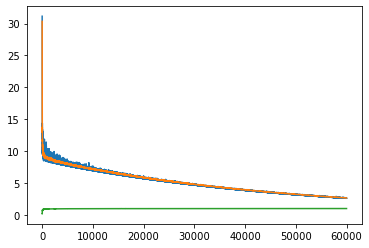

In [40]:
model.visulization()

In [19]:
model.predict(test_data, test_labels)

the accuracy of test_data:0.9499
